# Autocast / AMP in PyTorch: A Deep Practical Reference

Every neural network is fundamentally a giant mathematical expression, and training is the process of tuning the constants (weights) so that expression approximates reality. We do this by computing a loss, backpropagating to get gradients, and nudging the weights a tiny bit in the right direction. Repeat billions of times.

Why do we care about this *now*? Because modern deep learning training is GPU-dominated and compute-hungry. Matrix multiplications are embarrassingly parallel, so GPUs can run thousands of tiny operations at once — but as models grow, the cost of training keeps rising. Mixed precision training is one of the highest-leverage efficiency techniques we have: it uses fast low-precision hardware (Tensor Cores / specialized units) where it's safe, while preserving FP32 where training would otherwise become numerically unstable.

But here's the thing: those weights and gradients are stored as **floating-point numbers**. And floating-point numbers are *not* real numbers. They are a finite approximation with a specific *resolution*. That resolution depends on the format — FP32, FP16, BF16, TF32, FP8 — and each format makes a different tradeoff between **range** (how large and small the numbers can get) and **precision** (how fine the steps between consecutive representable values are).

This matters because during training, we routinely deal with numbers spanning many orders of magnitude: weights around $1$ ($10^0$), gradients as small as $10^{-8}$, attention logits that can spike to $10^3$, and accumulations over thousands of values. A format that can't represent tiny gradients kills learning (they become zero). A format that can't represent large attention logits kills stability (they become infinity). A format that rounds too aggressively corrupts the running statistics that normalization layers depend on.

The fundamental question this notebook answers is: **when can we get away with lower resolution, and when does it break training?**

Autocast (AMP) is PyTorch's answer: a per-operation precision policy that routes each computation to the right format. Some ops get the speed of 16-bit. Some ops get the safety of 32-bit. The combined effect is faster training with (nearly) no loss in quality. But to understand *when* and *why* AMP works — and to debug it when it doesn't — you need to understand what floating-point formats can and cannot represent.

That's what this notebook is for.

---

This notebook is organized into **three sections**:

| # | Section | What you get |
|---|---|---|
| **1** | **Theory** | Floating-point range vs precision, FP16/BF16/FP32/TF32 comparison tables, underflow/overflow, what AMP is really doing |
| **2** | **What the literature says** | Paper-driven mental models (Micikevicius et al., Kalamkar et al., ZeRO, NVIDIA guidance), written explanations — *no experiments* |
| **3** | **Practicalities** | Hands-on experiments + graphs: progressive mixed-precision implementation from scratch, operator policy probes, dtype flow through a transformer, loss/gradient/scale curves under different precision regimes |

---

**After completing this notebook you should be able to answer (and debug) questions like:**

- Why does FP16 often need **loss scaling**, but BF16 often does not?
- What does `autocast` *actually* do per operation (matmul vs softmax vs layernorm)?
- Why do people talk about **FP32 master weights** and **optimizer state precision**?
- Why does adding `1e-4` to `1.0` in FP16 produce exactly `1.0`? (with the exact bit-level explanation)
- How can you *see* autocast happening inside a transformer forward pass?
- What fails if you try to "just train in half precision everywhere"?
- Why does naive BF16 often work where naive FP16 fails?
- What is the "sum vs mean" mystery under autocast?
- How does the gradient distribution relate to FP16's representable range?
- How many bytes per parameter does mixed-precision Adam training actually use?
- Why is floating-point addition NOT associative, and why does that matter for GPU reductions?
- What is catastrophic cancellation, and why does it make LayerNorm precision-sensitive?
- How does stochastic rounding differ from deterministic rounding, and when does it help?
- Which layers in a transformer are most affected by autocast precision changes?

---

## How to use this notebook

- Read the markdown, then run the code cells.
- Most experiments are designed to run in a few minutes on a single GPU.
- CPU-only runs are supported for the *conceptual* demos, but some mixed-precision behaviors (and speedups) are fundamentally GPU-driven.

### If you're in a hurry (recommended run path)

- **10 minutes:** run setup → Quick Reference table → **3.1 progressive mixed precision** plots
- **30–60 minutes (GPU):** add **3.6 TinyGPT training suite** (loss/time/memory graphs)
- **Deep dive:** run everything in order; each experiment builds on the previous mental model

---

## Table of contents

**Section 1 — Theory**
- Quick reference cheat sheet (the table you should memorize)
- Floating-point: range vs precision, IEEE 754 anatomy
- Number line visualization: where representable floats live
- FP16 vs BF16 vs FP32 vs TF32 (tables you can trust)
- The bit-level addition trap (why `1 + 1e-4 = 1` in FP16) — with step-by-step binary alignment
- Underflow, overflow, accumulation error
- **Non-associativity**: why summation order matters in low precision
- **Catastrophic cancellation**: why LayerNorm/BatchNorm need FP32
- **Kahan summation**: the compensated-sum fix
- **TF32**: the format you're using without knowing it
- **Tensor Core mechanics**: why mixed precision is fast (tile-based MMA, dimension alignment)
- What AMP is (autocast + grad scaling)
- Master weights, optimizer state, and accumulation

**Section 2 — What the literature says**
- Micikevicius et al. — *Mixed Precision Training*
- Kalamkar et al. — *A Study of BFLOAT16 for Deep Learning Training*
- NVIDIA mixed precision guidance
- BF16 design intent
- PyTorch AMP operator policy
- PyTorch AMP examples: accumulation, penalties, multi-optimizer patterns
- `torch.amp` API modernization + backend portability
- Thread-local autocast semantics + nested precision regions
- **Stochastic rounding**: why it helps low-precision training (Gupta et al.)
- Rajbhandari et al. — ZeRO and optimizer state precision
- LLM training stacks (FSDP/ZeRO) and where AMP fits
- FP8 in practice: row-wise scaling + float8 all-gather (FSDP2)
- Blackwell-era microscaling (MXFP8 / NVFP4)
- FP8 and 8-bit optimizers

**Section 3 — Practicalities**
- Progressive mixed-precision implementation from scratch (FP32 → naive FP16 → **naive BF16** → master weights → loss scaling → PyTorch AMP)
- Build an operator policy table *from your local PyTorch*
- The "sum vs mean" mystery
- **Per-layer precision toy examples**: attention, activations, FFN — why autocast treats each differently
- **Numerical stability stress tests**: adversarial inputs for softmax, LayerNorm, cross-entropy
- Visualize dtype flow through a transformer (4 configurations)
- **Autocast boundary flow diagram**: visual dtype transitions per module across configs
- **Per-layer precision sensitivity**: which parts of the transformer hurt most? (forward + backward)
- **Per-layer gradient sensitivity**: which layers corrupt gradients the most in FP16?
- Gradient underflow + the effect of loss scaling
- **Micikevicius-style gradient histogram analysis**
- **Gradient distribution evolution**: how the histogram shifts during training + loss scaling effect
- Weight update stagnation
- Train a tiny causal LM under different precision regimes (FP32, FP16 naive, BF16 naive, AMP FP16, AMP BF16)
- **OPT-125M training loss curves**: real-world AMP on a 125M-parameter Hugging Face model (6 configs)
- Plot and interpret loss/time/scale/gradient curves + summary bar charts

---

## Quick glossary

| Term | Meaning |
|---|---|
| **AMP** | Automatic Mixed Precision (in PyTorch: `torch.amp`) |
| **autocast** | Context manager that applies a per-operation dtype policy |
| **GradScaler / loss scaling** | Rescales loss to avoid FP16 gradient underflow |
| **master weights** | Keep weights in FP32 for updates, cast for compute |
| **underflow** | Magnitude too small → becomes 0 (or subnormal/denormal) |
| **overflow** | Magnitude too large → becomes `inf` |
| **TF32** | TensorFloat-32 — an NVIDIA format with FP32 range but 10-bit mantissa, used transparently in Ampere+ matmuls |
| **ULP** | Unit in the Last Place — the spacing between adjacent representable floats |
| **epsilon** | Smallest number such that `1.0 + eps > 1.0` in a given format |

## Prerequisites

You need:
- Python 3.10+
- PyTorch 2.x
- `matplotlib`, `numpy`, `pandas`, `tqdm`
- (optional) `transformers` + `safetensors` (only for the OPT-125M dtype-tracing section)

### Install (CPU-only quick start)
```bash
pip install torch numpy pandas matplotlib tqdm
```

### Optional (to run the OPT-125M dtype-tracing section)
```bash
pip install transformers safetensors
```

### Install (CUDA)
Install the correct PyTorch + CUDA build from the [official PyTorch instructions](https://pytorch.org/get-started/locally/).

---

This notebook is written to *degrade gracefully*:
- If BF16 is not supported on your GPU, BF16 experiments will be skipped.
- If FP16 training without scaling explodes (often does), we record that as a result rather than pretending it "worked".

> **Note:** on Apple Silicon, this notebook defaults to **CPU** for maximum compatibility. If you want to try the Apple GPU backend, set `USE_MPS_IF_AVAILABLE = True` in the first code cell. AMP/autocast behavior is best-defined on CUDA; CPU/MPS support exists but has different operator coverage and performance characteristics.

> **Note on editing:** `amp.ipynb` is generated by `_build_notebook.py`.
>
> If you want to change the content, edit `_build_notebook.py` and regenerate:
>
> ```bash
> python3 _build_notebook.py
> ```

In [1]:
# Core imports + environment report
import os, math, time, random, struct, platform
from dataclasses import dataclass
from contextlib import nullcontext

try:
    import numpy as np
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Missing dependency: numpy. Install with: pip install numpy") from e

try:
    import pandas as pd
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Missing dependency: pandas. Install with: pip install pandas") from e

try:
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Missing dependency: matplotlib. Install with: pip install matplotlib") from e

try:
    from tqdm.auto import tqdm
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Missing dependency: tqdm. Install with: pip install tqdm") from e

from IPython.display import display

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 100,
})

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "PyTorch is required. CPU-only: pip install torch"
    ) from e

# Prefer torch.amp (newer API)
if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
    autocast = torch.amp.autocast
    GradScaler = torch.amp.GradScaler
else:
    autocast = torch.cuda.amp.autocast
    GradScaler = torch.cuda.amp.GradScaler

def amp_autocast(dev: torch.device, dtype: torch.dtype | None, enabled: bool = True, cache_enabled: bool = True):
    # Best-effort autocast context manager that degrades gracefully.
    if (not enabled) or (dtype is None):
        return nullcontext()
    try:
        return autocast(device_type=dev.type, dtype=dtype, enabled=True, cache_enabled=cache_enabled)
    except TypeError:
        # Older signatures may not support cache_enabled.
        try:
            return autocast(device_type=dev.type, dtype=dtype, enabled=True)
        except Exception as e:
            print(f"[warn] autocast unavailable for device_type={dev.type}: {e}. Running without autocast.")
            return nullcontext()
    except Exception as e:
        print(f"[warn] autocast unavailable for device_type={dev.type}: {e}. Running without autocast.")
        return nullcontext()

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)

# ---- User knobs -------------------------------------------------------------
# Leave as-is for "works everywhere" defaults; tweak if you have specific HW.
PREFERRED_DEVICE = None   # one of: "cuda", "mps", "cpu" (or None for auto)
USE_MPS_IF_AVAILABLE = False  # Apple Silicon: set True to try MPS when no CUDA

def choose_device():
    if PREFERRED_DEVICE is not None:
        pref = str(PREFERRED_DEVICE).lower()
        if pref == "cuda" and torch.cuda.is_available():
            return torch.device("cuda")
        if pref == "mps" and getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
            return torch.device("mps")
        if pref == "cpu":
            return torch.device("cpu")
        print(f"[warn] Requested device '{PREFERRED_DEVICE}' not available; falling back to auto.")

    if torch.cuda.is_available():
        return torch.device("cuda")
    if USE_MPS_IF_AVAILABLE and getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = choose_device()

def supports_dtype_on_device(dtype: torch.dtype, dev: torch.device) -> bool:
    try:
        torch.tensor([0.0], device=dev, dtype=dtype)
        return True
    except Exception:
        return False

print(f"PyTorch {torch.__version__}")
print(f"Python  {platform.python_version()}")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"CUDA:   {torch.version.cuda}")
    print(f"GPU:    {torch.cuda.get_device_name(0)}")
    print(f"BF16:   {'supported' if torch.cuda.is_bf16_supported() else 'NOT supported'}")
elif device.type == "mps":
    print("MPS:    available (Apple Silicon)")
    print(f"FP16:   {'supported' if supports_dtype_on_device(torch.float16, device) else 'NOT supported'}")
    print(f"BF16:   {'supported' if supports_dtype_on_device(torch.bfloat16, device) else 'NOT supported'}")

PyTorch 2.10.0+cu128
Python  3.12.12
Device: cuda
CUDA:   12.8
GPU:    NVIDIA A100-SXM4-40GB
BF16:   supported


## Quick Reference: Floating-Point Formats for Deep Learning

This is the table you should memorize. Every design decision in AMP traces back to these numbers.

In [2]:
# Generate the cheat sheet from your local PyTorch (so the numbers are trustworthy)

def _ulp_at_one(dtype):
    try:
        one = torch.tensor(1.0, dtype=dtype)
        return float(torch.nextafter(one, one + one) - one)
    except Exception:
        return None

def _smallest_subnormal(dtype):
    try:
        z = torch.tensor(0.0, dtype=dtype)
        o = torch.tensor(1.0, dtype=dtype)
        return float(torch.nextafter(z, o))
    except Exception:
        return None

rows = []
format_specs = [
    # FP8 rows are included even if float8 dtypes are unavailable at runtime.
    {
        "name": "FP8 (E4M3)",
        "dtype": getattr(torch, "float8_e4m3fn", None),
        "exp_bits": 4,
        "mant_bits": 3,
        "fallback": {
            "bits": 8,
            "eps": "1.25e-01",
            "ulp1": "1.25e-01",
            "tiny": "1.56e-02",
            "sub": "1.95e-03",
            "max": "4.48e+02",
            "exp_range": "[-6, 7]",
        },
    },
    {
        "name": "FP8 (E5M2)",
        "dtype": getattr(torch, "float8_e5m2", None),
        "exp_bits": 5,
        "mant_bits": 2,
        "fallback": {
            "bits": 8,
            "eps": "2.50e-01",
            "ulp1": "2.50e-01",
            "tiny": "6.10e-05",
            "sub": "1.53e-05",
            "max": "5.73e+04",
            "exp_range": "[-14, 15]",
        },
    },
    {
        "name": "FP16 (IEEE half)",
        "dtype": torch.float16,
        "exp_bits": 5,
        "mant_bits": 10,
        "fallback": None,
    },
    {
        "name": "BF16 (brain float)",
        "dtype": torch.bfloat16,
        "exp_bits": 8,
        "mant_bits": 7,
        "fallback": None,
    },
    {
        "name": "FP32 (single)",
        "dtype": torch.float32,
        "exp_bits": 8,
        "mant_bits": 23,
        "fallback": None,
    },
    {
        "name": "TF32 (tensor float)",
        "dtype": None,
        "exp_bits": 8,
        "mant_bits": 10,
        "fallback": {
            "bits": "19*",
            "eps": "9.77e-04",
            "ulp1": "9.77e-04",
            "tiny": "1.18e-38",
            "sub": "n/a (internal)",
            "max": "3.40e+38",
            "exp_range": "[-126, 127]",
        },
    },
    {
        "name": "FP64 (double)",
        "dtype": torch.float64,
        "exp_bits": 11,
        "mant_bits": 52,
        "fallback": None,
    },
]

for spec in format_specs:
    name = spec["name"]
    dt = spec["dtype"]
    exp_b = spec["exp_bits"]
    mant_b = spec["mant_bits"]
    fb = spec["fallback"]

    runtime_available = False
    if name.startswith("TF32"):
        runtime_available = (device.type == "cuda")

    fi = None
    if dt is not None:
        try:
            fi = torch.finfo(dt)
            runtime_available = True
        except Exception:
            fi = None

    if fi is not None:
        ulp1 = _ulp_at_one(dt)
        sub = _smallest_subnormal(dt)
        bits = fi.bits
        exp_range = f"[{-2**(exp_b-1)+2}, {2**(exp_b-1)-1}]"
        eps_s = f"{fi.eps:.2e}"
        ulp_s = f"{ulp1:.2e}" if ulp1 is not None else "n/a"
        tiny_s = f"{fi.tiny:.2e}"
        sub_s = f"{sub:.2e}" if sub is not None else "n/a"
        max_s = f"{fi.max:.2e}"
    else:
        bits = fb["bits"] if fb is not None else "n/a"
        exp_range = fb["exp_range"] if fb is not None else "n/a"
        eps_s = fb["eps"] if fb is not None else "n/a"
        ulp_s = fb["ulp1"] if fb is not None else "n/a"
        tiny_s = fb["tiny"] if fb is not None else "n/a"
        sub_s = fb["sub"] if fb is not None else "n/a"
        max_s = fb["max"] if fb is not None else "n/a"

    rows.append({
        "Format": name,
        "Available in this runtime": "yes" if runtime_available else "no",
        "Total bits": bits,
        "Exponent bits": exp_b,
        "Mantissa bits": mant_b,
        "Precision bits (incl hidden 1)": mant_b + 1,
        "Approx decimal digits": round((mant_b + 1) * math.log10(2), 1),
        "Exponent range": exp_range,
        "epsilon (ULP at 1.0)": eps_s,
        "ULP at 1.0": ulp_s,
        "Min normal": tiny_s,
        "Min subnormal": sub_s,
        "Max finite": max_s,
    })

df_cheat = pd.DataFrame(rows).set_index("Format")
display(df_cheat)

print()
print("Rows marked 'no' still show reference values so the table stays complete.")
print("* TF32 is not a storage format. It is used internally by Tensor Cores on")
print("  Ampere+ GPUs for FP32 matmuls: FP32 range, but only 10 mantissa bits.")
print("  Your 'FP32 baseline' on Ampere+ may secretly be TF32 precision.")

,Available in this runtime,Total bits,Exponent bits,Mantissa bits,Precision bits (incl hidden 1),Approx decimal digits,Exponent range,epsilon (ULP at 1.0),ULP at 1.0,Min normal,Min subnormal,Max finite
Format,,,,,,,,,,,,
FP8 (E4M3),yes,8,4,3,4,1.2,"[-6, 7]",1.25e-01,n/a,1.56e-02,n/a,4.48e+02
FP8 (E5M2),yes,8,5,2,3,0.9,"[-14, 15]",2.50e-01,n/a,6.10e-05,n/a,5.73e+04
FP16 (IEEE half),yes,16,5,10,11,3.3,"[-14, 15]",9.77e-04,9.77e-04,6.10e-05,5.96e-08,6.55e+04
BF16 (brain float),yes,16,8,7,8,2.4,"[-126, 127]",7.81e-03,7.81e-03,1.18e-38,9.18e-41,3.39e+38
FP32 (single),yes,32,8,23,24,7.2,"[-126, 127]",1.19e-07,1.19e-07,1.18e-38,1.40e-45,3.40e+38
TF32 (tensor float),yes,19*,8,10,11,3.3,"[-126, 127]",9.77e-04,9.77e-04,1.18e-38,n/a (internal),3.40e+38
FP64 (double),yes,64,11,52,53,16.0,"[-1022, 1023]",2.22e-16,2.22e-16,2.23e-308,4.94e-324,1.80e+308



Rows marked 'no' still show reference values so the table stays complete.
* TF32 is not a storage format. It is used internally by Tensor Cores on
  Ampere+ GPUs for FP32 matmuls: FP32 range, but only 10 mantissa bits.
  Your 'FP32 baseline' on Ampere+ may secretly be TF32 precision.


### How to read this table

Think of a floating-point format as a **measuring tape**:
- **Exponent bits** determine the **length** of the tape (range: how big/small magnitudes you can reach).
- **Mantissa bits** determine how **fine the tick marks** are (precision: how many significant digits you keep).

| Format | Range | Precision | Training implication |
|---|---|---|---|
| **FP8** | Very narrow | Very low | Needs careful scaling (per-tensor/per-channel), mostly used with specialized kernels/hardware |
| **FP16** | Narrow (5-bit exp) | Moderate (10-bit mantissa) | Underflow risk for gradients, overflow risk for activations → needs **loss scaling** |
| **BF16** | Wide (8-bit exp, same as FP32) | Low (7-bit mantissa) | Rarely underflows → usually **no loss scaling** needed, but coarse rounding in reductions |
| **FP32** | Wide | High | Stable baseline; slower and more memory |
| **TF32** | Wide | Moderate (10-bit mantissa) | Compute-only on Ampere+ GPUs: FP32 matmuls may silently use TF32 for speed |
| **FP64** | Very wide | Very high | Mostly for numeric reference/debugging (too slow for large training) |

**Two immediate consequences:**
1. FP16 has more mantissa bits than BF16 → **better precision per value**.
2. BF16 has the same exponent width as FP32 → **dramatically better range** than FP16.

So: FP16 fails first due to **range** (underflow/overflow). BF16 fails first due to **precision** (rounding/accumulation error). FP8 fails due to both unless extra care is taken.

Autocast exists to route computations so that you get the performance of 16-bit compute without the worst numeric failure modes.

Key observations:
  - BF16 has the SAME exponent width as FP32 (8 bits) → same range → no underflow issues
  - FP16 has a NARROWER exponent (5 bits) but MORE mantissa than BF16 → better precision, worse range
  - TF32 combines FP32's exponent with FP16's mantissa width (10 bits) → internal to Tensor Cores
  - FP8 formats have tiny mantissa → need per-tensor scaling to be usable

* TF32 is 19 bits internally but is NOT a storage format. Tensor Cores use it transparently for FP32 matmuls.


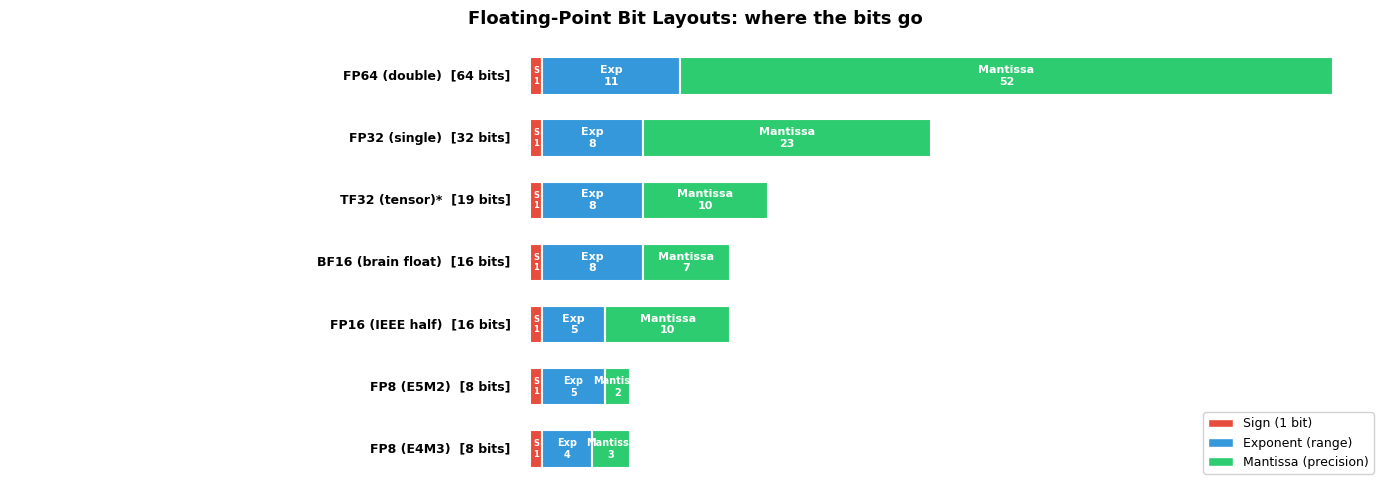

In [3]:
# Visual bit layout: sign / exponent / mantissa for each format
# This is the single most referenced diagram in floating-point explanations.

formats_vis = [
    ("FP64 (double)",     1, 11, 52, 64),
    ("FP32 (single)",     1,  8, 23, 32),
    ("TF32 (tensor)*",    1,  8, 10, 19),
    ("BF16 (brain float)",1,  8,  7, 16),
    ("FP16 (IEEE half)",  1,  5, 10, 16),
    ("FP8 (E5M2)",        1,  5,  2,  8),
    ("FP8 (E4M3)",        1,  4,  3,  8),
]

fig, ax = plt.subplots(figsize=(14, 5))

y_positions = list(range(len(formats_vis)))[::-1]
bar_height = 0.6
max_bits = max(f[4] for f in formats_vis)

for i, (name, s_bits, e_bits, m_bits, total) in enumerate(formats_vis):
    y = y_positions[i]
    # Scale bar width proportional to bit count (relative to max)
    scale = 0.85  # fraction of plot width for the widest format
    bit_width = scale / max_bits

    # Draw sign bits
    ax.barh(y, s_bits * bit_width, height=bar_height, left=0,
            color="#e74c3c", edgecolor="white", linewidth=1.5, zorder=3)
    # Draw exponent bits
    ax.barh(y, e_bits * bit_width, height=bar_height, left=s_bits * bit_width,
            color="#3498db", edgecolor="white", linewidth=1.5, zorder=3)
    # Draw mantissa bits
    ax.barh(y, m_bits * bit_width, height=bar_height, left=(s_bits + e_bits) * bit_width,
            color="#2ecc71", edgecolor="white", linewidth=1.5, zorder=3)

    # Labels inside bars
    mid_s = s_bits * bit_width / 2
    mid_e = (s_bits + e_bits / 2) * bit_width
    mid_m = (s_bits + e_bits + m_bits / 2) * bit_width

    fontsize = 8 if total >= 16 else 7
    if s_bits >= 1:
        ax.text(mid_s, y, f"S\n{s_bits}", ha="center", va="center", fontsize=6, fontweight="bold", color="white")
    ax.text(mid_e, y, f"Exp\n{e_bits}", ha="center", va="center", fontsize=fontsize, fontweight="bold", color="white")
    if m_bits >= 2:
        ax.text(mid_m, y, f"Mantissa\n{m_bits}", ha="center", va="center", fontsize=fontsize, fontweight="bold", color="white")
    else:
        ax.text(mid_m, y, f"M{m_bits}", ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Format name and total bits on the left
    ax.text(-0.02, y, f"{name}  [{total} bits]", ha="right", va="center", fontsize=9, fontweight="bold")

ax.set_xlim(-0.55, max_bits * scale / max_bits + 0.05)
ax.set_ylim(-0.5, len(formats_vis) - 0.5)
ax.set_yticks([])
ax.set_xticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title("Floating-Point Bit Layouts: where the bits go", fontsize=13, fontweight="bold", pad=15)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#e74c3c", edgecolor="white", label="Sign (1 bit)"),
    Patch(facecolor="#3498db", edgecolor="white", label="Exponent (range)"),
    Patch(facecolor="#2ecc71", edgecolor="white", label="Mantissa (precision)"),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=9, framealpha=0.9)

plt.tight_layout()

print("Key observations:")
print("  - BF16 has the SAME exponent width as FP32 (8 bits) → same range → no underflow issues")
print("  - FP16 has a NARROWER exponent (5 bits) but MORE mantissa than BF16 → better precision, worse range")
print("  - TF32 combines FP32's exponent with FP16's mantissa width (10 bits) → internal to Tensor Cores")
print("  - FP8 formats have tiny mantissa → need per-tensor scaling to be usable")
print()
print("* TF32 is 19 bits internally but is NOT a storage format. Tensor Cores use it transparently for FP32 matmuls.")

## Mixed Precision / Autocast Regimes (PyTorch) — Cheat Sheet

This is the "optimizer table" equivalent for AMP: a small set of regimes that cover most real training setups.

**Rule of thumb (training):**
- If you have CUDA + BF16 support → use **BF16 autocast** (usually no GradScaler).
- Else if you have CUDA → use **FP16 autocast + GradScaler**.
- Avoid `model.half()` / "everything FP16" for training unless you're deliberately doing it (it removes autocast's safety policy and makes optimizer math low precision).

| Regime (common name) | What you set | What runs in 16-bit | What stays FP32 (by policy) | Loss scaling | Typical outcome |
|---|---|---|---|---|---|
| **FP32 baseline** | model params FP32, autocast OFF | nothing | everything | no | stable, slower |
| **FP32 + TF32 matmuls** | Ampere+ default unless disabled | matmuls use **TF32** internally | everything else FP32 | no | stable + faster, but matmul precision is ~FP16 mantissa |
| **AMP BF16 (recommended if supported)** | model params FP32, `autocast(dtype=bf16)` | matmuls / linears / convs | softmax / layernorm / losses / big reductions | no | stable + fast (range like FP32) |
| **AMP FP16 + GradScaler** | model params FP32, `autocast(dtype=fp16)` + `GradScaler` | matmuls / linears / convs | softmax / layernorm / losses / big reductions | **yes** | stable + fast (but FP16 gradients need scaling) |
| **Naive BF16** | model params BF16, autocast OFF | everything | almost nothing | no | often "works", but sensitive ops can drift (reductions/normalization) |
| **Naive FP16** | model params FP16, autocast OFF | everything | almost nothing | maybe (manual) | frequently unstable (underflow/overflow + update stagnation) |

**Key idea:** autocast is useful even if you *could* run everything in BF16/FP16 — it keeps the numerically sensitive operations in FP32.

In [4]:
# Suggest an AMP recipe for THIS machine

def recommend_amp_recipe(dev: torch.device):
    rec = {"device": dev.type}
    if dev.type == "cuda":
        bf16_ok = torch.cuda.is_bf16_supported()
        rec["bf16_supported"] = bool(bf16_ok)
        if bf16_ok:
            rec["recommended_autocast_dtype"] = "bfloat16"
            rec["use_grad_scaler"] = False
            rec["why"] = "BF16 has FP32-like exponent range → underflow is rare."
        else:
            rec["recommended_autocast_dtype"] = "float16"
            rec["use_grad_scaler"] = True
            rec["why"] = "FP16 has narrow exponent range → GradScaler rescues gradients from underflow."
        rec["note"] = "Keep model parameters in FP32; let autocast choose per-op dtypes."
    elif dev.type == "cpu":
        rec["recommended_autocast_dtype"] = "bfloat16"
        rec["use_grad_scaler"] = False
        rec["why"] = "CPU autocast supports BF16; speedups vary by CPU/kernel support."
        rec["note"] = "CPU demos here are mostly about numerics, not performance."
    elif dev.type == "mps":
        rec["recommended_autocast_dtype"] = "float16"
        rec["use_grad_scaler"] = False
        rec["why"] = "MPS typically uses FP16 for reduced precision."
        rec["note"] = "Operator coverage differs from CUDA; verify dtype behavior with the probes in Section 3."
    else:
        rec["recommended_autocast_dtype"] = "float32"
        rec["use_grad_scaler"] = False
        rec["why"] = "Unknown device type."
        rec["note"] = ""
    return rec

display(pd.DataFrame([recommend_amp_recipe(device)]))

,device,bf16_supported,recommended_autocast_dtype,use_grad_scaler,why,note
0,cuda,True,bfloat16,False,BF16 has FP32-like exponent range → underflow ...,Keep model parameters in FP32; let autocast ch...


# Section 1 — Theory

The core trick of autocast is simple to state:

> **Run the *right* operations in lower precision for speed/memory, while keeping *numerically sensitive* operations in FP32.**

But to understand *why* this works (and when it doesn't), we need to understand what floating-point formats can and cannot represent.

## 1.0 Where floating-point lives during training (and why autocast exists)

A single training step can be decomposed into:

1. **Forward**: parameters + activations → logits
2. **Loss**: logits + targets → scalar loss
3. **Backward**: loss → gradients for parameters
4. **Optimizer update**: parameters + gradients (+ optimizer state) → new parameters

Different tensors have different numeric requirements:

| Tensor | Typical AMP dtype | Why |
|---|---|---|
| Activations / matmul results | FP16/BF16 (where safe) | Saves memory + uses Tensor Cores |
| Softmax / LayerNorm stats / reductions | FP32 | Protects against overflow + rounding accumulation |
| Gradients | Often FP32 *storage* (even if compute is mixed) | Stable updates + compatibility with optimizers |
| Parameters ("master weights") | FP32 | Prevents update stagnation |
| Optimizer state (Adam moments) | FP32 | Long-horizon accumulation is precision-sensitive |

**Autocast's job** is mostly about **(1) and (2)**: choose per-op dtypes during the forward pass.

**GradScaler's job** is mostly about **(3)** when FP16 is involved: keep gradients from underflowing to zero.

## 1.1 Floating-point is "range + precision", not just "more bits = better"

A binary floating-point number is roughly:

$$(-1)^{\text{sign}} \times (1.\text{mantissa}) \times 2^{\text{exponent}}$$

The bit budget is split across:

- **Exponent bits** → *range* (how large/small magnitudes you can represent)
- **Mantissa (fraction) bits** → *precision* (how many significant bits you keep)

For deep learning training, the key question is not "can I store 3.14159?" but:

- Can I represent **tiny gradients** without them becoming 0 (underflow)?
- Can I represent **large activations** without them becoming `inf` (overflow)?
- Can I sum many numbers without destroying meaning via rounding?

These failure modes show up differently in FP16 and BF16.

### 1.1.1 IEEE 754 anatomy (sign, exponent bias, hidden bit)

A *normalized* binary floating-point value is encoded as:
- **sign bit** $s$ (0 = positive, 1 = negative)
- **exponent field** $E$ (stored with a **bias** so we can represent negative exponents)
- **mantissa / fraction field** $m$

For normalized numbers:

$$\text{value} = (-1)^s \times (1 + m) \times 2^{(E - \text{bias})}$$

Key details:
- The leading `1.` is **implicit** (the "hidden bit"), giving you 1 extra bit of effective precision for free.
- Exponent all-zeros and all-ones are **reserved**: `E=0` → subnormals / zero; `E=all ones` → `inf` / `nan`.
- The **bias** is $2^{(\text{exp\_bits} - 1)} - 1$. For FP32: $127$. For FP16: $15$. For BF16: $127$.

Let's decode $\pi$ in all three formats to see this concretely.

In [5]:
# Bit-level decoding of pi across FP32, FP16, BF16

def bits_f32(x: float) -> str:
    (u32,) = struct.unpack(">I", struct.pack(">f", float(x)))
    return f"{u32:032b}"

def bits_f16(x: float) -> str:
    u16 = np.frombuffer(np.float16(x).tobytes(), dtype=np.uint16)[0]
    return f"{int(u16):016b}"

def bits_bf16(x: float) -> str:
    t = torch.tensor(float(x), dtype=torch.bfloat16)
    i16 = int(t.view(torch.int16).item()) & 0xFFFF
    return f"{i16:016b}"

def decode_float(bits: str, exp_bits: int, mant_bits: int, bias: int):
    s = int(bits[0], 2)
    E = int(bits[1:1+exp_bits], 2)
    M_bits = bits[1+exp_bits:]
    assert len(M_bits) == mant_bits

    if E == 0:
        exp = 1 - bias
        mant = sum(int(b) * (2 ** (-(i+1))) for i, b in enumerate(M_bits))
        val = ((-1)**s) * mant * (2**exp)
        return "subnormal/zero", s, E, exp, mant, val

    if E == (2**exp_bits - 1):
        return "inf/nan", s, E, None, None, None

    exp = E - bias
    mant = sum(int(b) * (2 ** (-(i+1))) for i, b in enumerate(M_bits))
    val = ((-1)**s) * (1.0 + mant) * (2**exp)
    return "normal", s, E, exp, mant, val

x = math.pi
rows = []

for name, get_bits, eb, mb, bias in [
    ("float32", bits_f32, 8, 23, 127),
    ("float16", bits_f16, 5, 10, 15),
    ("bfloat16", bits_bf16, 8, 7, 127),
]:
    b = get_bits(x)
    kind, s, E, exp, mant, val = decode_float(b, eb, mb, bias)
    rows.append({
        "dtype": name,
        "bits": f"{b[:1]}|{b[1:1+eb]}|{b[1+eb:]}",
        "sign": s, "E(stored)": E, "exponent": exp,
        "1+mantissa": round(1 + mant, 8) if mant is not None else None,
        "decoded": round(val, 10) if val is not None else None,
        "error vs pi": f"{abs(val - math.pi):.2e}" if val is not None else None,
    })

display(pd.DataFrame(rows))
print(f"\nTrue pi = {math.pi}")
print("Notice: BF16 and FP16 both decode to 3.140625, but via different bit patterns.")
print("FP16 has more mantissa bits (10) giving finer precision; BF16 has fewer (7) but same exponent range as FP32.")

,dtype,bits,sign,E(stored),exponent,1+mantissa,decoded,error vs pi
0,float32,0|10000000|10010010000111111011011,0,128,1,1.570796,3.141593,8.74e-08
1,float16,0|10000|1001001000,0,16,1,1.570312,3.140625,9.68e-04
2,bfloat16,0|10000000|1001001,0,128,1,1.570312,3.140625,9.68e-04



True pi = 3.141592653589793
Notice: BF16 and FP16 both decode to 3.140625, but via different bit patterns.
FP16 has more mantissa bits (10) giving finer precision; BF16 has fewer (7) but same exponent range as FP32.


### 1.1.2 Why FP32 → BF16 conversion is trivial (but FP32 → FP16 is not)

Since BF16 shares the same 8-bit exponent as FP32, converting FP32 to BF16 is just **truncating** (or rounding) the bottom 16 mantissa bits. The exponent field doesn't change, so no value can overflow or underflow during conversion.

Converting FP32 to FP16, on the other hand, requires **narrowing the exponent** from 8 bits to 5 bits. This means:
- FP32 values with exponents outside FP16's range (below $2^{-14}$ or above $2^{15}$) become 0 or `inf` during conversion.
- The conversion itself can destroy values even before you do any computation.

This is one reason BF16 is considered a "drop-in" replacement for FP32 in many training scenarios, while FP16 requires extra infrastructure (loss scaling, careful range management).

In [6]:
# FP32 → BF16 vs FP32 → FP16 conversion: what survives?

test_values = [3.14159, 1e-6, 1e-10, 1e-30, 1e-38, 1e30, 65504.0, 65536.0, 1e38]

rows = []
for v in test_values:
    fp32 = torch.tensor(v, dtype=torch.float32)
    bf16 = fp32.to(torch.bfloat16)
    fp16 = fp32.to(torch.float16)
    rows.append({
        "FP32 value": f"{v:.2e}",
        "→ BF16": f"{float(bf16):.4e}",
        "BF16 survived?": "inf/0" if not torch.isfinite(bf16) or float(bf16) == 0 and v != 0 else "YES",
        "BF16 rel error": f"{abs(float(bf16) - v) / (abs(v) + 1e-45):.2e}" if torch.isfinite(bf16) and float(bf16) != 0 else "-",
        "→ FP16": f"{float(fp16):.4e}",
        "FP16 survived?": "inf" if torch.isinf(fp16) else ("0 (underflow)" if float(fp16) == 0 and v != 0 else "YES"),
        "FP16 rel error": f"{abs(float(fp16) - v) / (abs(v) + 1e-45):.2e}" if torch.isfinite(fp16) and float(fp16) != 0 else "-",
    })

display(pd.DataFrame(rows))

print("\nKey takeaway:")
print("  BF16 preserves ALL magnitudes (same exponent range as FP32) — just loses some decimal precision.")
print("  FP16 DESTROYS values outside its narrow range: 1e-10 underflows to 0, 65536 overflows to inf.")
print("  This is why BF16 conversion is 'just truncate the mantissa' — safe and trivial.")

,FP32 value,→ BF16,BF16 survived?,BF16 rel error,→ FP16,FP16 survived?,FP16 rel error
0,3.14e+00,3.1406e+00,YES,3.07e-04,3.1406e+00,YES,3.07e-04
1,1.00e-06,9.9838e-07,YES,1.62e-03,1.0133e-06,YES,1.33e-02
2,1.00e-10,1.0004e-10,YES,4.44e-04,0.0000e+00,0 (underflow),-
3,1.00e-30,9.9840e-31,YES,1.60e-03,0.0000e+00,0 (underflow),-
4,1.00e-38,1.0010e-38,YES,1.01e-03,0.0000e+00,0 (underflow),-
5,1.00e+30,1.0003e+30,YES,2.56e-04,inf,inf,-
6,6.55e+04,6.5536e+04,YES,4.89e-04,6.5504e+04,YES,0.00e+00
7,6.55e+04,6.5536e+04,YES,0.00e+00,inf,inf,-
8,1.00e+38,9.9692e+37,YES,3.08e-03,inf,inf,-



Key takeaway:
  BF16 preserves ALL magnitudes (same exponent range as FP32) — just loses some decimal precision.
  FP16 DESTROYS values outside its narrow range: 1e-10 underflows to 0, 65536 overflows to inf.
  This is why BF16 conversion is 'just truncate the mantissa' — safe and trivial.


### 1.1.3 Normal vs subnormal numbers (and "flush-to-zero")

**Subnormals** (also called denormals) extend the representable range closer to 0 by giving up the implicit leading `1.`:

$$\text{subnormal value} = (-1)^s \times (0.\text{mantissa}) \times 2^{(1 - \text{bias})}$$

They matter because **gradients can be very small**. But subnormals can be slow on some hardware, so many compute paths enable **FTZ/DAZ** ("flush-to-zero" / "denormals-are-zero"), which means extremely small values become exactly 0.

**Practical lesson:** It is not enough to know the *spec* of a dtype. You also need to know what your hardware/kernel path does with subnormals.

Let's probe whether the smallest subnormal survives on your device.

In [7]:
# Subnormal survival probe

def subnormal_survives(dtype, dev):
    z = torch.tensor(0.0, dtype=dtype, device=dev)
    o = torch.tensor(1.0, dtype=dtype, device=dev)
    sub = torch.nextafter(z, o)
    return {
        "dtype": str(dtype), "device": dev.type,
        "nextafter(0,1)": f"{float(sub):.6e}",
        "is_zero": bool((sub == 0).item()),
    }

rows = []
for dt in [torch.float16, torch.bfloat16, torch.float32]:
    try:
        rows.append(subnormal_survives(dt, device))
    except Exception as e:
        rows.append({"dtype": str(dt), "device": device.type, "error": type(e).__name__})

pd.DataFrame(rows)

,dtype,device,"nextafter(0,1)",is_zero
0,torch.float16,cuda,5.960464e-08,False
1,torch.bfloat16,cuda,9.183550e-41,False
2,torch.float32,cuda,1.401298e-45,False


### 1.1.4 The measuring tape analogy

A good way to think about floating-point formats is as a **measuring tape**:
- The **length** of the tape is determined by the exponent bits (range: how big/small you can measure).
- The **fineness of the tick marks** is determined by the mantissa bits (precision: how closely you can read off a value).

FP32 is a long tape with fine tick marks. BF16 is equally long but with coarser tick marks. FP16 is a much shorter tape with tick marks finer than BF16 but coarser than FP32.

For training, **tape length (range) matters more than tick mark fineness (precision)** — because a gradient that falls *off the tape entirely* (underflow to zero) provides zero learning signal, while a gradient that lands *between tick marks* (rounding) still provides a useful approximate signal. SGD is inherently noisy; it tolerates imprecise gradients, but it cannot learn from absent ones.

/tmp/ipython-input-567/3359474176.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Key insight:
  FP32 and BF16 have the SAME tape length (range) — they can measure the same extremes.
  FP16 has a MUCH SHORTER tape — values beyond 2^15 ≈ 65504 overflow to infinity,
  and values below 2^-14 ≈ 6e-5 underflow to zero.

  But BF16's tick marks are 8x coarser than FP16's (128 vs 1024 levels per interval).
  For training, this tradeoff overwhelmingly favors BF16: coarse ticks = noise, short tape = death.


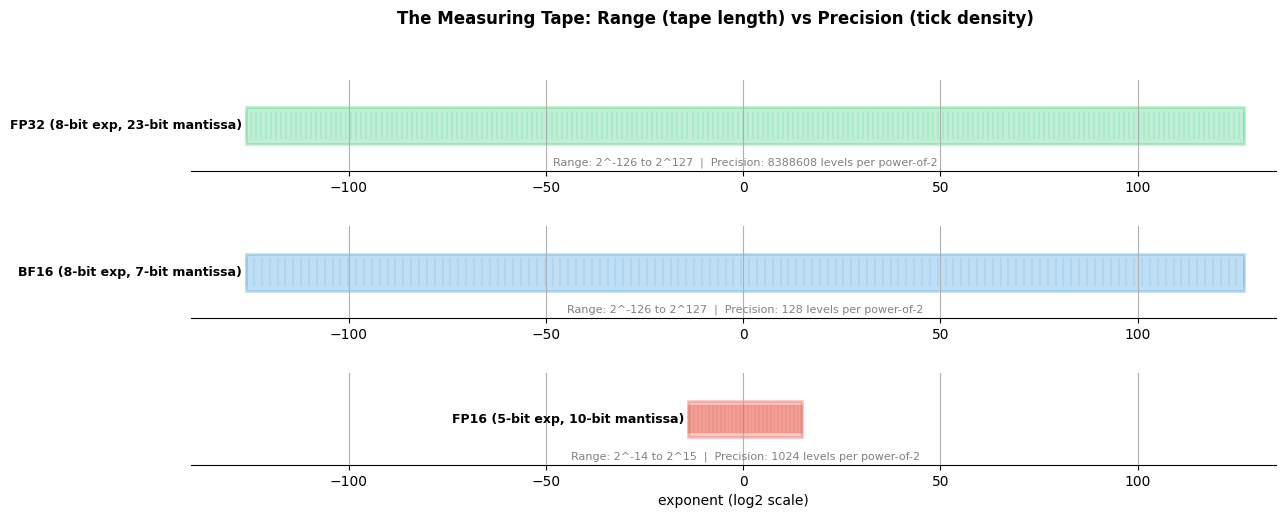

In [8]:
# The measuring tape: visualize range and precision as tape length vs tick density

fig, axes = plt.subplots(3, 1, figsize=(14, 5), gridspec_kw={"hspace": 0.6})

tape_configs = [
    ("FP32 (8-bit exp, 23-bit mantissa)", torch.float32, "#2ecc71", -126, 127, 23),
    ("BF16 (8-bit exp, 7-bit mantissa)",  torch.bfloat16, "#3498db", -126, 127, 7),
    ("FP16 (5-bit exp, 10-bit mantissa)", torch.float16, "#e74c3c", -14, 15, 10),
]

for ax, (label, dt, color, exp_min, exp_max, mant_bits) in zip(axes, tape_configs):
    # Draw the tape as a colored bar representing the exponent range
    tape_left = exp_min
    tape_right = exp_max
    full_range = 127 - (-126)  # FP32 range for normalization

    # Normalize to common axis
    ax.barh(0, tape_right - tape_left, left=tape_left, height=0.4,
            color=color, alpha=0.3, edgecolor=color, linewidth=2)

    # Draw tick marks proportional to mantissa precision
    # More mantissa bits = more ticks (denser)
    n_ticks = min(2 ** mant_bits, 200)  # cap for visualization
    tick_positions = np.linspace(tape_left, tape_right, n_ticks)
    for tp in tick_positions:
        ax.plot([tp, tp], [-0.15, 0.15], color=color, linewidth=0.3, alpha=0.6)

    # Labels
    ax.text(tape_left - 1, 0, label, ha="right", va="center", fontsize=9, fontweight="bold")
    ax.text((tape_left + tape_right) / 2, -0.35,
            f"Range: 2^{exp_min} to 2^{exp_max}  |  Precision: {2**mant_bits} levels per power-of-2",
            ha="center", va="top", fontsize=8, color="gray")

    ax.set_xlim(-140, 135)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("exponent (log2 scale)" if ax == axes[-1] else "")

fig.suptitle("The Measuring Tape: Range (tape length) vs Precision (tick density)", fontsize=12, fontweight="bold", y=1.02)
plt.tight_layout()

print("Key insight:")
print("  FP32 and BF16 have the SAME tape length (range) — they can measure the same extremes.")
print("  FP16 has a MUCH SHORTER tape — values beyond 2^15 ≈ 65504 overflow to infinity,")
print("  and values below 2^-14 ≈ 6e-5 underflow to zero.")
print()
print("  But BF16's tick marks are 8x coarser than FP16's (128 vs 1024 levels per interval).")
print("  For training, this tradeoff overwhelmingly favors BF16: coarse ticks = noise, short tape = death.")

### 1.1.5 ULP: spacing grows with magnitude

A float format has *roughly constant relative precision* but *variable absolute precision*.

- Near 1.0, FP16 spacing is ~$10^{-3}$.
- Near 1024, FP16 spacing is ~$1$.

This is the concrete reason "tiny updates disappear" when weights are stored in low precision.

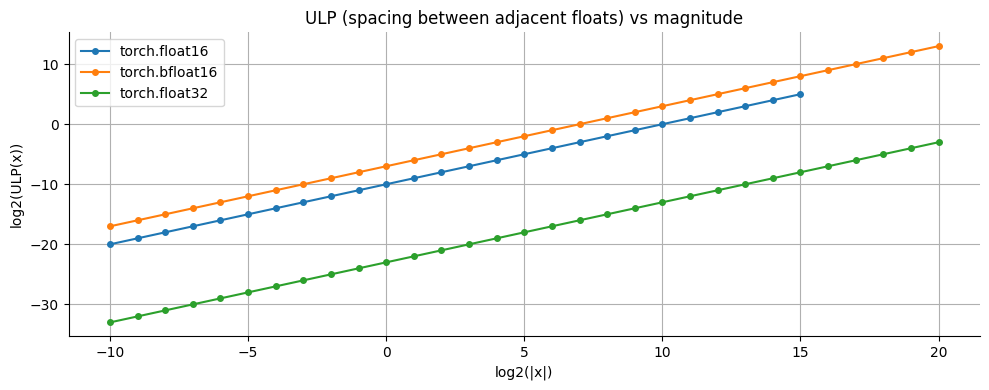

In [9]:
# ULP vs magnitude for each dtype

def ulp(x: torch.Tensor, dtype: torch.dtype):
    x = x.to(dtype)
    return (torch.nextafter(x, x * 2) - x).abs().to(torch.float32)

ks = torch.arange(-10, 21, device=device)
x = (2.0 ** ks).to(torch.float32)

plt.figure(figsize=(10, 4))
for dt, color in [(torch.float16, "C0"), (torch.bfloat16, "C1"), (torch.float32, "C2")]:
    if device.type == "cpu" and dt is torch.float16:
        continue
    u = ulp(x, dt).cpu().numpy()
    plt.plot(ks.cpu().numpy(), np.log2(u + 1e-45), marker="o", markersize=4, label=str(dt), color=color)

plt.title("ULP (spacing between adjacent floats) vs magnitude")
plt.xlabel("log2(|x|)")
plt.ylabel("log2(ULP(x))")
plt.legend()
plt.tight_layout();

### 1.1.6 Number line: where representable floats actually live

The spacing between representable numbers is *not uniform* — it depends on the magnitude. Near zero, floats are dense; as magnitude grows, they spread apart. And crucially, **different formats have different densities at every scale**.

This visualization plots the actual representable numbers in each format within a small interval. Think of it as zooming into the "measuring tape" to see the tick marks.

Key insight: BF16 has ~8x fewer representable values than FP16 in [1,2),
but FP16 has ~8,192x fewer than FP32. This is the precision-range tradeoff made visible.


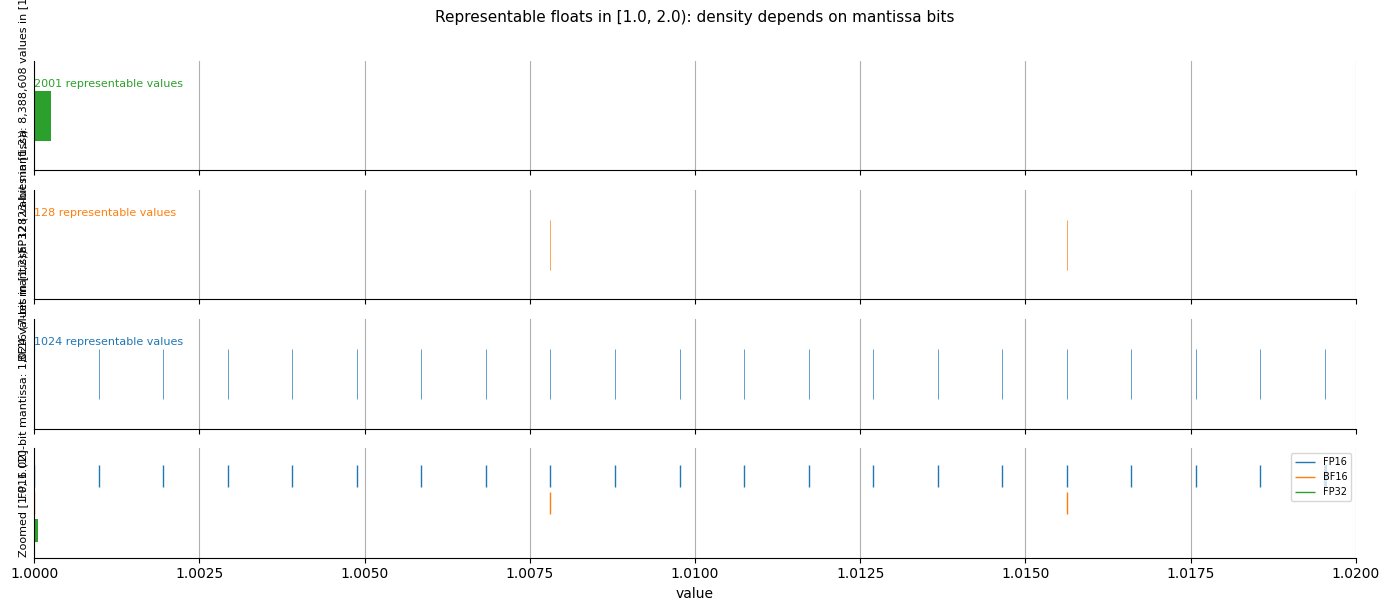

In [10]:
# Number line: representable floats in [1.0, 2.0) for each dtype
# This interval is illuminating because ULP is constant within a power-of-2 interval

fig, axes = plt.subplots(4, 1, figsize=(14, 6), sharex=True)

for ax, (dt, label, color) in zip(axes, [
    (torch.float32, "FP32 (23-bit mantissa: 8,388,608 values in [1,2))", "C2"),
    (torch.bfloat16, "BF16 (7-bit mantissa: 128 values in [1,2))", "C1"),
    (torch.float16, "FP16 (10-bit mantissa: 1,024 values in [1,2))", "C0"),
    (None, "Comparison overlay", "k"),
]):
    if dt is not None:
        one = torch.tensor(1.0, dtype=dt)
        two = torch.tensor(2.0, dtype=dt)
        vals = [float(one)]
        cur = one
        while True:
            cur = torch.nextafter(cur, two)
            if float(cur) >= 2.0:
                break
            vals.append(float(cur))
            if len(vals) > 2000:
                break
        vals = np.array(vals)
        ax.eventplot([vals], lineoffsets=0, linelengths=0.6, colors=color, linewidths=0.5)
        ax.set_ylabel(label, fontsize=8)
        ax.set_yticks([])
        ax.text(1.0, 0.35, f"{len(vals)} representable values", fontsize=8, color=color)
    else:
        # Overlay: show a narrow window [1.0, 1.02] with all three
        for dt2, c2, yoff in [(torch.float16, "C0", 0.3), (torch.bfloat16, "C1", 0.0), (torch.float32, "C2", -0.3)]:
            one2 = torch.tensor(1.0, dtype=dt2)
            limit = torch.tensor(1.02, dtype=dt2)
            vs = [float(one2)]
            cur2 = one2
            for _ in range(200):
                cur2 = torch.nextafter(cur2, limit)
                if float(cur2) >= 1.02:
                    break
                vs.append(float(cur2))
            vs = np.array(vs)
            ax.eventplot([vs], lineoffsets=yoff, linelengths=0.25, colors=c2, linewidths=1.0)
        ax.set_ylabel("Zoomed [1.0, 1.02]", fontsize=8)
        ax.set_yticks([])
        ax.set_xlim(1.0, 1.02)
        ax.legend(["FP16", "BF16", "FP32"], fontsize=7, loc="upper right")

axes[0].set_xlim(1.0, 2.0)
for ax in axes[:3]:
    ax.set_xlim(1.0, 2.0)
axes[-1].set_xlim(1.0, 1.02)
axes[-1].set_xlabel("value")
fig.suptitle("Representable floats in [1.0, 2.0): density depends on mantissa bits", fontsize=11, y=1.01)
plt.tight_layout();
print("Key insight: BF16 has ~8x fewer representable values than FP16 in [1,2),")
print("but FP16 has ~8,192x fewer than FP32. This is the precision-range tradeoff made visible.")

### 1.1.7 The bit-level addition trap (why `1 + 1e-4 = 1` in FP16)

This is the single most important numeric fact for understanding **weight update stagnation**.

When adding two floating-point numbers, the hardware must **align exponents** by shifting the smaller number's mantissa to the right. If the shift pushes all significant bits past the mantissa width, the smaller number is effectively lost.

**Concrete example (from the FP16 bit-level):**

- `1.0` in FP16: exponent = $2^0$, mantissa = all zeros.
- `1e-4` in FP16: exponent = $2^{-14}$, mantissa encodes ~1.639.
- To add them, we must shift `1e-4`'s mantissa by **14 positions** to align with `1.0`'s exponent.
- FP16 has only **10 mantissa bits**. After shifting 14 positions right, *all* significant bits fall off the edge.
- Result: `1.0 + 1e-4 = 1.0` exactly.

This is exactly what happens during training: if `learning_rate * gradient` is smaller than the ULP at the weight's magnitude, the weight **never changes**.

FP16's epsilon is ~$9.77 \times 10^{-4}$. Any update smaller than this relative to the weight magnitude is silently dropped.

In [11]:
# Demonstrate the addition trap across dtypes

print("Does 1.0 + delta produce a value > 1.0?\n")

deltas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
rows = []
for delta in deltas:
    row = {"delta": f"{delta:.0e}"}
    for name, dt in [("FP16", torch.float16), ("BF16", torch.bfloat16), ("FP32", torch.float32)]:
        one = torch.tensor(1.0, dtype=dt)
        d = torch.tensor(delta, dtype=dt)
        result = one + d
        changed = float(result) != float(one)
        row[name] = "YES" if changed else "no (lost!)"
    rows.append(row)

df_add = pd.DataFrame(rows)
display(df_add)

print("\nKey insight:")
print("- FP16 loses updates smaller than ~1e-3 relative to weight magnitude.")
print("- BF16 loses updates smaller than ~8e-3 (even coarser!).")
print("- FP32 loses updates smaller than ~1e-7.")
print("\nThis is why optimizers need FP32 master weights: typical lr*grad products")
print("are often 1e-5 to 1e-7, which FP16 and BF16 both silently discard.")

Does 1.0 + delta produce a value > 1.0?



,delta,FP16,BF16,FP32
0,1e-02,YES,YES,YES
1,1e-03,YES,no (lost!),YES
2,1e-04,no (lost!),no (lost!),YES
3,1e-05,no (lost!),no (lost!),YES
4,1e-06,no (lost!),no (lost!),YES
5,1e-07,no (lost!),no (lost!),YES
6,1e-08,no (lost!),no (lost!),no (lost!)



Key insight:
- FP16 loses updates smaller than ~1e-3 relative to weight magnitude.
- BF16 loses updates smaller than ~8e-3 (even coarser!).
- FP32 loses updates smaller than ~1e-7.

This is why optimizers need FP32 master weights: typical lr*grad products
are often 1e-5 to 1e-7, which FP16 and BF16 both silently discard.


### The bit-level mechanics: *why* `1.0 + 1e-4 = 1.0` in FP16

The table above shows *that* small updates get lost. Let's see *why* at the bit level.

When hardware adds two floats, it must **align their exponents** by right-shifting the smaller number's mantissa. If the shift exceeds the mantissa width, the smaller number's bits fall off completely.

This is the exact same mechanism that causes **weight update stagnation** during training: `weight += lr * gradient` produces the same weight if `lr * gradient` is too small relative to the weight's magnitude.

In [12]:
# Step-by-step bit alignment: why 1.0 + 1e-4 = 1.0 in FP16

print("=== Bit-level addition in FP16: 1.0 + 1e-4 ===\n")

# 1.0 in FP16
one_f16 = np.float16(1.0)
one_bits = f"{int(np.frombuffer(one_f16.tobytes(), dtype=np.uint16)[0]):016b}"
print(f"1.0 in FP16:   {one_bits[0]}|{one_bits[1:6]}|{one_bits[6:]}")
print(f"               s| exp  | mantissa")
print(f"               = (-1)^0 × 1.0000000000 × 2^(15 - 15) = 1.0")

print()

# 1e-4 in FP16
small_f16 = np.float16(1e-4)
small_bits = f"{int(np.frombuffer(small_f16.tobytes(), dtype=np.uint16)[0]):016b}"
E_small = int(small_bits[1:6], 2)
print(f"1e-4 in FP16:  {small_bits[0]}|{small_bits[1:6]}|{small_bits[6:]}")
print(f"               = (-1)^0 × 1.{small_bits[6:]} × 2^({E_small} - 15) = 2^{{{E_small - 15}}}")
print(f"               ≈ {float(small_f16):.6e}")

print()
print("--- Addition step: align exponents ---")
print()
shift = 15 - E_small
print(f"To add these, we align the smaller exponent ({E_small - 15}) to the larger (0).")
print(f"This means shifting 1e-4's mantissa RIGHT by {shift} positions.")
print()
print(f"  1.0:     1.{'0' * 10}         (exponent = 0)")
print(f"+ 1e-4:    0.{'0' * (shift - 1)}1{'?' * max(0, 10 - shift)}   (shifted {shift} positions right)")
print()
print(f"FP16 mantissa is only 10 bits wide.")
print(f"After shifting right by {shift}, ALL significant bits of 1e-4 are")
print(f"beyond the 10-bit mantissa boundary → they are discarded.")
print()
print(f"Result: 1.0 + 1e-4 = 1.0  (the small value vanished completely)")
print()

# Verify
result = np.float16(1.0) + np.float16(1e-4)
eps_f16 = np.finfo(np.float16).eps
print(f"Verification:  np.float16(1.0) + np.float16(1e-4) = {result}")
print(f"FP16 epsilon:  {eps_f16:.4e}")
print(f"1e-4 < eps?    {1e-4 < eps_f16}  → update is below FP16's resolution at magnitude 1.0")
print()
print("Training implication: if weight ≈ 1.0 and lr × grad ≈ 1e-4,")
print("the weight NEVER changes in FP16. This is weight update stagnation.")

=== Bit-level addition in FP16: 1.0 + 1e-4 ===

1.0 in FP16:   0|01111|0000000000
               s| exp  | mantissa
               = (-1)^0 × 1.0000000000 × 2^(15 - 15) = 1.0

1e-4 in FP16:  0|00001|1010001110
               = (-1)^0 × 1.1010001110 × 2^(1 - 15) = 2^{-14}
               ≈ 1.000166e-04

--- Addition step: align exponents ---

To add these, we align the smaller exponent (-14) to the larger (0).
This means shifting 1e-4's mantissa RIGHT by 14 positions.

  1.0:     1.0000000000         (exponent = 0)
+ 1e-4:    0.00000000000001   (shifted 14 positions right)

FP16 mantissa is only 10 bits wide.
After shifting right by 14, ALL significant bits of 1e-4 are
beyond the 10-bit mantissa boundary → they are discarded.

Result: 1.0 + 1e-4 = 1.0  (the small value vanished completely)

Verification:  np.float16(1.0) + np.float16(1e-4) = 1.0
FP16 epsilon:  9.7656e-04
1e-4 < eps?    True  → update is below FP16's resolution at magnitude 1.0

Training implication: if weight ≈ 1.0 and l

### 1.1.8 Epsilon meets training: where do real weight updates fall?

The addition trap is not theoretical — it directly determines whether training succeeds. Let's connect the abstract epsilon values to concrete training scenarios.

For a weight $w$ stored in a given dtype, the **minimum detectable update** is approximately $|w| \times \epsilon$. If $\text{lr} \times |\text{grad}|$ is smaller than this, the weight never changes.

Typical training setups use learning rates of $10^{-3}$ to $10^{-5}$, and gradient magnitudes often range from $10^{-2}$ to $10^{-6}$. Their product ($\text{lr} \times |\text{grad}|$) is what the format must be able to represent *relative to the weight magnitude*.

Interpretation:
  - Green diamonds: update is large enough for ALL formats
  - Orange diamonds: update works in FP32 and FP16, but NOT in BF16
  - Red diamonds: update only works in FP32

This is why FP32 master weights are essential: the optimizer applies updates in FP32
(where they're captured), then casts back to 16-bit for the next forward pass.


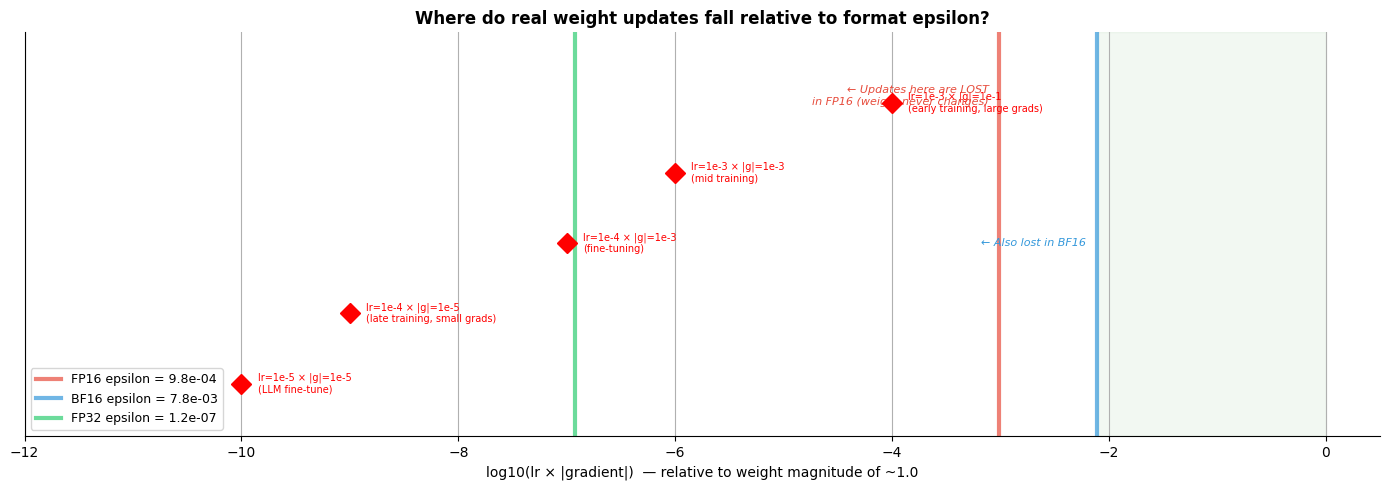

In [13]:
# Where do typical lr × grad products fall relative to epsilon boundaries?

fig, ax = plt.subplots(figsize=(14, 5))

# Epsilon values (minimum detectable relative update)
epsilons = {
    "FP16": float(torch.finfo(torch.float16).eps),
    "BF16": float(torch.finfo(torch.bfloat16).eps),
    "FP32": float(torch.finfo(torch.float32).eps),
}

# Typical lr × |grad| magnitudes in real training
typical_updates = {
    "lr=1e-3 × |g|=1e-1\n(early training, large grads)": 1e-4,
    "lr=1e-3 × |g|=1e-3\n(mid training)": 1e-6,
    "lr=1e-4 × |g|=1e-3\n(fine-tuning)": 1e-7,
    "lr=1e-4 × |g|=1e-5\n(late training, small grads)": 1e-9,
    "lr=1e-5 × |g|=1e-5\n(LLM fine-tune)": 1e-10,
}

y_pos = 0
colors_eps = {"FP16": "#e74c3c", "BF16": "#3498db", "FP32": "#2ecc71"}

# Draw epsilon boundaries as vertical lines
for name, eps in epsilons.items():
    ax.axvline(np.log10(eps), color=colors_eps[name], linewidth=3, alpha=0.7,
               label=f"{name} epsilon = {eps:.1e}")

# Shade the "safe update" zone (above all epsilons)
ax.axvspan(np.log10(max(epsilons.values())), 0, alpha=0.05, color="green")

# Draw typical update magnitudes as horizontal markers
y_updates = np.linspace(0.9, 0.1, len(typical_updates))
for (label, mag), y in zip(typical_updates.items(), y_updates):
    marker_color = "green"
    if mag < epsilons["FP16"]:
        marker_color = "red"
    elif mag < epsilons["BF16"]:
        marker_color = "orange"
    ax.plot(np.log10(mag), y, "D", color=marker_color, markersize=10, zorder=5)
    ax.text(np.log10(mag) + 0.15, y, label, fontsize=7, va="center", color=marker_color)

# Annotations
ax.text(np.log10(epsilons["FP16"]) - 0.1, 0.95,
        "← Updates here are LOST\n    in FP16 (weight never changes)",
        fontsize=8, color="#e74c3c", ha="right", va="top", fontstyle="italic")
ax.text(np.log10(epsilons["BF16"]) - 0.1, 0.5,
        "← Also lost in BF16",
        fontsize=8, color="#3498db", ha="right", va="center", fontstyle="italic")

ax.set_xlim(-12, 0.5)
ax.set_ylim(-0.05, 1.1)
ax.set_xlabel("log10(lr × |gradient|)  — relative to weight magnitude of ~1.0", fontsize=10)
ax.set_yticks([])
ax.set_title("Where do real weight updates fall relative to format epsilon?", fontsize=12, fontweight="bold")
ax.legend(loc="lower left", fontsize=9)
plt.tight_layout()

print("Interpretation:")
print("  - Green diamonds: update is large enough for ALL formats")
print("  - Orange diamonds: update works in FP32 and FP16, but NOT in BF16")
print("  - Red diamonds: update only works in FP32")
print()
print("This is why FP32 master weights are essential: the optimizer applies updates in FP32")
print("(where they're captured), then casts back to 16-bit for the next forward pass.")

### 1.1.9 TF32: the format you're using without knowing it

**TF32 (TensorFloat-32)** is an NVIDIA format introduced with the Ampere architecture (A100, 2020). It is *not* a storage format — you never create a TF32 tensor. Instead, Tensor Cores silently use TF32 arithmetic when you run FP32 matmuls on Ampere+ GPUs.

**Bit layout (19 bits total):**

| Component | Bits |
|---|---|
| Sign | 1 |
| Exponent | 8 (same as FP32) |
| Mantissa | 10 (same as FP16) |

This gives TF32 the **range of FP32** (exponent $[-126, 127]$, max $\sim 3.4 \times 10^{38}$) with the **precision of FP16** (10 mantissa bits, $\epsilon \approx 9.77 \times 10^{-4}$).

**Why this matters:**
- On Ampere+ GPUs, `torch.backends.cuda.matmul.allow_tf32` defaults to `True`.
- Your "FP32 baseline" is **secretly TF32** for all matmuls (Linear layers, attention projections, etc.).
- Non-matmul ops (LayerNorm, softmax, element-wise) still use full FP32 precision.
- This is actually a reasonable default: matmuls with FP32 accumulation tolerate reduced input precision well, and TF32 is ~8× faster than strict FP32 on Tensor Cores.

**The practical implication:** When you compare "FP32 vs AMP" on Ampere+ GPUs, you're really comparing "TF32 matmuls + FP32 everything else" vs "FP16/BF16 matmuls + FP32 sensitive ops." The gap is smaller than you might expect.

In [14]:
# TF32 demo: measure the precision impact of TF32 on matmul

if device.type == "cuda":
    M = 1024
    a = torch.randn(M, M, device=device, dtype=torch.float32)
    b = torch.randn(M, M, device=device, dtype=torch.float32)

    # Reference: strict FP32 (TF32 disabled)
    torch.backends.cuda.matmul.allow_tf32 = False
    ref = a @ b

    # TF32 enabled
    torch.backends.cuda.matmul.allow_tf32 = True
    out_tf32 = a @ b

    # FP64 reference for absolute ground truth
    ref64 = (a.double() @ b.double()).float()

    def _rel_err(x, ref):
        return float((x - ref).abs().mean() / (ref.abs().mean() + 1e-12))

    err_strict = _rel_err(ref, ref64)
    err_tf32 = _rel_err(out_tf32, ref64)

    print("Matmul precision comparison (1024x1024, vs FP64 reference):")
    print(f"  Strict FP32:  mean relative error = {err_strict:.2e}")
    print(f"  TF32 enabled: mean relative error = {err_tf32:.2e}")
    print(f"  TF32 / FP32 error ratio: {err_tf32 / max(err_strict, 1e-20):.1f}x")
    print()
    print(f"  TF32 matmul default: torch.backends.cuda.matmul.allow_tf32 = {torch.backends.cuda.matmul.allow_tf32}")
    print()
    print("Key insight: TF32 introduces ~1000x more error than strict FP32, but this is still")
    print("small enough (~1e-4 relative) that training is unaffected. The 8x Tensor Core speedup")
    print("makes this an excellent default tradeoff.")
    print()
    print("To disable TF32 for strict FP32 comparisons:")
    print("  torch.backends.cuda.matmul.allow_tf32 = False")
    print("  torch.backends.cudnn.allow_tf32 = False")
else:
    print("TF32 is an NVIDIA Ampere+ GPU feature. Not applicable on this device.")
    print("On CUDA Ampere+ GPUs, FP32 matmuls silently use TF32 (10-bit mantissa)")
    print("by default, giving ~8x speedup with ~FP16-level precision.")

Matmul precision comparison (1024x1024, vs FP64 reference):
  Strict FP32:  mean relative error = 2.51e-07
  TF32 enabled: mean relative error = 2.94e-04
  TF32 / FP32 error ratio: 1168.5x

  TF32 matmul default: torch.backends.cuda.matmul.allow_tf32 = True

Key insight: TF32 introduces ~1000x more error than strict FP32, but this is still
small enough (~1e-4 relative) that training is unaffected. The 8x Tensor Core speedup
makes this an excellent default tradeoff.

To disable TF32 for strict FP32 comparisons:
  torch.backends.cuda.matmul.allow_tf32 = False
  torch.backends.cudnn.allow_tf32 = False


### 1.1.10 Tensor Core mechanics: why mixed precision is fast

Modern GPU speedups from mixed precision come from **Tensor Cores** — specialized hardware units that perform tile-based matrix-multiply-accumulate (MMA) operations.

**How Tensor Cores work:**

1. **Tile-based:** Tensor Cores operate on small tiles (e.g., 16×16×16 for FP16 on Volta/Turing, 16×8×16 on Ampere). The GPU's warp scheduler feeds tiles from the input matrices to Tensor Cores.
2. **Mixed-precision accumulation:** Inputs are FP16/BF16 (or TF32/FP8), but the **accumulation** (partial sums) happens in **FP32**. This is why matmuls under autocast are both fast *and* numerically reasonable.
3. **Result:** $D = A \times B + C$ where $A$, $B$ are low-precision and $C$, $D$ are FP32 accumulators.

**Dimension alignment matters:**

Tensor Cores achieve maximum throughput when matrix dimensions are **multiples of 8** (for FP16/BF16) or **multiples of 16** (for FP8/INT8). Misaligned dimensions force the GPU to pad or fall back to slower CUDA cores.

This is why you'll see guidance like:
- Embedding dimensions: use multiples of 64 or 128
- Vocabulary size: pad to a multiple of 8
- Batch size: prefer multiples of 8

The code below demonstrates the speedup difference between aligned and misaligned dimensions.

In [15]:
# Tensor Core alignment benchmark: aligned vs misaligned dimensions

if device.type == "cuda":
    import torch.utils.benchmark as benchmark

    def bench_matmul(M, K, N, dtype, label):
        a = torch.randn(M, K, device=device, dtype=dtype)
        b = torch.randn(K, N, device=device, dtype=dtype)
        # Warmup
        for _ in range(10):
            _ = a @ b
        torch.cuda.synchronize()
        t = benchmark.Timer(
            stmt="a @ b",
            globals={"a": a, "b": b},
        )
        m = t.blocked_autorange(min_run_time=0.5)
        return m.median * 1e6  # microseconds

    rows = []
    for label, M, K, N in [
        ("Aligned (512×512×512)", 512, 512, 512),
        ("Misaligned (511×513×509)", 511, 513, 509),
        ("Aligned (1024×1024×1024)", 1024, 1024, 1024),
        ("Misaligned (1023×1025×1021)", 1023, 1025, 1021),
    ]:
        for dtype, dname in [(torch.float32, "FP32"), (torch.float16, "FP16"), (torch.bfloat16, "BF16")]:
            if not supports_dtype_on_device(dtype, device):
                continue
            us = bench_matmul(M, K, N, dtype, label)
            rows.append({"shape": label, "dtype": dname, "time_us": f"{us:.0f}"})

    df_tc = pd.DataFrame(rows)
    # Pivot for readability
    if len(df_tc) > 0:
        pivot = df_tc.pivot(index="shape", columns="dtype", values="time_us")
        print("Matmul time (microseconds) — aligned vs misaligned dimensions:")
        display(pivot)
        print()
        print("Aligned dimensions (multiples of 8) allow Tensor Cores to operate at full throughput.")
        print("Misaligned dimensions may cause padding overhead or fallback to slower CUDA cores.")
        print()
        print("Practical rule: make embedding dim, hidden dim, vocab size, and batch size multiples of 8.")
else:
    print("Tensor Core benchmarks require CUDA. Skipping on this device.")
    print()
    print("Key takeaways for Tensor Cores:")
    print("  1. They perform tile-based MMA (matrix-multiply-accumulate) on small blocks (e.g. 16x16)")
    print("  2. Inputs are FP16/BF16, accumulation is FP32 — this is why autocast matmuls are accurate")
    print("  3. Matrix dimensions should be multiples of 8 for optimal Tensor Core utilization")
    print("  4. Speedup is typically 2-8x over standard FP32 CUDA cores")

Matmul time (microseconds) — aligned vs misaligned dimensions:


dtype,BF16,FP16,FP32
shape,,,
Aligned (1024×1024×1024),19,22,32
Aligned (512×512×512),16,15,16
Misaligned (1023×1025×1021),77,51,57
Misaligned (511×513×509),20,20,19



Aligned dimensions (multiples of 8) allow Tensor Cores to operate at full throughput.
Misaligned dimensions may cause padding overhead or fallback to slower CUDA cores.

Practical rule: make embedding dim, hidden dim, vocab size, and batch size multiples of 8.


## 1.2 FP16 vs BF16 vs FP32: the complete numeric comparison

We generated the cheat sheet above. Here we dig deeper into what those numbers mean for training.

In [16]:
# Detailed format facts table

def _ulp_at_one_v2(dtype):
    try:
        one = torch.tensor(1.0, dtype=dtype)
        return float(torch.nextafter(one, one + one) - one)
    except Exception:
        return None

def _smallest_subnormal_v2(dtype):
    try:
        z = torch.tensor(0.0, dtype=dtype)
        o = torch.tensor(1.0, dtype=dtype)
        return float(torch.nextafter(z, o))
    except Exception:
        return None

def dtype_row(name, dtype, exp_bits, mant_bits, exp_min, exp_max):
    fi = torch.finfo(dtype)
    ulp1 = _ulp_at_one_v2(dtype)
    sub = _smallest_subnormal_v2(dtype)
    return {
        "dtype": name,
        "bits": fi.bits,
        "exp_bits": exp_bits,
        "mant_bits": mant_bits,
        "precision_bits": mant_bits + 1,
        "decimal_digits": round((mant_bits + 1) * math.log10(2), 2),
        "exp_range": f"[{exp_min}, {exp_max}]",
        "epsilon": f"{fi.eps:.2e}",
        "ulp(1.0)": f"{ulp1:.2e}" if ulp1 is not None else "n/a",
        "min_normal": f"{fi.tiny:.2e}",
        "min_subnormal": f"{sub:.2e}" if sub is not None else "n/a",
        "max_finite": f"{fi.max:.2e}",
    }

dtype_info = pd.DataFrame([
    *( [dtype_row("float8_e4m3fn", torch.float8_e4m3fn, 4, 3, -6, 7)] if hasattr(torch, "float8_e4m3fn") else [] ),
    *( [dtype_row("float8_e5m2", torch.float8_e5m2, 5, 2, -14, 15)] if hasattr(torch, "float8_e5m2") else [] ),
    dtype_row("float16", torch.float16, 5, 10, -14, 15),
    dtype_row("bfloat16", torch.bfloat16, 8, 7, -126, 127),
    dtype_row("float32", torch.float32, 8, 23, -126, 127),
    dtype_row("float64", torch.float64, 11, 52, -1022, 1023),
]).set_index("dtype")

display(dtype_info)

,bits,exp_bits,mant_bits,precision_bits,decimal_digits,exp_range,epsilon,ulp(1.0),min_normal,min_subnormal,max_finite
dtype,,,,,,,,,,,
float8_e4m3fn,8,4,3,4,1.20,"[-6, 7]",1.25e-01,n/a,1.56e-02,n/a,4.48e+02
float8_e5m2,8,5,2,3,0.90,"[-14, 15]",2.50e-01,n/a,6.10e-05,n/a,5.73e+04
float16,16,5,10,11,3.31,"[-14, 15]",9.77e-04,9.77e-04,6.10e-05,5.96e-08,6.55e+04
bfloat16,16,8,7,8,2.41,"[-126, 127]",7.81e-03,7.81e-03,1.18e-38,9.18e-41,3.39e+38
float32,32,8,23,24,7.22,"[-126, 127]",1.19e-07,1.19e-07,1.18e-38,1.40e-45,3.40e+38
float64,64,11,52,53,15.95,"[-1022, 1023]",2.22e-16,2.22e-16,2.23e-308,4.94e-324,1.80e+308


### Interpreting the table

**Precision** (how fine the tick marks are):
- FP64: ULP at 1.0 is ~2e-16. This is essentially "reference precision" for most deep learning numerics.
- FP32: ULP at 1.0 is ~$1.2 \times 10^{-7}$. Updates as small as $10^{-7}$ are captured.
- FP16: ULP at 1.0 is ~$9.8 \times 10^{-4}$. Updates smaller than $10^{-3}$ are lost.
- BF16: ULP at 1.0 is ~$7.8 \times 10^{-3}$. Updates smaller than $10^{-2}$ are lost. Even coarser than FP16!
- FP8: ULP at 1.0 is huge. FP8 is *not* a drop-in training dtype without extra scaling strategies and specialized kernels.

**Range** (how long the measuring tape is):
- FP16: smallest normal is ~$6 \times 10^{-5}$. Gradients below this become zero.
- BF16: smallest normal is ~$1.2 \times 10^{-38}$, same as FP32. Gradients essentially never underflow.
- FP8: range depends on format (E4M3 vs E5M2), but is far smaller than FP16/BF16/FP32.
- This is why **FP16 needs loss scaling** but **BF16 usually does not**.

### 1.2.1 TF32 — the hidden precision mode

*(See §1.1.9 above for a detailed TF32 deep dive with code demo.)*

On NVIDIA Ampere+ GPUs, FP32 matmuls can automatically use **TF32** internally:
- Same 8-bit exponent as FP32 (full range)
- But only 10 bits of mantissa (same as FP16 precision)
- Transparent: your code says `float32`, but Tensor Cores use TF32 for speed

This means your "FP32 baseline" on modern GPUs may actually be **TF32 precision** for matmuls. When comparing FP32 vs AMP, be aware of this hidden variable. You can control it with `torch.backends.cuda.matmul.allow_tf32`.

### 1.2.2 Why autocast targets matmul/linear first: FP32 accumulation

Deep learning is dominated by large matrix multiplications (GEMMs): `Linear`, attention projections, and MLPs.

On modern accelerators, these kernels typically:
- **multiply** in FP16/BF16 (or TF32/FP8, depending on mode)
- **accumulate** partial sums in **FP32**

This is a sweet spot:
- massive speedup (Tensor Cores / specialized units)
- much better numeric behavior than "pure FP16 accumulation"

Autocast heavily leans on this: it prefers to cast matmul-like ops down because they are both *fast* and comparatively *stable* (relative to softmax, layernorm, exp/log, large reductions).

In [17]:
# Matmul accuracy across dtypes (vs FP64 reference)

M = 256 if device.type != "cuda" else 512
a = torch.randn(M, M, device=device, dtype=torch.float32)
b = torch.randn(M, M, device=device, dtype=torch.float32)

ref = (a.double() @ b.double()).float()

def _err_stats(c, ref):
    c = c.float()
    abs_err = (c - ref).abs()
    rel_err = abs_err / (ref.abs() + 1e-6)
    return abs_err, rel_err

rows = []
for dt in [torch.float16, torch.bfloat16]:
    if not supports_dtype_on_device(dt, device):
        continue
    try:
        c_dt = a.to(dt) @ b.to(dt)
        abs_err, rel_err = _err_stats(c_dt, ref)
        rows.append({
            "dtype": str(dt).replace("torch.", ""),
            "matmul_mode": "native",
            "matmul_output_dtype": str(c_dt.dtype).replace("torch.", ""),
            "max_abs_err": f"{float(abs_err.max()):.2e}",
            "mean_abs_err": f"{float(abs_err.mean()):.2e}",
            "max_rel_err": f"{float(rel_err.max()):.2e}",
            "mean_rel_err": f"{float(rel_err.mean()):.2e}",
            "note": "",
        })
    except Exception as e:
        rows.append({
            "dtype": str(dt).replace("torch.", ""),
            "matmul_mode": "native",
            "matmul_output_dtype": "-",
            "max_abs_err": "-",
            "mean_abs_err": "-",
            "max_rel_err": "-",
            "mean_rel_err": "-",
            "note": f"matmul failed ({type(e).__name__})",
        })

# FP32: on CUDA this may be strict FP32 or TF32 depending on allow_tf32.
if supports_dtype_on_device(torch.float32, device):
    if device.type == "cuda":
        orig_tf32 = torch.backends.cuda.matmul.allow_tf32
        try:
            for allow in [False, True]:
                torch.backends.cuda.matmul.allow_tf32 = allow
                c = a @ b
                abs_err, rel_err = _err_stats(c, ref)
                rows.append({
                    "dtype": "float32",
                    "matmul_mode": "strict_fp32" if not allow else "tf32_allowed",
                    "matmul_output_dtype": str(c.dtype).replace("torch.", ""),
                    "max_abs_err": f"{float(abs_err.max()):.2e}",
                    "mean_abs_err": f"{float(abs_err.mean()):.2e}",
                    "max_rel_err": f"{float(rel_err.max()):.2e}",
                    "mean_rel_err": f"{float(rel_err.mean()):.2e}",
                    "note": "",
                })
        finally:
            torch.backends.cuda.matmul.allow_tf32 = orig_tf32
    else:
        c = a @ b
        abs_err, rel_err = _err_stats(c, ref)
        rows.append({
            "dtype": "float32",
            "matmul_mode": "native",
            "matmul_output_dtype": str(c.dtype).replace("torch.", ""),
            "max_abs_err": f"{float(abs_err.max()):.2e}",
            "mean_abs_err": f"{float(abs_err.mean()):.2e}",
            "max_rel_err": f"{float(rel_err.max()):.2e}",
            "mean_rel_err": f"{float(rel_err.mean()):.2e}",
            "note": "",
        })

display(pd.DataFrame(rows))
print("\nNotes:")
print("- Errors come from (1) input rounding to dt and (2) output rounding back to dt.")
print("- On CUDA, FP16/BF16 matmuls usually accumulate in FP32 internally, which helps stability.")
print("- On Ampere+ CUDA GPUs, float32 matmuls may run in TF32 mode when allow_tf32=True (10 mantissa bits).")

,dtype,matmul_mode,matmul_output_dtype,max_abs_err,mean_abs_err,max_rel_err,mean_rel_err,note
0,float16,native,float16,4.66e-02,6.39e-03,2.82e+01,2.08e-03,
1,bfloat16,native,bfloat16,3.92e-01,5.09e-02,2.25e+02,1.76e-02,
2,float32,strict_fp32,float32,3.43e-05,3.56e-06,4.77e-02,1.42e-06,
3,float32,tf32_allowed,float32,3.27e-02,5.28e-03,2.82e+01,2.04e-03,



Notes:
- Errors come from (1) input rounding to dt and (2) output rounding back to dt.
- On CUDA, FP16/BF16 matmuls usually accumulate in FP32 internally, which helps stability.
- On Ampere+ CUDA GPUs, float32 matmuls may run in TF32 mode when allow_tf32=True (10 mantissa bits).


## 1.3 The three numeric disasters that show up during training

### (A) Underflow — values become 0

- Common in **gradients**, especially late in training or in deep nets with tiny signals.
- Most harmful in **FP16** due to narrow exponent range (5 bits → min normal $\approx 6 \times 10^{-5}$).
- BF16 has the same exponent range as FP32, so underflow is rare.

### (B) Overflow — values become `inf`

- Common in **activations** (exponentials, attention logits) or badly-initialized models.
- FP16 max is only ~65,504. Easy to exceed.
- BF16 max is ~$3.4 \times 10^{38}$, same as FP32.

### (C) Accumulation / cancellation error

Even when values are in range, precision limits corrupt sums and products:
- Adding many small numbers to a large accumulator can lose the small contributions (same mechanism as the `1 + 1e-4` trap).
- For reductions (layernorm statistics, softmax normalization, large sums), frameworks often keep accumulation in FP32.

**Autocast** is partly about preventing A/B (range disasters), and partly about routing sensitive reductions so C doesn't destroy training.

### 1.3.0 Accumulation error, made concrete

**Accumulation error** is just "rounding happens at every add/multiply, and it compounds".

The simplest microscope is:

> start at a value (like 1.0), add a tiny increment many times, and see when the increment stops "counting".

This is the same mechanism behind:
- weight-update stagnation (updates below ULP get rounded away)
- instability in reductions (sums/means/variances done in low precision)

,dtype,final,expected,abs_err
0,float16,21.046875,21.000000,4.688e-02
1,bfloat16,20.625000,21.000000,3.750e-01
2,float32,21.000000,21.000000,0.000e+00
3,float64,21.000000,21.000000,0.000e+00



Interpretation:
- If the error curve flattens, your increments stopped affecting the accumulator.
- This is why AMP promotes certain reductions (like sum/prod and norm stats) to FP32.


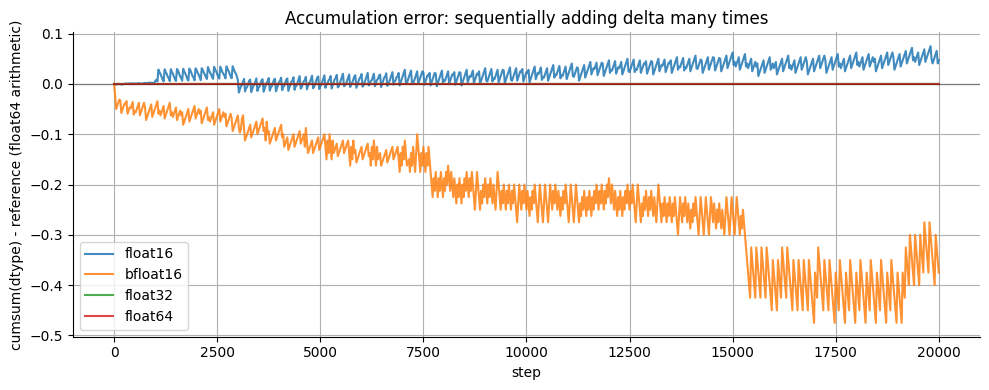

In [18]:
# Accumulation microscope: 1.0 + N * delta, computed sequentially in different dtypes

N = 20000
base = 1.0
delta = 1e-3

steps_i = torch.arange(N + 1, device=device, dtype=torch.int64)
expected64 = base + delta * steps_i.double()

rows = []
plt.figure(figsize=(10, 4))

every = max(1, (N + 1) // 800)

for dt in [torch.float16, torch.bfloat16, torch.float32, torch.float64]:
    if not supports_dtype_on_device(dt, device):
        continue
    deltas = torch.full((N,), delta, device=device, dtype=dt)
    start = torch.tensor([base], device=device, dtype=dt)
    cs = torch.cat([start, deltas]).cumsum(0)
    err = (cs.double() - expected64).cpu().numpy()

    label = str(dt).replace("torch.", "")
    plt.plot(steps_i.cpu().numpy()[::every], err[::every], label=label, alpha=0.85)

    final = float(cs[-1].cpu())
    rows.append({
        "dtype": label,
        "final": f"{final:.6f}",
        "expected": f"{float(expected64[-1].cpu()):.6f}",
        "abs_err": f"{abs(final - float(expected64[-1].cpu())):.3e}",
    })

plt.axhline(0.0, color="k", lw=1, alpha=0.3)
plt.title("Accumulation error: sequentially adding delta many times")
plt.xlabel("step")
plt.ylabel("cumsum(dtype) - reference (float64 arithmetic)")
plt.legend()
plt.tight_layout();

display(pd.DataFrame(rows))
print("\nInterpretation:")
print("- If the error curve flattens, your increments stopped affecting the accumulator.")
print("- This is why AMP promotes certain reductions (like sum/prod and norm stats) to FP32.")

In [19]:
# LayerNorm-like statistics are especially sensitive:
# mean/var of (large offset + small noise) is a classic cancellation problem.

M = 200_000
x = (torch.randn(M, device=device, dtype=torch.float32) * 0.1) + 1000.0

ref_mu = float(x.double().mean())
ref_var = float(((x.double() - ref_mu) ** 2).mean())

rows = []
for dt in [torch.float16, torch.bfloat16, torch.float32]:
    if not supports_dtype_on_device(dt, device):
        continue
    xd = x.to(dt)
    mu = xd.mean()
    var = ((xd - mu) ** 2).mean()
    rows.append({
        "dtype": str(dt).replace("torch.", ""),
        "mean": f"{float(mu):.6f}",
        "var": f"{float(var):.6e}",
        "mean_abs_err": f"{abs(float(mu) - ref_mu):.3e}",
        "var_rel_err": f"{abs(float(var) - ref_var) / (ref_var + 1e-30):.3e}",
    })

display(pd.DataFrame(rows))
print("\nThis is a simplified version of why LayerNorm/Softmax reductions are often forced to FP32 under autocast.")

,dtype,mean,var,mean_abs_err,var_rel_err
0,float16,1000.000000,3.070831e-03,5.678e-04,6.925e-01
1,bfloat16,1000.000000,0.000000e+00,5.678e-04,1.000e+00
2,float32,1000.000610,9.986290e-03,4.254e-05,1.502e-07



This is a simplified version of why LayerNorm/Softmax reductions are often forced to FP32 under autocast.


### 1.3.0a Why floating-point addition is NOT associative

In real-number math, addition is **associative**: $(a + b) + c = a + (b + c)$. In floating-point, this identity breaks because **rounding happens after every operation**.

This has a direct practical consequence: **the order in which you sum values affects the result**. When autocast forces reductions to FP32, one reason is this: the same sum computed in FP16 vs FP32 gives different answers because rounding error accumulates differently with fewer mantissa bits.

This also means **nondeterministic reduction order** (common in parallel GPU kernels) can cause run-to-run variance in low precision. Knowing this helps debug "my loss is slightly different every run" issues.

In [20]:
# Non-associativity of floating-point addition

# Choose three values where grouping matters
a_val, b_val, c_val = 1.0, 1e-4, -1.0

rows = []
for dt in [torch.float16, torch.bfloat16, torch.float32, torch.float64]:
    a = torch.tensor(a_val, dtype=dt)
    b = torch.tensor(b_val, dtype=dt)
    c = torch.tensor(c_val, dtype=dt)

    lhs = (a + b) + c      # (1 + 1e-4) + (-1)
    rhs = a + (b + c)       # 1 + (1e-4 + (-1))

    rows.append({
        "dtype": str(dt).replace("torch.", ""),
        "(a+b)+c": f"{float(lhs):.8e}",
        "a+(b+c)": f"{float(rhs):.8e}",
        "equal?": "YES" if float(lhs) == float(rhs) else "NO",
        "abs_diff": f"{abs(float(lhs) - float(rhs)):.2e}",
        "explanation": "",
    })

display(pd.DataFrame(rows))

print("\nWhat happened:")
print("  (a+b)+c: first computes 1.0 + 1e-4. In FP16, this is just 1.0 (addition trap).")
print("           Then 1.0 + (-1.0) = 0.0. The 1e-4 is completely lost.")
print("  a+(b+c): first computes 1e-4 + (-1.0) = -0.9999. No precision loss here.")
print("           Then 1.0 + (-0.9999) = 1e-4 (approximately). The value survives!")
print()
print("Practical lesson: summation order matters in low precision.")
print("This is one reason parallel GPU reductions can give different results than sequential ones,")
print("and why autocast promotes large reductions to FP32 where the effect is negligible.")

,dtype,(a+b)+c,a+(b+c),equal?,abs_diff,explanation
0,float16,0.00000000e+00,0.00000000e+00,YES,0.00e+00,
1,bfloat16,0.00000000e+00,0.00000000e+00,YES,0.00e+00,
2,float32,1.00016594e-04,1.00016594e-04,YES,0.00e+00,
3,float64,1.00000000e-04,1.00000000e-04,YES,0.00e+00,



What happened:
  (a+b)+c: first computes 1.0 + 1e-4. In FP16, this is just 1.0 (addition trap).
           Then 1.0 + (-1.0) = 0.0. The 1e-4 is completely lost.
  a+(b+c): first computes 1e-4 + (-1.0) = -0.9999. No precision loss here.
           Then 1.0 + (-0.9999) = 1e-4 (approximately). The value survives!

Practical lesson: summation order matters in low precision.
This is one reason parallel GPU reductions can give different results than sequential ones,
and why autocast promotes large reductions to FP32 where the effect is negligible.


### 1.3.0b Catastrophic cancellation: when subtraction destroys information

**Catastrophic cancellation** occurs when you subtract two nearly-equal numbers. The leading significant digits cancel, leaving only the noisy trailing digits. In low precision, there are fewer trailing digits to begin with, so the result can be almost entirely noise.

This is exactly what happens in **variance computation**: $\text{Var}(X) = E[X^2] - (E[X])^2$. If the mean is large relative to the standard deviation, both $E[X^2]$ and $(E[X])^2$ are large and nearly equal. The subtraction amplifies the rounding error in each term.

**Why and how the amplification works.** Every floating-point format stores a number with a fixed number of significant digits (the mantissa). FP32 gets ~7 decimal digits of precision, BF16 ~2.4, FP16 ~3.3. Anything beyond that is rounded away *before the subtraction ever happens*.

Consider our test case: data with mean $\mu = 10{,}000$ and $\sigma = 0.1$, so the true variance is $0.01$.

The naive formula needs to compute:

$$E[X^2] - (E[X])^2 \;\approx\; \underbrace{100{,}000{,}000.01}_{9 \text{ significant digits}} - \underbrace{100{,}000{,}000.00}_{9 \text{ significant digits}} = 0.01$$

Both terms are $\sim\!10^8$, but their difference is $\sim\!10^{-2}$ — a factor of $10^{10}$ smaller. To recover the answer you'd need **10** significant decimal digits. But FP32 only has ~7, and BF16 only has ~2.4. So by the time the subtraction happens, both operands have already been rounded *identically* in their leading digits, and the answer is built from whatever noise the rounding left in the trailing digits.

Concretely in **FP32** (~7 significant digits):
- $E[X^2]$ is stored as something like $1.000000_{\;?} \times 10^8$ — the $0.01$ part falls below the precision floor
- $(E[X])^2$ is stored as $1.000000_{\;?} \times 10^8$ — with its own, different rounding error
- Subtraction cancels all 7 leading digits, leaving a result that's entirely the *difference of two rounding errors*
- In the demo this gives $-8.0$ instead of $0.01$ — a **negative variance**, which is mathematically impossible. That minus sign is the hallmark of catastrophic cancellation.

In **BF16** (~2.4 significant digits): both terms round to *exactly the same value*, so the subtraction returns $0$.

In **FP16**: $10{,}000^2 = 10^8$ exceeds the FP16 max of $65{,}504$, so $E[X^2]$ overflows to `inf` and the result is `nan`.

This is the mechanical reason **LayerNorm and BatchNorm statistics need FP32** under autocast.

The "safe" formula sidesteps the problem by subtracting the mean *first*: $\text{Var}(X) = E[(X - \mu)^2]$. The centered values $(x_i - \mu)$ are $\sim\!0.1$, so their squares are $\sim\!0.01$ — numbers that comfortably fit in any format's precision. No large-minus-large subtraction ever occurs.

In [21]:
# Catastrophic cancellation in variance computation

def variance_naive(x):
    # Var(X) = E[X^2] - E[X]^2 -- catastrophic cancellation when E[X] >> std(X)
    return (x ** 2).mean() - x.mean() ** 2

def variance_safe(x):
    # Var(X) = E[(X - E[X])^2] -- avoids large-number subtraction
    return ((x - x.mean()) ** 2).mean()

# Test with offset data: mean ≈ 10000, std ≈ 0.1
set_seed(0)
x_fp32 = (torch.randn(50_000, device=device) * 0.1 + 10_000.0).float()
ref_var = float(variance_safe(x_fp32.double()))

rows = []
for dt in [torch.float16, torch.bfloat16, torch.float32]:
    if not supports_dtype_on_device(dt, device):
        continue
    x = x_fp32.to(dt)
    v_naive = float(variance_naive(x))
    v_safe = float(variance_safe(x))
    rows.append({
        "dtype": str(dt).replace("torch.", ""),
        "naive_var (E[X²]-E[X]²)": f"{v_naive:.6e}",
        "safe_var (E[(X-μ)²])": f"{v_safe:.6e}",
        "reference (FP64)": f"{ref_var:.6e}",
        "naive_rel_err": f"{abs(v_naive - ref_var) / (ref_var + 1e-30):.2e}",
        "safe_rel_err": f"{abs(v_safe - ref_var) / (ref_var + 1e-30):.2e}",
    })

display(pd.DataFrame(rows))

print("\nKey insight:")
print("  The naive formula (E[X²] - E[X]²) catastrophically cancels in FP16/BF16 because")
print("  E[X²] ≈ 1e8 and E[X]² ≈ 1e8, but their difference is only ~0.01.")
print("  Subtracting two huge nearly-equal numbers amplifies the rounding error.")
print()
print("  The safe formula (E[(X-μ)²]) subtracts the mean FIRST, so the squared values")
print("  are small (~0.01) and there's no cancellation.")
print()
print("  PyTorch's LayerNorm/BatchNorm use the safe formula internally — but even so,")
print("  autocast runs them in FP32 because the intermediate accumulations still benefit")
print("  from higher precision.")

,dtype,naive_var (E[X²]-E[X]²),safe_var (E[(X-μ)²]),reference (FP64),naive_rel_err,safe_rel_err
0,float16,nan,0.000000e+00,9.950029e-03,nan,1.00e+00
1,bfloat16,0.000000e+00,0.000000e+00,9.950029e-03,1.00e+00,1.00e+00
2,float32,-8.000000e+00,9.950038e-03,9.950029e-03,8.05e+02,8.87e-07



Key insight:
  The naive formula (E[X²] - E[X]²) catastrophically cancels in FP16/BF16 because
  E[X²] ≈ 1e8 and E[X]² ≈ 1e8, but their difference is only ~0.01.
  Subtracting two huge nearly-equal numbers amplifies the rounding error.

  The safe formula (E[(X-μ)²]) subtracts the mean FIRST, so the squared values
  are small (~0.01) and there's no cancellation.

  PyTorch's LayerNorm/BatchNorm use the safe formula internally — but even so,
  autocast runs them in FP32 because the intermediate accumulations still benefit
  from higher precision.


### 1.3.0c Kahan summation: the compensated-sum fix

If naive accumulation loses precision, can we do better without just using FP32?

**Kahan summation** (compensated summation) tracks a separate "error compensation" variable that captures the rounding error from each addition and feeds it back into the next step. It's like an accountant who keeps a running tally of all the pennies that got rounded off.

```
running_sum = 0.0
compensation = 0.0        # tracks accumulated rounding error

for x in values:
    y = x - compensation   # add back what was lost last time
    t = running_sum + y    # this addition might round
    compensation = (t - running_sum) - y   # what got lost this time
    running_sum = t
```

Some high-performance kernels internally use compensated summation when operating in low precision. Understanding it helps you appreciate what "accumulate in FP32" really means: it's the brute-force version of the same idea (just use more bits instead of being clever about rounding).

In [22]:
# Kahan summation vs naive summation in low precision

def kahan_sum(values, dtype):
    # Compensated summation in the given dtype.
    s = torch.tensor(0.0, dtype=dtype)
    c = torch.tensor(0.0, dtype=dtype)   # compensation for lost low-order bits
    for v in values:
        y = v.to(dtype) - c
        t = s + y
        c = (t - s) - y     # captures the rounding error
        s = t
    return float(s)

def naive_sum(values, dtype):
    # Simple sequential sum in the given dtype.
    s = torch.tensor(0.0, dtype=dtype)
    for v in values:
        s = s + v.to(dtype)
    return float(s)

# Sum 10,000 small values: 1e-3 each → expected total = 10.0
N = 10_000
values = [torch.tensor(1e-3)] * N
expected = 10.0

rows = []
for dt in [torch.float16, torch.bfloat16, torch.float32]:
    n_sum = naive_sum(values, dt)
    k_sum = kahan_sum(values, dt)
    rows.append({
        "dtype": str(dt).replace("torch.", ""),
        "naive_sum": f"{n_sum:.6f}",
        "kahan_sum": f"{k_sum:.6f}",
        "expected": f"{expected:.6f}",
        "naive_err": f"{abs(n_sum - expected):.4e}",
        "kahan_err": f"{abs(k_sum - expected):.4e}",
    })

display(pd.DataFrame(rows))

print("\nKahan summation recovers much of the precision lost by naive accumulation.")
print("In practice, 'accumulate in FP32' (what Tensor Cores and autocast do) achieves")
print("the same goal with less complexity: you just use a wider accumulator register.")
print("But Kahan summation shows that the problem IS solvable in low precision —")
print("it's just not worth the extra operations when FP32 accumulators are available.")

,dtype,naive_sum,kahan_sum,expected,naive_err,kahan_err
0,float16,4.000000,10.000000,10.000000,6.0000e+00,0.0000e+00
1,bfloat16,0.500000,9.937500,10.000000,9.5000e+00,6.2500e-02
2,float32,10.000411,10.000000,10.000000,4.1103e-04,0.0000e+00



Kahan summation recovers much of the precision lost by naive accumulation.
In practice, 'accumulate in FP32' (what Tensor Cores and autocast do) achieves
the same goal with less complexity: you just use a wider accumulator register.
But Kahan summation shows that the problem IS solvable in low precision —
it's just not worth the extra operations when FP32 accumulators are available.


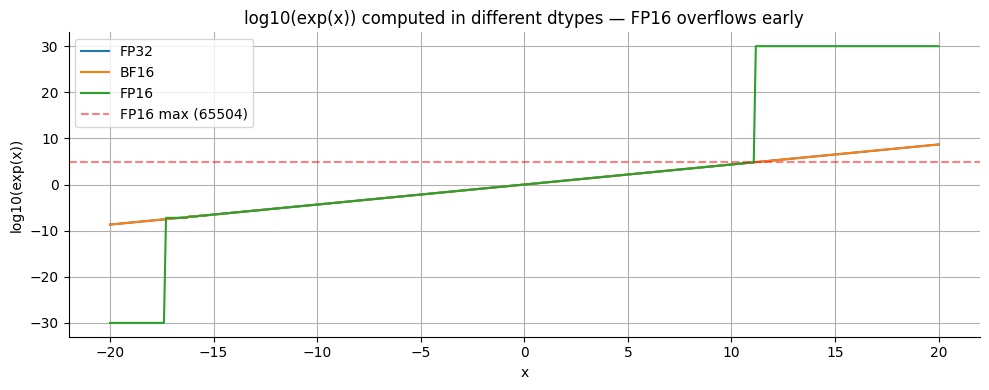

In [23]:
# Where does exp() overflow by dtype?

x = torch.linspace(-20, 20, 400, device=device)

def safe_exp(x, dtype):
    return torch.exp(x.to(dtype)).to(torch.float32).cpu().numpy()

plt.figure(figsize=(10, 4))
for dt, label in [(torch.float32, "FP32"), (torch.bfloat16, "BF16")]:
    y = safe_exp(x, dt)
    plt.plot(x.cpu().numpy(), np.log10(np.clip(y, 1e-30, 1e30)), label=label)

if device.type == "cuda":
    y16 = safe_exp(x, torch.float16)
    plt.plot(x.cpu().numpy(), np.log10(np.clip(y16, 1e-30, 1e30)), label="FP16")

plt.axhline(np.log10(65504), color="r", linestyle="--", alpha=0.5, label="FP16 max (65504)")
plt.title("log10(exp(x)) computed in different dtypes — FP16 overflows early")
plt.xlabel("x")
plt.ylabel("log10(exp(x))")
plt.legend()
plt.tight_layout();

### 1.3.1 Loss functions are "log-sum-exp machines" (and dtype matters)

Many deep learning losses contain exponentials and logs. A classic example:

$$\log(1 + e^x) \quad \text{(softplus)}$$

- The naive formula overflows quickly in FP16 (for $x > 11$, $e^x > 65504$).
- Stable implementations (e.g., `F.softplus`) avoid overflow by rewriting the expression.

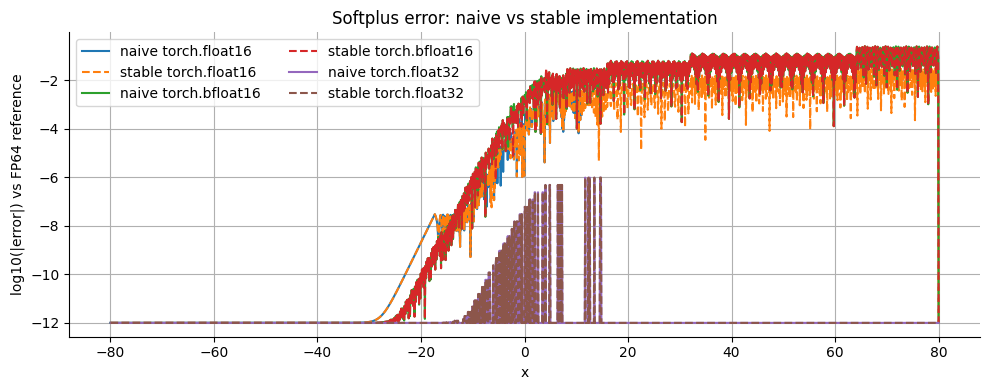

In [24]:
# Naive vs stable softplus across dtypes

def naive_softplus(x):
    return torch.log1p(torch.exp(x))

x = torch.linspace(-80, 80, 2000, device=device)
ref = F.softplus(x.double()).float()  # high-precision reference

plt.figure(figsize=(10, 4))
for dt in [torch.float16, torch.bfloat16, torch.float32]:
    if device.type == "cpu" and dt is torch.float16:
        continue
    y_naive = naive_softplus(x.to(dt)).float()
    y_stable = F.softplus(x.to(dt)).float()
    err_naive = (y_naive - ref).abs().cpu().numpy()
    err_stable = (y_stable - ref).abs().cpu().numpy()
    plt.plot(x.cpu().numpy(), np.log10(err_naive + 1e-12), label=f"naive {dt}")
    plt.plot(x.cpu().numpy(), np.log10(err_stable + 1e-12), ls="--", label=f"stable {dt}")

plt.title("Softplus error: naive vs stable implementation")
plt.xlabel("x")
plt.ylabel("log10(|error|) vs FP64 reference")
plt.legend(ncols=2)
plt.tight_layout();

### 1.3.2 Softmax: the overflow trap and the stability rewrite

Softmax is everywhere in transformers (attention). Naive softmax:

$$\text{softmax}(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

This can overflow in low precision because $e^x$ explodes quickly. The stable rewrite subtracts the max:

$$\text{softmax}(x) = \text{softmax}(x - \max(x))$$

PyTorch's `F.softmax` uses a stable implementation. Let's verify.

In [25]:
# Naive vs stable softmax

def naive_softmax(x, dim=-1):
    ex = torch.exp(x)
    return ex / ex.sum(dim=dim, keepdim=True)

logits = torch.tensor([0.0, 20.0, 40.0, 80.0], device=device)
ref = F.softmax(logits.double(), dim=0).float()

rows = []
for dt in [torch.float16, torch.bfloat16, torch.float32]:
    if device.type == "cpu" and dt is torch.float16:
        continue
    x = logits.to(dt)
    try:
        naive = naive_softmax(x, dim=0).float()
        naive_ok = bool(torch.isfinite(naive).all().item())
    except Exception:
        naive = torch.full_like(ref, float("nan"))
        naive_ok = False
    stable = F.softmax(x, dim=0).float()
    stable_ok = bool(torch.isfinite(stable).all().item())
    rows.append({
        "dtype": str(dt),
        "naive_finite": naive_ok,
        "stable_finite": stable_ok,
        "max_abs_err(stable vs ref)": f"{float((stable - ref).abs().max()):.2e}",
    })

pd.DataFrame(rows)

,dtype,naive_finite,stable_finite,max_abs_err(stable vs ref)
0,torch.float16,False,True,4.25e-18
1,torch.bfloat16,True,True,7.14e-21
2,torch.float32,True,True,1.43e-42


### 1.3.3 Cross-entropy: the loss function that motivates half of autocast's policy

Cross-entropy is the workhorse loss for classification and language modeling. Its internals combine the two most dangerous operations we've seen:

$$\text{CE}(x, y) = -\log\left(\frac{e^{x_y}}{\sum_j e^{x_j}}\right) = -x_y + \log\sum_j e^{x_j}$$

The $\log\sum\exp$ term involves:
- **Exponentiation** (overflow risk: $e^{11} > 65504$, the FP16 max)
- **Summation over a large vocabulary** (accumulation risk: summing 50,000+ terms in FP16)
- **Logarithm** (underflow risk: $\log(0)$ if softmax probabilities flush to zero)

PyTorch's `F.cross_entropy` uses the **log-sum-exp trick** (subtract max before exponentiating), making it numerically stable. Autocast forces it to FP32 because even the stable version benefits from FP32 accumulation over large vocabularies.

Let's see what happens at different logit scales — simulating early training (small logits) vs. late training or badly-initialized models (large logits).

In [26]:
# Cross-entropy loss: naive vs stable implementation across dtypes and logit scales

set_seed(0)
seq_len_ce = 128
vocab_ce = 1000
target_ce = torch.randint(0, vocab_ce, (seq_len_ce,), device=device)

logit_scales = [1.0, 5.0, 10.0, 20.0, 50.0]

rows = []
for scale in logit_scales:
    logits_base = torch.randn(seq_len_ce, vocab_ce, device=device) * scale

    for dt in [torch.float16, torch.bfloat16, torch.float32]:
        if not supports_dtype_on_device(dt, device):
            continue
        logits_dt = logits_base.to(dt)

        # Naive: manual log(softmax(x)) — no max subtraction
        try:
            ex = torch.exp(logits_dt)
            sm = ex / ex.sum(dim=-1, keepdim=True)
            naive_loss = float(-torch.log(sm[torch.arange(seq_len_ce, device=device), target_ce] + 1e-12).mean())
            naive_ok = math.isfinite(naive_loss)
        except Exception:
            naive_loss = float("inf")
            naive_ok = False

        # Stable: F.cross_entropy (always runs computation in >= the input dtype)
        ref_loss = float(F.cross_entropy(logits_base.float(), target_ce))
        try:
            stable_loss = float(F.cross_entropy(logits_dt.float(), target_ce))
        except Exception:
            stable_loss = float("nan")

        rows.append({
            "logit_scale": scale,
            "dtype": str(dt).replace("torch.", ""),
            "naive_CE": f"{naive_loss:.4f}" if naive_ok else "inf/nan",
            "stable_CE (F.cross_entropy)": f"{stable_loss:.4f}",
            "naive_finite?": "YES" if naive_ok else "NO",
            "stable_error_vs_fp32": f"{abs(stable_loss - ref_loss):.2e}",
        })

display(pd.DataFrame(rows))

print("\nKey insights:")
print("  - At scale>=10, naive cross-entropy in FP16 produces inf (exp overflows)")
print("  - F.cross_entropy uses log-sum-exp with max subtraction → always finite")
print("  - Autocast forces cross_entropy to FP32 because the log-sum-exp reduction")
print("    over large vocabularies (50k+ for LLMs) benefits from FP32 accumulation")
print("  - This is why you should NEVER compute loss outside the autocast context")
print("    and then manually cast — let autocast handle the precision routing")

,logit_scale,dtype,naive_CE,stable_CE (F.cross_entropy),naive_finite?,stable_error_vs_fp32
0,1.0,float16,7.5273,7.5258,YES,4.77e-06
1,1.0,bfloat16,7.5312,7.5259,YES,5.05e-05
2,1.0,float32,7.5258,7.5258,YES,0.00e+00
3,5.0,float16,inf/nan,16.7415,NO,1.51e-04
4,5.0,bfloat16,16.6250,16.7405,YES,8.22e-04
5,5.0,float32,16.5948,16.7413,YES,0.00e+00
6,10.0,float16,inf/nan,33.9136,NO,2.67e-04
7,10.0,bfloat16,25.7500,33.9147,YES,7.55e-04
8,10.0,float32,25.7859,33.9139,YES,0.00e+00
9,20.0,float16,inf/nan,66.3714,NO,3.36e-04



Key insights:
  - At scale>=10, naive cross-entropy in FP16 produces inf (exp overflows)
  - F.cross_entropy uses log-sum-exp with max subtraction → always finite
  - Autocast forces cross_entropy to FP32 because the log-sum-exp reduction
    over large vocabularies (50k+ for LLMs) benefits from FP32 accumulation
  - This is why you should NEVER compute loss outside the autocast context
    and then manually cast — let autocast handle the precision routing


## 1.4 What AMP actually is

In PyTorch, AMP is two complementary tools:

1. **`autocast`** (forward + loss)
   - A context manager that applies a **per-operation dtype policy**.
   - It *temporarily* casts inputs/weights for each operation. It does **not** permanently change model parameters.
   - Matmuls/linear → lower precision. Softmax/layernorm/losses → FP32.

2. **`GradScaler`** (backward + optimizer step)
   - Primarily for **FP16 training** (BF16 usually doesn't need it).
   - Multiplies loss by a scale factor $S$ before backward → gradients are $S\times$ larger → fewer underflow to zero.
   - Before optimizer step, divides gradients by $S$. If overflow is detected (`inf`/`nan`), skips the step and reduces $S$.

**Clean mental model:**
- `autocast` protects you from **bad forward dtypes**.
- `GradScaler` protects you from **bad backward magnitudes** (FP16 gradient underflow).

## 1.5 The canonical AMP training loop (four conceptual changes)

Start with FP32 training:
```python
optimizer.zero_grad(set_to_none=True)
logits = model(x)
loss = loss_fn(logits, y)
loss.backward()
optimizer.step()
```

AMP adds four things:
```python
scaler = GradScaler()

optimizer.zero_grad(set_to_none=True)
with autocast(device_type="cuda", dtype=torch.float16):   # 1. wrap forward + loss
    logits = model(x)
    loss = loss_fn(logits, y)

scaler.scale(loss).backward()    # 2. scale loss before backward
scaler.step(optimizer)           # 3. unscale + check for inf/nan + step
scaler.update()                  # 4. adjust scale factor
```

That's the "small code change" people talk about. But the *reason* it works is the theory above.

## 1.6 Master weights and optimizer state (why "just casting the model" is not the same)

There are **three** numeric objects in training that matter:

1. **Parameters** (weights) — used in forward/backward
2. **Gradients** — produced by backward
3. **Optimizer state** (e.g., Adam's first and second moment estimates $m_t, v_t$) — long-lived accumulators

A classic mixed precision recipe:
- Keep a **master copy of weights in FP32**.
- Do forward/backward in FP16/BF16 where safe.
- Maintain optimizer state (Adam moments) in FP32.

**Why FP32 master weights?**

Because 16-bit formats have coarse spacing. A small update $\Delta w = \text{lr} \times \text{grad}$ can be *below the ULP* at the magnitude of $w$, so the weight never changes. We showed this in the `1 + 1e-4` demo above.

Over many steps, these tiny updates *accumulate* in FP32 and eventually become large enough to appear in the 16-bit copy. This is the key insight from the Micikevicius et al. (2017) paper.

**Why FP32 optimizer state?**

Adam's moments are exponential moving averages. They accumulate information over the entire training run. Even small rounding errors compound over thousands of steps. Keeping moments in FP32 prevents this drift.

**Memory implication:**

Mixed precision doesn't eliminate FP32 — it just limits FP32 to parameters + optimizer state (which is fixed-size), while saving on activations (which scale with batch size and sequence length).

## 1.7 Autocast is an operator policy (not a global cast)

Autocast does **not** "turn the whole model into FP16". Instead it applies a per-operation policy:

| Policy | Operations | Rationale |
|---|---|---|
| **Lower precision** (FP16/BF16) | `linear`, `matmul`, `mm`, `bmm`, convolutions | Compute-bound → Tensor Core speedup |
| **Force FP32** | `softmax`, `layer_norm`, `log_softmax`, `mse_loss`, `cross_entropy`, `sum`, `prod`, `exp`, `log`, ... | Numerically sensitive: overflow/underflow/accumulation risk |
| **Promote to widest** | Binary ops when inputs differ | If one input is FP32, the op runs in FP32 |
| **Pass-through** | `relu`, `dropout`, `max`, `min`, `mean`, ... | Element-wise, no numeric risk; output matches input dtype |

The exact policy is PyTorch-version-dependent. In Section 3 we will probe it empirically on your machine.

## Section 1 summary

| Concept | Key takeaway |
|---|---|
| **FP16** | Better precision than BF16, but narrow range → needs loss scaling and careful op policies |
| **BF16** | FP32-like range → often trains without scaling, but coarse precision → reductions need care |
| **TF32** | Your "FP32 baseline" on Ampere+ GPUs may secretly be TF32 (10-bit mantissa) for matmuls |
| **AMP** | `autocast` (forward op policy) + `GradScaler` (backward magnitude control) |
| **Master weights** | Keep FP32 copy for updates; prevents stagnation from ULP rounding |
| **Optimizer state** | Keep in FP32; long-horizon accumulation is precision-sensitive |

# Section 2 — What the literature says

This section is intentionally *written*: the point is to build a paper-and-doc-driven mental model that you can carry into real training code.

No experiments here — only explanations. Think of this section as: "what each source contributes, and how it maps to PyTorch AMP."

## 2.0 A reading map

| Source | What it gives you | Maps to |
|---|---|---|
| Gupta et al. (2015) | Why limited precision can still train; stochastic rounding + scaling intuition | Section 1.3 (rounding/accumulation), Section 3 debugging |
| Micikevicius et al. (2017) | The canonical mixed precision recipe (master weights + loss scaling) | Sections 1.4–1.6, scaling experiments |
| Kalamkar et al. (2019) | BF16 bit-level analysis, proof that BF16 avoids FP16's underflow | Section 1.2, BF16 training runs |
| NVIDIA mixed precision guidance | Engineering intuition + failure modes | Underflow/overflow + "sensitive ops in FP32" |
| PyTorch `torch.amp` docs | The actual API + gotchas | `autocast` + `GradScaler` loops in Section 3 |
| PyTorch autocast op reference | *The* per-op policy | Probed empirically in Section 3.2 |
| PyTorch AMP examples page | Exact operational order for edge cases (accumulation, penalty, multi-optimizer) | Section 2.9.1, Section 3.10 |
| Rajbhandari et al. (2020) — ZeRO | Memory breakdown of mixed-precision training at scale | Optimizer state precision, Section 2.6 |
| Distributed training docs (FSDP/ZeRO/DeepSpeed) | Where dtypes live in large systems | Section 2.7 |
| FP8 literature (e.g., NVIDIA) | Why FP8 needs scaling (E4M3 vs E5M2) + where it fits vs AMP | Section 1 tables, Section 3 practical guidance |
| PyTorch float8 + FSDP2 blogs/tutorials | What actually closes the convergence gap at scale (rowwise scaling, float8 all-gather) | Section 2.11.1 |
| NVIDIA Transformer Engine primer | Blackwell-era microscaling formats (MXFP8/NVFP4) and stochastic rounding direction | Section 2.11.2 |
| Dettmers et al. (8-bit optimizers) | Optimizer-state precision as the next bottleneck after AMP | Section 2.6 memory discussion |

If you only read one thing: read the Micikevicius paper, then read the PyTorch autocast op reference.

## 2.1 Micikevicius et al. (2017): *Mixed Precision Training*

> arXiv:1710.03740 — ICLR 2018

This is the foundational paper for everything in this notebook. It introduced the three-part recipe that all modern AMP implementations are based on.

**The problem:** FP16 arithmetic is fast (2–8x throughput on Tensor Cores) and memory-efficient (half the bytes), but naively training in FP16 breaks. Models either diverge, produce NaN losses, or silently stagnate. The paper identifies three distinct failure modes:

1. **Weight update stagnation.** When a weight $w$ is stored in FP16, the update $\Delta w = \eta \cdot g$ can be smaller than the ULP (unit in the last place) at $|w|$. The update is rounded away and the weight never changes. The paper's solution: maintain an FP32 "master copy" of all parameters. Forward and backward compute use the FP16 cast, but the actual parameter update happens in FP32 where the precision is sufficient to register small changes. The updated FP32 value is then cast back to FP16 for the next forward pass.

2. **Gradient underflow.** Even with FP32 master weights, gradients themselves are computed in FP16 during the backward pass. FP16's smallest normalized number is approximately $6 \times 10^{-5}$. The paper's analysis of gradient histograms across several production models (image classifiers, speech models, generative models) shows that a significant fraction of gradient values fall below this threshold. Once they underflow to zero, the update signal is lost. The solution: **loss scaling**. Multiply the scalar loss by a large constant $S$ before calling `backward()`. Since backpropagation is a chain of multiplications, every gradient in the network is scaled up by $S$. After backward, divide gradients by $S$ before the optimizer step. If $S$ is chosen well, gradients that would have underflowed are now safely within FP16's representable range, and the division by $S$ restores correct magnitudes. The paper demonstrates that a fixed $S$ works for many models, but notes that $S$ too large can cause gradient *overflow*. This motivates **dynamic loss scaling**: start with a large $S$, and if `inf`/`nan` gradients are detected, skip the update and reduce $S$. If training is stable, periodically increase $S$ to maximize headroom.

3. **Accumulation error in reductions.** Large dot products and reductions (e.g., summing thousands of values) accumulate rounding errors that compound in FP16. The paper recommends performing these accumulations in FP32, even when the operands are FP16. Modern Tensor Cores implement this: they accept FP16 inputs but accumulate in FP32.

**What to remember:** AMP is not a single trick. It is the *combination* of (a) per-op precision policies, (b) loss scaling, and (c) FP32 master weights/optimizer state. Removing any one of these can cause training to fail.

## 2.2 Kalamkar et al. (2019): *A Study of BFLOAT16 for Deep Learning Training*

> arXiv:1905.12322

This paper provides the empirical and theoretical justification for BF16 as a training format.

**The key insight** is architectural: BF16 uses **8 exponent bits** (same as FP32), giving it the same dynamic range — roughly $10^{-38}$ to $10^{38}$. This means BF16 can represent the same extreme magnitudes as FP32. The gradient underflow problem that plagues FP16 (5-bit exponent → range only $10^{-5}$ to $6.5 \times 10^4$) essentially does not exist for BF16.

**The tradeoff:** BF16 sacrifices mantissa bits (7 vs FP16's 10 vs FP32's 23). This means worse *precision* per individual value. But the paper demonstrates empirically that deep neural networks are remarkably robust to precision loss — they are much more sensitive to *range* loss. Training with BF16 across a variety of models (ResNets, Transformers, LSTMs) converges to the same final accuracy as FP32, often without any loss scaling at all.

**Conversion simplicity:** Since BF16 and FP32 share the same exponent field, conversion is trivial: truncate (or round) the bottom 16 mantissa bits. FP32 → FP16 conversion is harder because the exponent field must also be narrowed, risking overflow or underflow in the conversion itself.

**Practical implication for AMP:** BF16 autocast is often a "drop-in" replacement that doesn't require a `GradScaler`. This is explicitly confirmed by modern frameworks: DeepSpeed documentation states, "Training with bfloat16 does not require loss scaling."

**When BF16 can still struggle:** Precision-sensitive accumulations (layernorm statistics, attention score normalization, large batch reductions) can still degrade with BF16's 7-bit mantissa. This is why autocast routes these operations to FP32 even in BF16 mode.

## 2.3 NVIDIA mixed precision guidance (the engineering perspective)

NVIDIA's developer blog and documentation provide the practitioner's view of mixed precision. The key engineering decomposition:

1. **Tensor Core compute** wants FP16/BF16 inputs. Modern GPUs (Volta+) have dedicated matrix-multiply-accumulate units that operate on 16-bit inputs with FP32 accumulation. These deliver 2–8$\times$ the throughput of FP32 CUDA cores for matmuls, which dominate deep learning compute.

2. **Dimension alignment matters.** Tensor Cores process tiles of fixed size (typically 8 or 16 elements). If your tensor dimensions aren't multiples of 8, you either waste hardware or fall back to slower code paths. This is a practical detail that affects whether you actually see the theoretical speedup.

3. **Memory bandwidth matters as much as compute.** 16-bit formats halve the bytes transferred between GPU memory (HBM) and compute cores (SMs). For memory-bandwidth-bound models (which many transformer models are at inference time), this alone can yield significant speedup even without Tensor Core benefits.

4. **Some ops are numerically sensitive.** NVIDIA's guidance identifies the same ops that PyTorch's autocast routes to FP32: exponentials, logs, softmax, normalization statistics, and large reductions. The rationale is the same: overflow/underflow risk and accumulation error.

The practical outcome is the "few lines of code" AMP recipe. But the engineering reason it works is the numeric analysis in the theory section above.

## 2.4 BF16: "FP32 range, fewer bits of precision"

BF16 was originally designed for Google's TPUs. The design goal was explicit: make it possible to train neural networks in 16-bit formats *without* the underflow problems of FP16.

**The design decision:** Given 16 bits, how should you split them between exponent and mantissa?

- FP16 (IEEE): 5 exponent + 10 mantissa → good precision, but range only $[6 \times 10^{-5}, 6.5 \times 10^4]$.
- BF16 (Google/Intel): 8 exponent + 7 mantissa → FP32-like range $[10^{-38}, 3.4 \times 10^{38}]$, coarser precision.

For training, range wins. Gradients span many orders of magnitude, and losing any of them to underflow is worse than representing them imprecisely. Networks are fundamentally robust to noise (they're trained with stochastic gradient descent after all), but they cannot learn from zero gradients.

**In practice, for many transformer trainings on modern GPUs:**
- BF16 autocast is "drop-in" without loss scaling.
- FP16 autocast typically needs a `GradScaler`.
- Both still benefit from FP32 master weights and FP32 optimizer state.

## 2.5 PyTorch AMP docs: the operator policy is the decoder ring

A common mistake is to treat autocast like a global switch ("my model is now FP16"). But autocast is really a **per-operation dispatch table**:

- Some ops are eligible for lower precision (FP16/BF16). These are the compute-heavy ops where Tensor Cores give speedup.
- Some ops are forced to FP32. These are the numerically sensitive ops where lower precision would cause training failures.
- Some ops promote to the widest input type. These are binary operations where mixed-dtype inputs would be ambiguous.
- Unlisted ops run in whatever dtype they receive (pass-through).

**The key documentation page** is the [PyTorch Autocast Op Reference](https://pytorch.org/docs/stable/amp.html#autocast-op-reference). It lists every CUDA op and its autocast behavior. This is the authoritative answer to "why did this op run in FP32?" — faster and more reliable than any blog post.

**A common debugging pattern:** when AMP training fails, the first thing to check is which ops are running in which dtype. The dtype hooks we build in Section 3 make this visible.

## 2.6 Rajbhandari et al. (2020): ZeRO and optimizer state precision

> arXiv:1910.02054 — *ZeRO: Memory Optimizations Toward Training Trillion Parameter Models*

While ZeRO is primarily about distributed training, its memory analysis (Section 2) is essential for understanding where mixed precision fits.

**The memory breakdown for a model with $\Psi$ parameters trained with Adam in mixed precision:**

| Component | Dtype | Bytes per parameter |
|---|---|---|
| FP16 parameters (forward/backward) | FP16 | 2 |
| FP16 gradients | FP16 | 2 |
| FP32 master weights | FP32 | 4 |
| FP32 Adam first moment ($m$) | FP32 | 4 |
| FP32 Adam second moment ($v$) | FP32 | 4 |
| **Total** | | **16 bytes/param** |

For a 7B parameter model: $7 \times 10^9 \times 16 = 112$ GB just for parameters + optimizer state — before any activations.

**Key insight:** Mixed precision doesn't eliminate FP32 from the system. It moves FP32 to where it's needed (optimizer state, master weights) and uses 16-bit where it's safe (activations, compute). The memory savings come primarily from activations (which scale with batch size and sequence length), not from the fixed-size parameter/optimizer memory.

**Practical takeaway:** "AMP" in a distributed stack is not only about autocast during forward/backward. It is about **where each tensor lives and in what dtype** across the entire training loop: parameters, gradients, optimizer state, communication buffers, and activation checkpoints.

## 2.7 LLM training stacks (FSDP / ZeRO / DeepSpeed): where precision choices multiply

At LLM scale, training systems shard parameters, gradients, and optimizer state across multiple GPUs. Mixed precision gets more complicated because dtype decisions affect:

- **Parameter storage:** "working" params in BF16/FP16 for forward/backward; FP32 master copy for updates.
- **Gradient communication:** All-reduce operations can accumulate rounding errors. Some stacks reduce in FP32 for stability, others use BF16 + gradient compression.
- **Optimizer state:** Typically FP32 (Adam moments need high precision over long training). Some frameworks offer FP16 optimizer states as a memory optimization, but this trades stability for memory.
- **Activation checkpointing:** Recomputed activations use the same autocast policy as the original forward pass, but the checkpointing mechanism itself must preserve dtypes correctly.

**FSDP mixed precision** (PyTorch): lets you separately control `param_dtype` (for sharded parameters), `reduce_dtype` (for gradient all-reduce), and `buffer_dtype`. FP16 + scaler or BF16 without scaler.

**DeepSpeed ZeRO:** explicit config knobs. `fp16.loss_scale = 0` enables dynamic loss scaling; `bf16.enabled = true` with no loss scaling.

**The practical lesson:** When debugging AMP issues in distributed training, the dtype of every tensor transfer (parameter broadcast, gradient reduce, optimizer state scatter/gather) is a potential source of numeric problems. This is well beyond the scope of a single `autocast` context manager.

## 2.8 How to think about the autocast policy (conceptual categories)

Autocast decisions fall into a few conceptual buckets. These aren't arbitrary — each traces back to a specific numeric risk:

**1. Lower precision eligible (matmul-like ops)**

These are the ops where Tensor Cores provide speedup and numeric risk is low. The key property: these operations multiply pairs of values and accumulate in FP32 (on Tensor Cores), so the inputs can be 16-bit without precision loss in the output.

**2. Force FP32 (numerically sensitive ops)**

Two sub-categories:
- **Overflow/underflow risk:** `exp`, `log`, `softmax`, `log_softmax`. These can produce extreme magnitudes.
- **Accumulation risk:** `sum`, `prod`, `layer_norm`, `batch_norm`, `cross_entropy`, `mse_loss`. These reduce many values and small rounding errors compound.

**3. Promote to widest (binary ops with mixed inputs)**

If you add a BF16 tensor to an FP32 tensor, the result is FP32. This prevents silent precision loss when autocast and non-autocast regions interact.

**4. Pass-through (element-wise, no numeric risk)**

`relu`, `sigmoid`, `tanh`, `dropout`, `max`, `min`, `mean`. These just transform individual values without extreme magnitudes or accumulation. Whatever goes in comes out.

**Practitioner's two rules:**
- If an op creates very large/small magnitudes ($e^x$, $\log x$, softmax), it needs FP32.
- If an op reduces many values ($\sum$, variance, cross-entropy), it needs FP32 accumulation.

## 2.9 Dynamic loss scaling: what `GradScaler` is doing

Loss scaling multiplies the scalar loss by a factor $S$ before calling `backward()`.

Since backpropagation is linear (gradients are proportional to the loss), every gradient in the network is multiplied by $S$. This shifts the entire gradient distribution toward larger magnitudes, rescuing values that would have underflowed to zero in FP16.

**The protocol:**

1. Compute loss normally under autocast.
2. Multiply loss by $S$ and call `backward()`.
3. Before the optimizer step, **unscale** all gradients by dividing by $S$.
4. Check for `inf`/`nan` in gradients:
   - If found: **skip** the optimizer step, reduce $S$ (usually halve it).
   - If not found: proceed with the step. Periodically increase $S$ (e.g., double it every $N$ successful steps) to maximize headroom.

**Why it's safe:** scaling and unscaling cancel out exactly if no overflow occurs. The optimizer sees the same gradients it would have without scaling.

**Critical detail:** gradient clipping must happen **after** unscaling. PyTorch's `scaler.unscale_(optimizer)` does the unscale explicitly; `scaler.step(optimizer)` then checks for inf/nan before calling `optimizer.step()`.

**Why BF16 doesn't need this:** BF16 has the same exponent range as FP32. Gradients that would be $10^{-10}$ in FP32 are also representable in BF16 (though with less precision). No underflow → no need for scaling.

## 2.9.1 What the official AMP examples add (beyond the canonical loop)

PyTorch's [AMP examples page](https://docs.pytorch.org/docs/stable/notes/amp_examples.html) is the best source for tricky loop mechanics that are easy to get subtly wrong.

**1) Gradient accumulation is "effective-batch scoped".**

During microbatch accumulation, grads should stay **scaled** and the scale factor should remain constant until the effective batch is complete. The correct order is:
- scale/backward on each microbatch
- unscale once (optional, right before clipping/inspection)
- step once
- update once

If you unscale too early (mid-accumulation), later backwards add scaled grads to already-unscaled grads, and you lose mathematical equivalence.

**2) `unscale_` is one-shot per optimizer per step.**

The examples explicitly note that calling `scaler.unscale_(optimizer)` twice between optimizer steps raises a runtime error. This matters in larger codebases where clipping/logging utilities may each try to unscale.

**3) Multi-loss / multi-optimizer logic is per-loss scaling, per-optimizer stepping, single update.**

For multiple losses, call `scaler.scale(loss_i)` on each relevant loss. For multiple optimizers, call `scaler.step(optimizer_i)` for each optimizer, then `scaler.update()` once at the end of the iteration.

**4) Gradient penalties with `autograd.grad` require manual inverse scaling.**

When using `torch.autograd.grad` to build a penalty term, scale the outputs passed into `autograd.grad`, then manually divide the returned gradients by `scaler.get_scale()` before composing the penalty. Those gradients are not tied to an optimizer yet, so `unscale_` cannot do it for you.

## 2.9.2 API modernization and backend portability (`torch.amp`)

The modern PyTorch API is device-agnostic:
- `torch.amp.autocast(device_type=..., dtype=...)`
- `torch.amp.GradScaler(device_type, ...)`

The older namespace-specific APIs (`torch.cuda.amp.*`, `torch.cpu.amp.*`) are being deprecated in favor of this unified interface.

**Autocast availability is now explicit:** `torch.amp.autocast_mode.is_autocast_available(device_type)` lets you guard backend-specific paths. The docs list support surfaces beyond CUDA/CPU, including backends such as XPU/HPU/MTIA/MAIA.

**Autocast state is thread-local.** This is easy to miss in multi-GPU code:
- each thread/process needs its own autocast context
- in `DataParallel`/multi-GPU-per-process `DistributedDataParallel`, this can affect where autocast is enabled

**Nested precision regions are a first-class pattern.** You can use `autocast(enabled=False)` subregions for numerically sensitive code, but tensors produced in outer low-precision regions may need explicit casts when entering the disabled block.

**JIT caveat:** the AMP docs still document disabling the JIT autocast pass in some tracing/freeze workflows due to known issues.
They also note that dtype mismatch errors inside an autocast-enabled region should be treated as bugs and reported upstream.

## 2.10 Gupta et al. (2015): *Deep Learning with Limited Numerical Precision*

This earlier line of work is worth knowing because it frames low-precision training as a **numerical analysis problem**, not a hardware trick.

**The core idea:** training can succeed even when weights/activations/gradients are represented in low precision, *if you control rounding and scaling*.

Key takeaways often cited from this family of results:
- **Rounding is the enemy.** Deterministic rounding can systematically bias updates. Stochastic rounding can remove that bias at the cost of noise.
- **Scaling matters.** Keeping values in a representable dynamic range is the difference between "noisy training" and "dead training" (underflow to zeros).
- **Noise tolerance is real.** SGD is already noisy; in many regimes, extra quantization noise is tolerable *as long as the signal is not destroyed*.

**How it maps to AMP/autocast:**
- Autocast is a modern, practical version of "do low precision where it's safe".
- Loss scaling is a specialized scaling strategy focused on preserving *gradient* signal in FP16.
- The accumulation demos in Section 1 (tiny increments and LayerNorm stats) are the same failure modes this literature is trying to avoid.

### 2.10.1 Stochastic rounding: why it helps low-precision training

One key insight from the Gupta line of work is that **rounding mode matters**.

Standard IEEE 754 rounding is **deterministic** (round-to-nearest, ties-to-even). This creates a systematic problem: if a value consistently falls just below a representable grid point, it *always* rounds down. Over many training steps, this introduces a persistent bias — the value drifts away from where it "should" be.

**Stochastic rounding** instead rounds probabilistically:
- If a value $x$ falls between grid points $x_\text{lo}$ and $x_\text{hi}$:
  - Round to $x_\text{hi}$ with probability $(x - x_\text{lo}) / (x_\text{hi} - x_\text{lo})$
  - Round to $x_\text{lo}$ otherwise

The expected value of the rounded result is $x$ itself — it's an **unbiased** estimator. Over many steps, small updates that would be systematically rounded away under deterministic rounding instead *accumulate on average*.

**Connection to AMP:** Modern autocast doesn't use stochastic rounding (it uses standard IEEE rounding). Instead, it achieves a similar effect by keeping accumulations and updates in FP32, where the deterministic rounding error is small enough not to matter. But in FP8 and other extreme low-precision formats, stochastic rounding is actively used in some training frameworks.

To keep this entire section purely literature and prose, the runnable stochastic-rounding experiment appears in **Section 3.5.1**.

## 2.11 FP8 for deep learning: why it exists and why it's not just "AMP but smaller"

FP8 is attractive because it can further reduce memory bandwidth and increase tensor-core throughput compared to FP16/BF16. NVIDIA's H100 (Hopper architecture, 2022) and H200 GPUs include dedicated FP8 Tensor Cores that deliver ~2× the throughput of FP16 Tensor Cores.

But FP8 is fundamentally different from FP16/BF16:
- the representable grid is *much* coarser
- range depends strongly on the FP8 variant (commonly summarized as **E4M3** vs **E5M2**)
- most practical FP8 training systems rely on **explicit scaling** (per-tensor/per-channel) and carefully chosen accumulation dtypes

### E4M3 vs E5M2: two formats for two jobs

| Property | **E4M3** (float8_e4m3fn) | **E5M2** (float8_e5m2) |
|---|---|---|
| Exponent bits | 4 | 5 |
| Mantissa bits | 3 | 2 |
| Max finite value | 448 | 57,344 |
| Smallest normal | ~0.015625 | ~6.1e-5 |
| Precision (ULP at 1.0) | 0.125 | 0.25 |
| Primary use case | **Forward pass** (more precision) | **Backward pass** (more range for gradients) |

The key insight: **E4M3 prioritizes precision** (3 mantissa bits give finer resolution for activations and weights in the forward pass), while **E5M2 prioritizes range** (5 exponent bits give wider dynamic range for gradients in the backward pass, which can span many orders of magnitude).

A typical FP8 training recipe uses **E4M3 for forward-pass tensors** and **E5M2 for gradient tensors**.

### Per-tensor scaling: why FP8 is fundamentally different from FP16/BF16 AMP

With FP16/BF16 AMP, autocast just changes the dtype and the hardware handles the rest. With FP8, the representable range is so narrow that you need an **explicit scale factor per tensor** (or per channel/block) to map your values into the format's sweet spot.

This means:
1. Before casting a tensor to FP8, compute its `amax` (absolute maximum value).
2. Choose a scale factor $S$ such that $\text{tensor} / S$ fits within the FP8 representable range.
3. Store and propagate $S$ alongside the FP8 tensor.
4. Undo the scaling when you need the real values back.

This makes FP8 closer to **learned quantization with dynamic scaling** than to the drop-in nature of BF16 autocast. Current FP8 training typically uses frameworks like NVIDIA's Transformer Engine or specialized `torch.float8` APIs that manage this scaling metadata automatically.

**How it maps to AMP/autocast:**
- AMP (`torch.amp.autocast`) is primarily about FP16/BF16 (and TF32) policies.
- FP8 usually requires a specialized kernel stack (often beyond the default autocast) that manages scaling metadata alongside tensors.
- Libraries like NVIDIA Transformer Engine integrate FP8 into the training loop with per-tensor delayed scaling (using amax history from previous iterations).

### 2.11.1 What changed in 2024: row-wise scaling and float8 + FSDP2

Recent PyTorch production writeups added an important correction to early FP8 intuition: **scaling granularity is often the deciding factor for convergence.**

From PyTorch's float8/FSDP2 blogs and tutorials:
- naive tensor-wise scaling can underperform BF16 at large scale (outlier sensitivity)
- **row-wise scaling** substantially reduces quantization error and was reported to recover convergence while improving throughput (roughly 34–43% in reported large-model runs)
- pairing float8 compute with **float8 all-gather** in FSDP2 reduces communication bandwidth pressure
- stack-level tuning (`torch.compile`, distributed overlap, checkpointing choices) is required for end-to-end gains

The practical takeaway is that "FP8 success" is not just a dtype flag. It's a systems recipe: scaling strategy + communication dtype + compiler/runtime integration.

### 2.11.2 Beyond Hopper FP8: MXFP8 and NVFP4 (Blackwell direction)

NVIDIA's Transformer Engine primer describes where low precision is heading on Blackwell-class systems:

- **MXFP8 (microscaling FP8):** block-level scaling metadata instead of a single scale per tensor, reducing sensitivity to outliers and making E4M3 usable in more paths.
- **NVFP4:** a 4-bit floating format with additional scaling structure (including fine-grained blocks and higher-precision fallback scales) aimed at pushing training/inference efficiency further.
- **Stochastic rounding** becomes more important again at these precisions to avoid systematic update bias.

Conceptually, this extends AMP's core idea ("precision should follow numerical risk") into a regime where **scaling metadata and rounding mode** are first-class parts of the training graph.

## 2.12 8-bit optimizer-state work: the next bottleneck after AMP

Classic AMP reduces activation memory and speeds up matmuls, but for large models the **optimizer state** becomes a dominant fixed cost (ZeRO's 16 bytes/parameter for Adam mixed precision — 8 of those bytes are just the two FP32 moment buffers).

This motivates a separate line of work: compressing the **optimizer state** (and sometimes gradients) to 8-bit representations while preserving training quality.

### Dettmers et al. (2022): Block-wise Quantization

The key technique from *8-bit Optimizers via Block-wise Quantization*:

1. **Block-wise quantization:** Split each optimizer state tensor (e.g., Adam's $m$ and $v$) into contiguous blocks of **2048 elements**. Each block gets its own normalization constant (the block's absolute maximum), so outliers in one region don't destroy precision for the rest.

2. **Dynamic tree quantization:** Instead of uniform quantization (which wastes bins on empty ranges), use a **non-uniform mapping** designed for the actual distribution of optimizer states. Optimizer moments tend to follow heavy-tailed distributions, so more bins are allocated near zero and fewer at the extremes. The mapping is computed via a binary tree structure that adapts to the data distribution.

3. **Stable embedding layer:** The embedding layer's optimizer state is particularly sensitive to quantization (sparse updates, high variance). Dettmers et al. propose keeping embedding optimizer states in higher precision or using a stabilized update rule.

**Practical result:** ~75% memory reduction for optimizer state (from 8 bytes/param down to ~2 bytes/param for the moment buffers) with negligible accuracy loss across a wide range of tasks and model sizes.

### Integration with bitsandbytes

The `bitsandbytes` library makes this a near-drop-in replacement:

```python
import bitsandbytes as bnb

# Drop-in replacement for torch.optim.AdamW
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=1e-3)
```

The optimizer internally quantizes $m$ and $v$ to 8-bit after each update and dequantizes before the next step. The model parameters and gradients remain in their original precision (FP32 or whatever AMP provides).

**How it relates to autocast:**
- Autocast is about *compute dtype choice per op* during forward/loss (and indirectly backward).
- 8-bit optimizers are about *storage precision* for long-lived optimizer tensors.

They are complementary: you can use AMP for activations/compute and 8-bit optimizers to reduce the memory footprint of optimizer state. Combined, they can bring the per-parameter memory cost from 16 bytes (standard Adam) down to ~10 bytes (8-bit optimizer + FP32 params/grads).

## Section 2 summary

| Paper / Source | Key contribution |
|---|---|
| **Gupta et al.** | Limited precision can work when rounding/scaling are designed, not ignored |
| **Micikevicius et al.** | The three-part recipe: per-op policies + loss scaling + FP32 master weights |
| **Kalamkar et al.** | BF16's 8-bit exponent matches FP32 → no underflow → no loss scaling needed |
| **NVIDIA guidance** | Engineering view: Tensor Cores, dimension alignment, bandwidth savings |
| **PyTorch AMP docs** | The per-op dispatch table (the "decoder ring" for debugging) |
| **PyTorch AMP examples** | Correct ordering for accumulation, penalties, and multi-optimizer loops |
| **`torch.amp` unified API** | Device-agnostic AMP + backend availability checks + thread-local caveats |
| **ZeRO (Rajbhandari et al.)** | Memory breakdown: 16 bytes/param with Adam mixed precision |
| **Distributed stacks** | Precision applies to params, grads, optimizer state, and communication separately |
| **FP8 literature** | FP8 needs explicit scaling + specialized kernels; not a drop-in autocast dtype |
| **PyTorch float8 + FSDP2 work** | Row-wise scaling + float8 collectives are key for practical FP8 convergence/perf |
| **Blackwell TE direction** | Microscaling formats (MXFP8/NVFP4) push scaling metadata into the core loop |
| **8-bit optimizers** | Optimizer-state precision is the next memory target after AMP |

**The single most useful reference for debugging:** the [PyTorch Autocast Op Reference](https://pytorch.org/docs/stable/amp.html#autocast-op-reference). Bookmark it.

# Section 3 — Practicalities (experiments + graphs)

This section is where we turn everything into measurements.

**Principles:**
- Prefer experiments that are **small, fast, and explain a single idea**.
- Log everything you might need for debugging (loss, grad norms, scaler scale, step time, NaN/inf).
- Make results comparable across dtypes.

## 3.0 Controlling confounders (TF32, randomness, and fair comparisons)

When comparing FP32 vs AMP, you can accidentally compare the wrong thing:

1. **TF32 on Ampere+:** Many FP32 matmuls use TF32 internally (10-bit mantissa). Your "FP32 baseline" may not be strict FP32 precision.
2. **Randomness:** Dropout, data sampling, and nondeterministic kernels introduce run-to-run variance.

In the TinyGPT training suite (Section 3.6), CUDA runs optionally include both `fp32` (TF32 allowed) and `fp32_strict` (TF32 disabled) so you can see how much TF32 changes your "FP32 baseline".

In [27]:
if device.type == "cuda":
    print("TF32 matmul:", torch.backends.cuda.matmul.allow_tf32)
    print("TF32 cuDNN:", torch.backends.cudnn.allow_tf32)

    # Uncomment to disable TF32 for strict FP32 comparisons:
    # torch.backends.cuda.matmul.allow_tf32 = False
    # torch.backends.cudnn.allow_tf32 = False
else:
    print("CUDA not available; TF32 not applicable")

TF32 matmul: True
TF32 cuDNN: True


## 3.1 Building mixed precision from scratch (the progressive implementation)

This is the most important experiment in the notebook. Instead of jumping straight to `torch.amp`, we will:

1. Train a simple model in **FP32** (baseline).
2. Try **naive FP16** (just cast everything to half) — watch it fail or stagnate.
3. Add **FP32 master weights** — fix the stagnation.
4. Add **manual loss scaling** — fix gradient underflow.
5. Replace everything with **PyTorch AMP** — the clean two-line version.

By building each piece manually, the "magic" of AMP becomes completely transparent.

We'll use a small MLP on a synthetic regression task to keep things fast and focused. The model is intentionally simple — the numeric effects are the same at any scale.

In [28]:
# Progressive mixed-precision: shared setup

set_seed(42)

# Synthetic dataset: regression
N_SAMPLES = 4096
INPUT_DIM = 256
HIDDEN_DIM = 512
OUTPUT_DIM = 1

X_data = torch.randn(N_SAMPLES, INPUT_DIM, device=device)
# Target: a noisy linear function (so the model CAN learn it)
true_w = torch.randn(INPUT_DIM, OUTPUT_DIM, device=device) * 0.01
Y_data = X_data @ true_w + torch.randn(N_SAMPLES, OUTPUT_DIM, device=device) * 0.01

BATCH_SIZE = 256
LR = 1e-3
PROG_STEPS = 300

def get_batches(steps):
    for _ in range(steps):
        idx = torch.randint(0, N_SAMPLES, (BATCH_SIZE,))
        yield X_data[idx], Y_data[idx]

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, OUTPUT_DIM)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def grad_stats(model):
    # Return fraction of zero gradients and median |grad|.
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().float().flatten())
    if not grads:
        return 0.0, 0.0
    g = torch.cat(grads)
    zero_frac = float((g == 0).float().mean())
    median_abs = float(g.abs().median())
    return zero_frac, median_abs

print(f"Dataset: {N_SAMPLES} samples, input_dim={INPUT_DIM}")
print(f"Model: MLP {INPUT_DIM} -> {HIDDEN_DIM} -> {HIDDEN_DIM} -> {OUTPUT_DIM}")
print(f"Training: {PROG_STEPS} steps, batch_size={BATCH_SIZE}, lr={LR}")

Dataset: 4096 samples, input_dim=256
Model: MLP 256 -> 512 -> 512 -> 1
Training: 300 steps, batch_size=256, lr=0.001


### 3.1.1 Step 0: FP32 baseline

Everything in FP32. This is our reference for correct training behavior.

In [29]:
# Step 0: FP32 baseline
set_seed(42)
model_fp32 = SimpleMLP().to(device).float()
opt_fp32 = torch.optim.Adam(model_fp32.parameters(), lr=LR)

log_fp32 = {"loss": [], "zero_grad_frac": [], "median_grad": []}

for xb, yb in get_batches(PROG_STEPS):
    opt_fp32.zero_grad(set_to_none=True)
    pred = model_fp32(xb)
    loss = F.mse_loss(pred, yb)
    loss.backward()
    zf, mg = grad_stats(model_fp32)
    opt_fp32.step()
    log_fp32["loss"].append(float(loss))
    log_fp32["zero_grad_frac"].append(zf)
    log_fp32["median_grad"].append(mg)

print(f"FP32 baseline: final loss = {log_fp32['loss'][-1]:.6f}")
print(f"  Zero-grad fraction: {log_fp32['zero_grad_frac'][-1]:.4f}")
print(f"  Median |grad|: {log_fp32['median_grad'][-1]:.2e}")

/tmp/ipython-input-567/1517533797.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  log_fp32["loss"].append(float(loss))


FP32 baseline: final loss = 0.000006
  Zero-grad fraction: 0.2976
  Median |grad|: 1.87e-07


### 3.1.2 Step 1: Naive FP16 (just cast everything to half)

The simplest approach: `model.half()` and cast inputs to FP16. No master weights, no scaling, no autocast.

This is what the Micikevicius paper warns against. Expect problems.

In [30]:
# Step 1: Naive FP16
log_fp16_naive = {"loss": [], "zero_grad_frac": [], "median_grad": [], "status": "ok"}

if device.type != "cuda":
    log_fp16_naive["status"] = "skipped_no_cuda"
    print("Skipping naive FP16 demo: CPU/MPS fp16 matmuls are often unsupported or unrepresentative.")
else:
    set_seed(42)
    model_fp16_naive = SimpleMLP().to(device).half()
    opt_fp16_naive = torch.optim.Adam(model_fp16_naive.parameters(), lr=LR)

    for xb, yb in get_batches(PROG_STEPS):
        opt_fp16_naive.zero_grad(set_to_none=True)
        pred = model_fp16_naive(xb.half())
        loss = F.mse_loss(pred, yb.half())
        if not torch.isfinite(loss):
            log_fp16_naive["status"] = "non_finite_loss"
            break
        loss.backward()
        zf, mg = grad_stats(model_fp16_naive)
        opt_fp16_naive.step()
        log_fp16_naive["loss"].append(float(loss))
        log_fp16_naive["zero_grad_frac"].append(zf)
        log_fp16_naive["median_grad"].append(mg)

    print(f"Naive FP16: status = {log_fp16_naive['status']}")
    if log_fp16_naive["loss"]:
        print(f"  Final loss = {log_fp16_naive['loss'][-1]:.6f}")
        print(f"  Zero-grad fraction: {log_fp16_naive['zero_grad_frac'][-1]:.4f}")
        print(f"  Median |grad|: {log_fp16_naive['median_grad'][-1]:.2e}")
    else:
        print("  Training failed immediately.")

    print()
    if log_fp16_naive["status"] != "ok" or (log_fp16_naive["loss"] and log_fp16_naive["loss"][-1] > log_fp32["loss"][-1] * 5):
        print("As expected, naive FP16 is problematic. The combination of:")
        print("  1. Weight update stagnation (updates below FP16 ULP)")
        print("  2. Gradient underflow (small gradients become zero)")
        print("makes training unstable or ineffective.")
    else:
        print("Naive FP16 happened to work for this model (it sometimes does for simple/small models).")
        print("This does NOT mean it's safe in general.")

Naive FP16: status = non_finite_loss
  Final loss = 0.032990
  Zero-grad fraction: 0.0005
  Median |grad|: 1.63e-04

As expected, naive FP16 is problematic. The combination of:
  1. Weight update stagnation (updates below FP16 ULP)
  2. Gradient underflow (small gradients become zero)
makes training unstable or ineffective.


### 3.1.2b Step 1b: Naive BF16 (the same cast-everything approach, but with BF16)

Now do the *exact same thing* but with BF16 instead of FP16. This is the key comparison that shows **why BF16's range matters more than FP16's precision** for training stability.

Same code, same model, same learning rate — just a different 16-bit format.

In [31]:
# Step 1b: Naive BF16
log_bf16_naive = {"loss": [], "zero_grad_frac": [], "median_grad": [], "status": "ok"}

if not supports_dtype_on_device(torch.bfloat16, device):
    log_bf16_naive["status"] = "skipped_no_bf16"
    print("Skipping naive BF16 demo: BF16 not supported on this device.")
else:
    set_seed(42)
    model_bf16_naive = SimpleMLP().to(device).to(torch.bfloat16)
    opt_bf16_naive = torch.optim.Adam(model_bf16_naive.parameters(), lr=LR)

    for xb, yb in get_batches(PROG_STEPS):
        opt_bf16_naive.zero_grad(set_to_none=True)
        pred = model_bf16_naive(xb.to(torch.bfloat16))
        loss = F.mse_loss(pred, yb.to(torch.bfloat16))
        if not torch.isfinite(loss):
            log_bf16_naive["status"] = "non_finite_loss"
            break
        loss.backward()
        zf, mg = grad_stats(model_bf16_naive)
        opt_bf16_naive.step()
        log_bf16_naive["loss"].append(float(loss))
        log_bf16_naive["zero_grad_frac"].append(zf)
        log_bf16_naive["median_grad"].append(mg)

    print(f"Naive BF16: status = {log_bf16_naive['status']}")
    if log_bf16_naive["loss"]:
        print(f"  Final loss = {log_bf16_naive['loss'][-1]:.6f}")
        print(f"  Zero-grad fraction: {log_bf16_naive['zero_grad_frac'][-1]:.4f}")
        print(f"  Median |grad|: {log_bf16_naive['median_grad'][-1]:.2e}")

    print()
    if log_bf16_naive["status"] == "ok" and log_bf16_naive["loss"]:
        if log_bf16_naive["loss"][-1] < log_fp32["loss"][-1] * 2:
            print("BF16 naive training WORKS! This is the key insight:")
            print("  - BF16 has the same exponent range as FP32 (8-bit exponent)")
            print("  - Gradients don't underflow, so training progresses even without loss scaling")
            print("  - The coarser precision (7-bit mantissa) introduces noise, but SGD tolerates noise")
            print("  - Compare this to FP16 naive above: same approach, different outcome, entirely due to range.")
        else:
            print("BF16 naive converged but to a higher loss — precision may have limited final accuracy.")

Naive BF16: status = ok
  Final loss = 0.000080
  Zero-grad fraction: 0.2503
  Median |grad|: 9.20e-07

BF16 naive converged but to a higher loss — precision may have limited final accuracy.


### 3.1.3 Step 2: Add FP32 master weights

The first fix from the Micikevicius paper: keep an FP32 copy of parameters for the optimizer update.

**The flow:**
1. Forward pass uses FP16 parameters (for speed/memory).
2. Backward produces FP16 gradients.
3. Copy FP16 gradients to FP32 master parameters.
4. Optimizer updates FP32 master weights.
5. Copy updated FP32 weights back to FP16 model.

In [32]:
# Step 2: FP16 + FP32 master weights
log_master = {"loss": [], "zero_grad_frac": [], "median_grad": [], "status": "ok"}

if device.type != "cuda":
    log_master["status"] = "skipped_no_cuda"
    print("Skipping FP16 master-weights demo: intended for CUDA FP16 behavior.")
else:
    set_seed(42)
    model_master = SimpleMLP().to(device).half()  # FP16 for forward/backward

    # Create FP32 master copy
    master_params = [p.detach().clone().float().requires_grad_(True) for p in model_master.parameters()]
    opt_master = torch.optim.Adam(master_params, lr=LR)

    for xb, yb in get_batches(PROG_STEPS):
        opt_master.zero_grad(set_to_none=True)
        model_master.zero_grad(set_to_none=True)

        # Forward in FP16
        pred = model_master(xb.half())
        loss = F.mse_loss(pred, yb.half())
        if not torch.isfinite(loss):
            log_master["status"] = "non_finite_loss"
            break
        loss.backward()

        # Copy FP16 grads -> FP32 master params
        for mp, p16 in zip(master_params, model_master.parameters()):
            if p16.grad is not None:
                mp.grad = p16.grad.float()

        zf, mg = grad_stats(model_master)

        # Update FP32 master weights
        opt_master.step()

        # Copy FP32 master -> FP16 model
        for mp, p16 in zip(master_params, model_master.parameters()):
            p16.data.copy_(mp.data.half())

        log_master["loss"].append(float(loss))
        log_master["zero_grad_frac"].append(zf)
        log_master["median_grad"].append(mg)

    print(f"FP16 + master weights: status = {log_master['status']}")
    if log_master["loss"]:
        print(f"  Final loss = {log_master['loss'][-1]:.6f}")
        print(f"  Zero-grad fraction: {log_master['zero_grad_frac'][-1]:.4f}")

FP16 + master weights: status = ok
  Final loss = 0.000006
  Zero-grad fraction: 0.3710


### 3.1.4 Step 3: Add loss scaling

The second fix: multiply the loss by a scale factor $S$ before backward, then unscale gradients before the optimizer step. This prevents small gradients from underflowing to zero in FP16.

In [33]:
# Step 3: FP16 + FP32 master weights + loss scaling
log_scaled = {"loss": [], "zero_grad_frac": [], "median_grad": [], "status": "ok"}

if device.type != "cuda":
    log_scaled["status"] = "skipped_no_cuda"
    print("Skipping FP16 loss-scaling demo: intended for CUDA FP16 behavior.")
else:
    set_seed(42)
    model_scaled = SimpleMLP().to(device).half()
    master_params_s = [p.detach().clone().float().requires_grad_(True) for p in model_scaled.parameters()]
    opt_scaled = torch.optim.Adam(master_params_s, lr=LR)

    LOSS_SCALE = 2**13  # 8192 — a common starting point

    for xb, yb in get_batches(PROG_STEPS):
        opt_scaled.zero_grad(set_to_none=True)
        model_scaled.zero_grad(set_to_none=True)

        pred = model_scaled(xb.half())
        loss = F.mse_loss(pred, yb.half())
        if not torch.isfinite(loss):
            log_scaled["status"] = "non_finite_loss"
            break

        # Scale loss before backward
        (loss * LOSS_SCALE).backward()

        # Copy FP16 grads -> FP32 master, then UNSCALE
        for mp, p16 in zip(master_params_s, model_scaled.parameters()):
            if p16.grad is not None:
                mp.grad = p16.grad.float() / LOSS_SCALE

        zf, mg = grad_stats(model_scaled)

        opt_scaled.step()
        for mp, p16 in zip(master_params_s, model_scaled.parameters()):
            p16.data.copy_(mp.data.half())

        log_scaled["loss"].append(float(loss))
        log_scaled["zero_grad_frac"].append(zf)
        log_scaled["median_grad"].append(mg)

    print(f"FP16 + master weights + scaling: status = {log_scaled['status']}")
    if log_scaled["loss"]:
        print(f"  Final loss = {log_scaled['loss'][-1]:.6f}")
        print(f"  Zero-grad fraction: {log_scaled['zero_grad_frac'][-1]:.4f}")

FP16 + master weights + scaling: status = ok
  Final loss = 0.000006
  Zero-grad fraction: 0.3028


### 3.1.5 Step 4: PyTorch AMP (the clean version)

Now replace all the manual work with PyTorch's `autocast` + `GradScaler`. Two extra lines of code.

Note: autocast handles per-op dtype policies automatically. The model stays in FP32, and autocast temporarily casts operations during the forward pass.

In [34]:
# Step 4: PyTorch AMP
set_seed(42)
model_amp = SimpleMLP().to(device).float()  # FP32 — autocast handles casting
opt_amp = torch.optim.Adam(model_amp.parameters(), lr=LR)

if device.type == "cuda":
    amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    use_scaler = (amp_dtype == torch.float16)
elif device.type == "cpu":
    amp_dtype = torch.bfloat16
    use_scaler = False
else:  # mps (experimental AMP coverage)
    amp_dtype = torch.float16
    use_scaler = False

scaler = GradScaler(enabled=(use_scaler and device.type == "cuda")) if use_scaler else None

log_amp = {"loss": [], "zero_grad_frac": [], "median_grad": [], "status": "ok", "dtype": str(amp_dtype)}

for xb, yb in get_batches(PROG_STEPS):
    opt_amp.zero_grad(set_to_none=True)

    with amp_autocast(device, amp_dtype, enabled=True):
        pred = model_amp(xb)
        loss = F.mse_loss(pred, yb)

    if not torch.isfinite(loss):
        log_amp["status"] = "non_finite_loss"
        break

    if scaler is not None:
        scaler.scale(loss).backward()
        scaler.step(opt_amp)
        scaler.update()
    else:
        loss.backward()
        opt_amp.step()

    zf, mg = grad_stats(model_amp)
    log_amp["loss"].append(float(loss))
    log_amp["zero_grad_frac"].append(zf)
    log_amp["median_grad"].append(mg)

print(f"PyTorch AMP ({log_amp['dtype']}): status = {log_amp['status']}")
if log_amp["loss"]:
    print(f"  Final loss = {log_amp['loss'][-1]:.6f}")
    print(f"  Zero-grad fraction: {log_amp['zero_grad_frac'][-1]:.4f}")

PyTorch AMP (torch.bfloat16): status = ok
  Final loss = 0.000006
  Zero-grad fraction: 0.2953


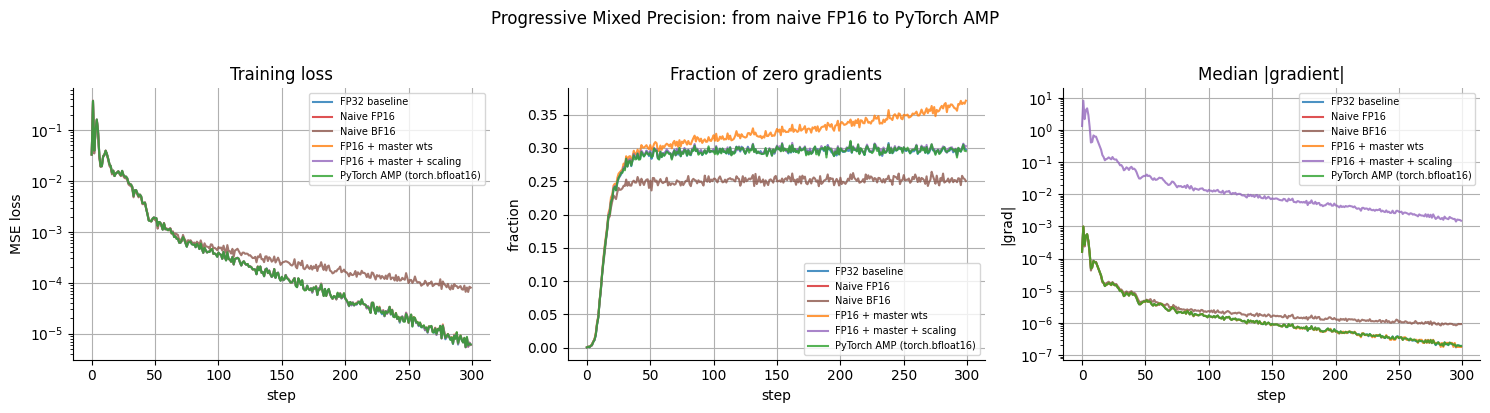

In [35]:
# Compare all progressive approaches

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

configs = [
    ("FP32 baseline", log_fp32, "C0"),
    ("Naive FP16", log_fp16_naive, "C3"),
    ("Naive BF16", log_bf16_naive, "C5"),
    ("FP16 + master wts", log_master, "C1"),
    ("FP16 + master + scaling", log_scaled, "C4"),
    (f"PyTorch AMP ({log_amp['dtype']})", log_amp, "C2"),
]

# Loss curves
for name, log, color in configs:
    if log["loss"]:
        axes[0].plot(log["loss"], label=name, color=color, alpha=0.8)
axes[0].set_title("Training loss")
axes[0].set_xlabel("step")
axes[0].set_ylabel("MSE loss")
axes[0].set_yscale("log")
axes[0].legend(fontsize=7)

# Zero gradient fraction
for name, log, color in configs:
    if log["zero_grad_frac"]:
        axes[1].plot(log["zero_grad_frac"], label=name, color=color, alpha=0.8)
axes[1].set_title("Fraction of zero gradients")
axes[1].set_xlabel("step")
axes[1].set_ylabel("fraction")
axes[1].legend(fontsize=7)

# Median gradient magnitude
for name, log, color in configs:
    if log["median_grad"]:
        axes[2].plot(log["median_grad"], label=name, color=color, alpha=0.8)
axes[2].set_title("Median |gradient|")
axes[2].set_xlabel("step")
axes[2].set_ylabel("|grad|")
axes[2].set_yscale("log")
axes[2].legend(fontsize=7)

fig.suptitle("Progressive Mixed Precision: from naive FP16 to PyTorch AMP", fontsize=12, y=1.02)
plt.tight_layout();

### 3.1.6 What to observe

**Loss curves:**
- FP32 baseline should decrease smoothly.
- Naive FP16 may diverge, stagnate, or produce NaN.
- **Naive BF16 often trains successfully** — this is the dramatic demonstration of range vs precision. Same "cast everything to 16-bit" approach, but BF16's 8-bit exponent prevents the gradient underflow that kills FP16.
- Adding master weights to FP16 typically helps convergence.
- Adding loss scaling to FP16 reduces the fraction of zero gradients.
- PyTorch AMP should match or beat the manual implementations.

**Zero gradient fraction:**
- In naive FP16, many gradients may be exactly zero (underflow).
- In naive BF16, almost no gradients are zero — the exponent range is wide enough.
- Loss scaling shifts the FP16 distribution, rescuing underflowed gradients.

**Median gradient magnitude:**
- Shows the "signal strength" available to the optimizer.
- If it drops to zero, the model stops learning.
- Compare FP16 vs BF16: even with coarser mantissa, BF16 preserves gradient *signal*.

**The key lesson from this progressive build-up:**
Naive FP16 fails. BF16 naive often works. But both benefit from FP32 master weights and proper AMP policies. The Micikevicius paper's three-part recipe (per-op policy + loss scaling + master weights) handles FP16 correctly. BF16 simplifies the picture by removing the need for loss scaling, but master weights and per-op policies still help.

## 3.2 Build an "autocast operator policy table" from your local PyTorch

Instead of trusting a static table from the internet, we can probe your exact PyTorch version:
1. Run each op with autocast **disabled** → observe output dtype.
2. Run each op with autocast **enabled** → observe output dtype.
3. Compare to see which ops autocast changes.

In [36]:
# Enhanced operator policy probe

def probe_ops(dev, amp_dtype):
    a32 = torch.randn(128, 128, device=dev, dtype=torch.float32)
    b32 = torch.randn(128, 128, device=dev, dtype=torch.float32)
    x128 = torch.randn(2, 128, device=dev, dtype=torch.float32)
    x_big = torch.randn(2, 20000, device=dev, dtype=torch.float32)
    w32 = torch.randn(128, 128, device=dev, dtype=torch.float32)
    bias32 = torch.randn(128, device=dev, dtype=torch.float32)
    target32 = torch.randn(128, 128, device=dev, dtype=torch.float32)
    x16 = x_big.to(amp_dtype)

    ops = {
        # Matmul-like (expect lower precision)
        "matmul (a @ b)": lambda: a32 @ b32,
        "F.linear": lambda: F.linear(a32, w32, bias32),
        # Numerically sensitive (expect FP32)
        "F.softmax": lambda: F.softmax(x128, dim=-1),
        "F.layer_norm": lambda: F.layer_norm(x128, [x128.size(-1)]),
        "F.cross_entropy": lambda: F.cross_entropy(a32[:10], torch.randint(0, 128, (10,), device=dev)),
        "F.mse_loss": lambda: F.mse_loss(a32, target32),
        "torch.exp": lambda: torch.exp(x128),
        "torch.log": lambda: torch.log(x128.abs() + 1e-6),
        "torch.sum": lambda: x_big.sum(),
        "torch.prod": lambda: x_big[:, :10].prod(),
        # Pass-through (expect input dtype)
        "F.relu": lambda: F.relu(x_big),
        "torch.max": lambda: x_big.max(),
        "torch.min": lambda: x_big.min(),
        "torch.mean": lambda: x_big.mean(),
        "F.dropout": lambda: F.dropout(x_big, p=0.0, training=True),
    }

    rows = []
    for name, fn in ops.items():
        # Without autocast
        y_no = fn()
        dt_no = str(y_no.dtype) if isinstance(y_no, torch.Tensor) else "n/a"
        # With autocast (FP32 inputs)
        with amp_autocast(dev, amp_dtype, enabled=True):
            y_ac = fn()
        dt_ac = str(y_ac.dtype) if isinstance(y_ac, torch.Tensor) else "n/a"

        # With autocast (16-bit inputs, where applicable)
        dt_ac16 = ""
        try:
            # Replace x32 temporarily
            ops_16 = {
                "F.relu": lambda: F.relu(x16),
                "torch.max": lambda: x16.max(),
                "torch.min": lambda: x16.min(),
                "torch.mean": lambda: x16.mean(),
                "torch.sum": lambda: x16.sum(),
            }
            if name in ops_16:
                with amp_autocast(dev, amp_dtype, enabled=True):
                    y16 = ops_16[name]()
                dt_ac16 = str(y16.dtype)
        except Exception:
            pass

        changed = dt_no != dt_ac
        rows.append({
            "op": name,
            "no_autocast": dt_no,
            f"autocast({amp_dtype})_fp32_input": dt_ac,
            "16bit_input": dt_ac16 if dt_ac16 else "-",
            "policy": "LOWER PREC" if "float16" in dt_ac or "bfloat16" in dt_ac else ("FP32" if changed or dt_ac == "torch.float32" else "pass-through"),
        })

    return pd.DataFrame(rows)

for amp_dt in [torch.float16, torch.bfloat16]:
    if device.type == "cuda" and amp_dt is torch.bfloat16 and not torch.cuda.is_bf16_supported():
        continue
    if device.type == "cpu" and amp_dt is torch.float16:
        continue
    if not supports_dtype_on_device(amp_dt, device):
        continue
    print(f"\n=== Autocast policy with amp_dtype={amp_dt} ===")
    display(probe_ops(device, amp_dt))


=== Autocast policy with amp_dtype=torch.float16 ===


,op,no_autocast,autocast(torch.float16)_fp32_input,16bit_input,policy
0,matmul (a @ b),torch.float32,torch.float16,-,LOWER PREC
1,F.linear,torch.float32,torch.float16,-,LOWER PREC
2,F.softmax,torch.float32,torch.float32,-,FP32
3,F.layer_norm,torch.float32,torch.float32,-,FP32
4,F.cross_entropy,torch.float32,torch.float32,-,FP32
5,F.mse_loss,torch.float32,torch.float32,-,FP32
6,torch.exp,torch.float32,torch.float32,-,FP32
7,torch.log,torch.float32,torch.float32,-,FP32
8,torch.sum,torch.float32,torch.float32,torch.float32,FP32
9,torch.prod,torch.float32,torch.float32,-,FP32



=== Autocast policy with amp_dtype=torch.bfloat16 ===


,op,no_autocast,autocast(torch.bfloat16)_fp32_input,16bit_input,policy
0,matmul (a @ b),torch.float32,torch.bfloat16,-,LOWER PREC
1,F.linear,torch.float32,torch.bfloat16,-,LOWER PREC
2,F.softmax,torch.float32,torch.float32,-,FP32
3,F.layer_norm,torch.float32,torch.float32,-,FP32
4,F.cross_entropy,torch.float32,torch.float32,-,FP32
5,F.mse_loss,torch.float32,torch.float32,-,FP32
6,torch.exp,torch.float32,torch.float32,-,FP32
7,torch.log,torch.float32,torch.float32,-,FP32
8,torch.sum,torch.float32,torch.float32,torch.float32,FP32
9,torch.prod,torch.float32,torch.float32,-,FP32


### 3.2.1 The "sum vs mean" mystery

Under autocast, `sum` produces FP32 output but `mean` stays in the input dtype. Why?

**`sum`** is a reduction that accumulates values. Summing 20,000 BF16 values can easily exceed the representable range (BF16 max ~ $3.4 \times 10^{38}$, but even FP16 max is only ~65,504). More critically, the rounding errors from adding many small values compound. PyTorch hardcodes `sum` to promote to FP32.

**`mean`** inherently divides by $N$, keeping the output bounded between the min and max of the input. It cannot overflow by accumulation. PyTorch treats it as a pass-through — whatever dtype goes in, the same comes out.

**`prod`** is similar to `sum` but even more extreme: multiplying many values can grow (or shrink) astronomically. Also forced to FP32.

Let's verify this directly.

In [37]:
# The sum vs mean mystery — direct probe

if device.type == "cuda":
    dtype_16bit = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    x16 = torch.randn(2, 20000, device=device, dtype=dtype_16bit)

    with torch.autocast(device_type="cuda", dtype=dtype_16bit):
        results = {
            "max": x16.max().dtype,
            "min": x16.min().dtype,
            "sum": x16.sum().dtype,
            "mean": x16.mean().dtype,
            "prod": x16.prod().dtype,
            "exp": x16.exp().dtype,
            "log": x16.abs().log().dtype,
        }

    rows = []
    for op, dt in results.items():
        rows.append({
            "op": op,
            "output_dtype": str(dt),
            "promoted_to_fp32": "YES" if dt == torch.float32 else "no",
            "reason": {
                "max": "element-wise selection, no accumulation",
                "min": "element-wise selection, no accumulation",
                "sum": "ACCUMULATION: rounding errors compound over N values",
                "mean": "bounded output (divides by N), no overflow risk",
                "prod": "ACCUMULATION: multiplicative explosion/collapse",
                "exp": "can produce extreme magnitudes (overflow risk)",
                "log": "can produce extreme magnitudes (underflow risk)",
            }.get(op, ""),
        })

    display(pd.DataFrame(rows))
else:
    print("Run on CUDA to see the sum vs mean mystery in action.")

,op,output_dtype,promoted_to_fp32,reason
0,max,torch.bfloat16,no,"element-wise selection, no accumulation"
1,min,torch.bfloat16,no,"element-wise selection, no accumulation"
2,sum,torch.float32,YES,ACCUMULATION: rounding errors compound over N ...
3,mean,torch.bfloat16,no,"bounded output (divides by N), no overflow risk"
4,prod,torch.float32,YES,ACCUMULATION: multiplicative explosion/collapse
5,exp,torch.float32,YES,can produce extreme magnitudes (overflow risk)
6,log,torch.float32,YES,can produce extreme magnitudes (underflow risk)


### 3.2.2 Per-layer precision toy examples: why autocast treats layers differently

Autocast exists for two reasons:

1. **Accumulation** — summing many terms compounds rounding error. A matmul of shape `[M, K] @ [K, N]` accumulates `K` products per output element. As `K` grows, FP16's 10-bit mantissa loses signal.
2. **Exponentiation** — `exp(x)` amplifies errors and overflows in FP16 for `x > ~11`. Softmax depends on `exp`, so it's precision-sensitive.

Below we test **three representative layer types** — attention, activation functions, and FFN linear layers — in up to **6 configurations** each: 3 dtypes (FP32, FP16, BF16) × 2 modes (no autocast, with autocast). (Some dtype/backend combos may be skipped if a kernel is unavailable.) All errors are measured against an FP64 reference.

,dtype,mode,max_weight_err,output_cos_sim,attn_entropy
0,FP32,no autocast,8.383162e-08,1.000000,5.182400e-07
1,FP32,autocast,8.383162e-08,1.000000,5.182400e-07
2,FP16,no autocast,4.414281e-05,1.000000,4.354157e-07
3,FP16,autocast,4.088494e-06,1.000000,4.775162e-07
4,BF16,no autocast,4.414281e-05,0.999999,4.890790e-07
5,BF16,autocast,1.275925e-06,0.999999,5.379194e-07


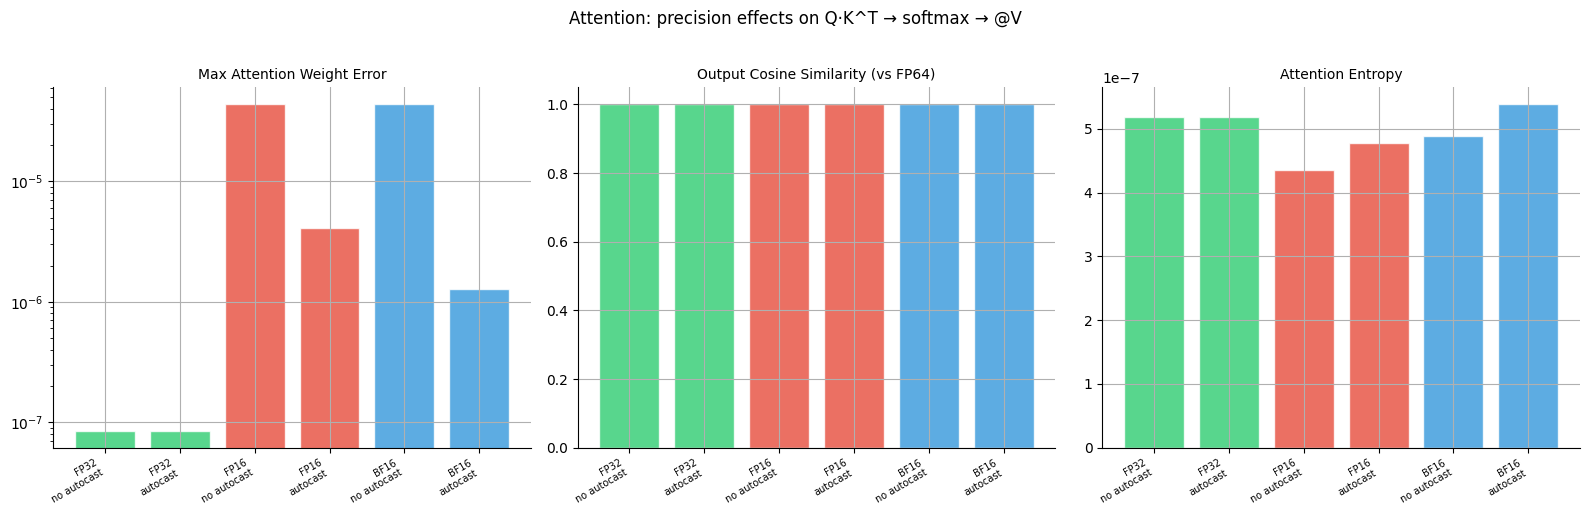

In [38]:
# Cell A: Attention (Q·K^T → softmax → @V)
#
# Why precision-sensitive:
#   - Two matmuls with accumulation
#   - softmax with exp (overflow risk in FP16)

set_seed(0)
B, N_HEADS, SEQ, HEAD_DIM = 4, 4, 64, 32

# Create random Q, K, V (scaled up by 5x to stress precision)
q64 = torch.randn(B, N_HEADS, SEQ, HEAD_DIM, device=device, dtype=torch.float64) * 5
k64 = q64.clone()  # K = Q → large diagonal in Q·K^T, stressing softmax with peaked logits
v64 = torch.randn(B, N_HEADS, SEQ, HEAD_DIM, device=device, dtype=torch.float64) * 5

def attention_forward(q, k, v):
    scale = math.sqrt(q.size(-1))
    scores = (q @ k.transpose(-2, -1)) / scale
    weights = torch.softmax(scores, dim=-1)
    output = weights @ v
    return weights, output

# FP64 reference
w64, o64 = attention_forward(q64, k64, v64)

attn_rows = []
attn_skipped = []
for dtype_name, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
    if not supports_dtype_on_device(dtype, device):
        continue
    for ac_label, use_ac in [("no autocast", False), ("autocast", True)]:
        try:
            q_cast = q64.to(dtype)
            k_cast = k64.to(dtype)
            v_cast = v64.to(dtype)
            if use_ac:
                with amp_autocast(device, dtype, enabled=True):
                    w_test, o_test = attention_forward(q_cast, k_cast, v_cast)
            else:
                w_test, o_test = attention_forward(q_cast, k_cast, v_cast)
        except Exception as exc:
            attn_skipped.append({
                "dtype": dtype_name,
                "mode": ac_label,
                "reason": str(exc).splitlines()[0],
            })
            continue
        # Errors vs FP64
        w_err = float((w_test.double() - w64).abs().max())
        cos = float(F.cosine_similarity(o_test.double().flatten().unsqueeze(0),
                                         o64.flatten().unsqueeze(0)))
        entropy = float(-(w_test.double() * (w_test.double() + 1e-12).log()).sum(-1).mean())
        attn_rows.append({
            "dtype": dtype_name, "mode": ac_label,
            "max_weight_err": w_err, "output_cos_sim": cos, "attn_entropy": entropy,
        })

df_attn = pd.DataFrame(attn_rows)
display(df_attn)
if attn_skipped:
    print("Skipped attention configs (unsupported dtype/backend path):")
    display(pd.DataFrame(attn_skipped))

# Plot: grouped bar chart
if len(df_attn) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    labels = [f"{r['dtype']}\n{r['mode']}" for _, r in df_attn.iterrows()]
    x = np.arange(len(labels))
    colors = ["#e74c3c" if "FP16" in l else "#3498db" if "BF16" in l else "#2ecc71" for l in labels]

    for ax, metric, title in zip(axes, ["max_weight_err", "output_cos_sim", "attn_entropy"],
                                  ["Max Attention Weight Error", "Output Cosine Similarity (vs FP64)", "Attention Entropy"]):
        vals = df_attn[metric].tolist()
        bars = ax.bar(x, vals, color=colors, alpha=0.8, edgecolor="white")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=7, rotation=30, ha="right")
        ax.set_title(title, fontsize=10)
        if metric == "max_weight_err":
            ax.set_yscale("log")

    fig.suptitle("Attention: precision effects on Q·K^T → softmax → @V", fontsize=12, y=1.02)
    plt.tight_layout()

**Observation (Attention):**
- FP16 without autocast shows the **largest attention weight errors** — `exp()` in softmax amplifies small rounding differences into large distribution shifts.
- On many CUDA AMP policies, autocast routes softmax/reductions to FP32 while keeping matmuls in 16-bit, giving near-FP32-quality attention weights (verify with your local traces in Sections 3.2/3.3).
- BF16's wider exponent range means it rarely overflows in softmax, but its lower mantissa precision still shows higher error than FP32.

Autocast-vs-no-autocast output deltas (same input dtype):


,dtype,relu_max_delta(ac-vs-noac),gelu_max_delta(ac-vs-noac)
0,FP32,0.0,0.0
1,FP16,0.0,0.0
2,BF16,0.0,0.0


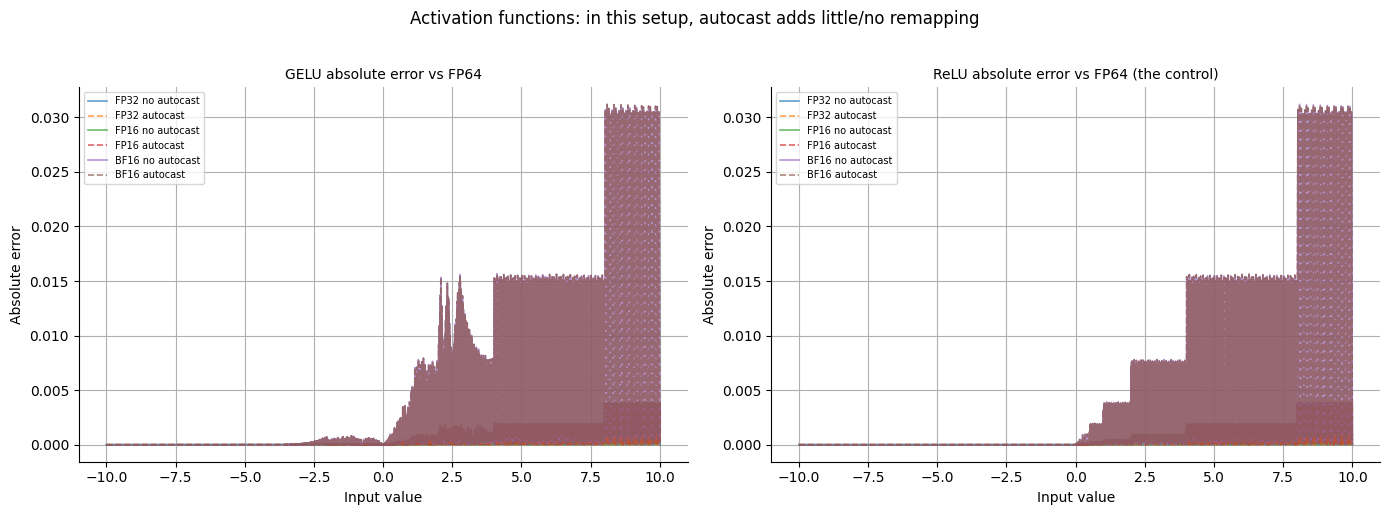

In [39]:
# Cell B: Activation Functions (ReLU vs GELU)
#
# Why interesting: Element-wise ops, no accumulation → autocast treats them as pass-through.

x64 = torch.linspace(-10, 10, 10000, device=device, dtype=torch.float64)
relu_ref = F.relu(x64)
gelu_ref = F.gelu(x64)

act_results = []
act_skipped = []
for dtype_name, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
    if not supports_dtype_on_device(dtype, device):
        continue
    for ac_label, use_ac in [("no autocast", False), ("autocast", True)]:
        try:
            x_cast = x64.to(dtype)
            if use_ac:
                with amp_autocast(device, dtype, enabled=True):
                    relu_out = F.relu(x_cast)
                    gelu_out = F.gelu(x_cast)
            else:
                relu_out = F.relu(x_cast)
                gelu_out = F.gelu(x_cast)
        except Exception as exc:
            act_skipped.append({
                "dtype": dtype_name,
                "mode": ac_label,
                "reason": str(exc).splitlines()[0],
            })
            continue
        relu_err = (relu_out.double() - relu_ref).abs()
        gelu_err = (gelu_out.double() - gelu_ref).abs()
        act_results.append({
            "dtype": dtype_name, "mode": ac_label,
            "relu_max_err": float(relu_err.max()),
            "gelu_max_err": float(gelu_err.max()),
            "x": x64.cpu().numpy(),
            "relu_err": relu_err.cpu().numpy(),
            "gelu_err": gelu_err.cpu().numpy(),
            "relu_out": relu_out.float().cpu().numpy(),
            "gelu_out": gelu_out.float().cpu().numpy(),
        })

# Quantify whether autocast itself changes activation outputs at a fixed dtype.
delta_rows = []
for dtype_name in ["FP32", "FP16", "BF16"]:
    no_ac = next((r for r in act_results if r["dtype"] == dtype_name and r["mode"] == "no autocast"), None)
    ac = next((r for r in act_results if r["dtype"] == dtype_name and r["mode"] == "autocast"), None)
    if no_ac is None or ac is None:
        continue
    delta_rows.append({
        "dtype": dtype_name,
        "relu_max_delta(ac-vs-noac)": float(np.max(np.abs(ac["relu_out"] - no_ac["relu_out"]))),
        "gelu_max_delta(ac-vs-noac)": float(np.max(np.abs(ac["gelu_out"] - no_ac["gelu_out"]))),
    })
if delta_rows:
    print("Autocast-vs-no-autocast output deltas (same input dtype):")
    display(pd.DataFrame(delta_rows))
if act_skipped:
    print("Skipped activation configs (unsupported dtype/backend path):")
    display(pd.DataFrame(act_skipped))

# Plot: error vs input value
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for row in act_results:
    label = f"{row['dtype']} {row['mode']}"
    ls = "--" if row["mode"] == "autocast" else "-"
    axes[0].plot(row["x"], row["gelu_err"], label=label, ls=ls, alpha=0.7, lw=1.2)
    axes[1].plot(row["x"], row["relu_err"], label=label, ls=ls, alpha=0.7, lw=1.2)

axes[0].set_title("GELU absolute error vs FP64", fontsize=10)
axes[0].set_xlabel("Input value")
axes[0].set_ylabel("Absolute error")
axes[0].legend(fontsize=7)

axes[1].set_title("ReLU absolute error vs FP64 (the control)", fontsize=10)
axes[1].set_xlabel("Input value")
axes[1].set_ylabel("Absolute error")
axes[1].legend(fontsize=7)

fig.suptitle("Activation functions: in this setup, autocast adds little/no remapping", fontsize=12, y=1.02)
plt.tight_layout()

**Observation (Activations):**
- ReLU still inherits **input quantization error** (because positive outputs copy the rounded input), so error is small but generally not zero in FP16/BF16.
- GELU shows larger low-precision error than ReLU (nonlinear approximation), but **autocast vs no-autocast curves typically overlap** at the same dtype.
- Takeaway: element-wise activations are usually pass-through for autocast policy; most error here comes from the input dtype itself, not autocast remapping.

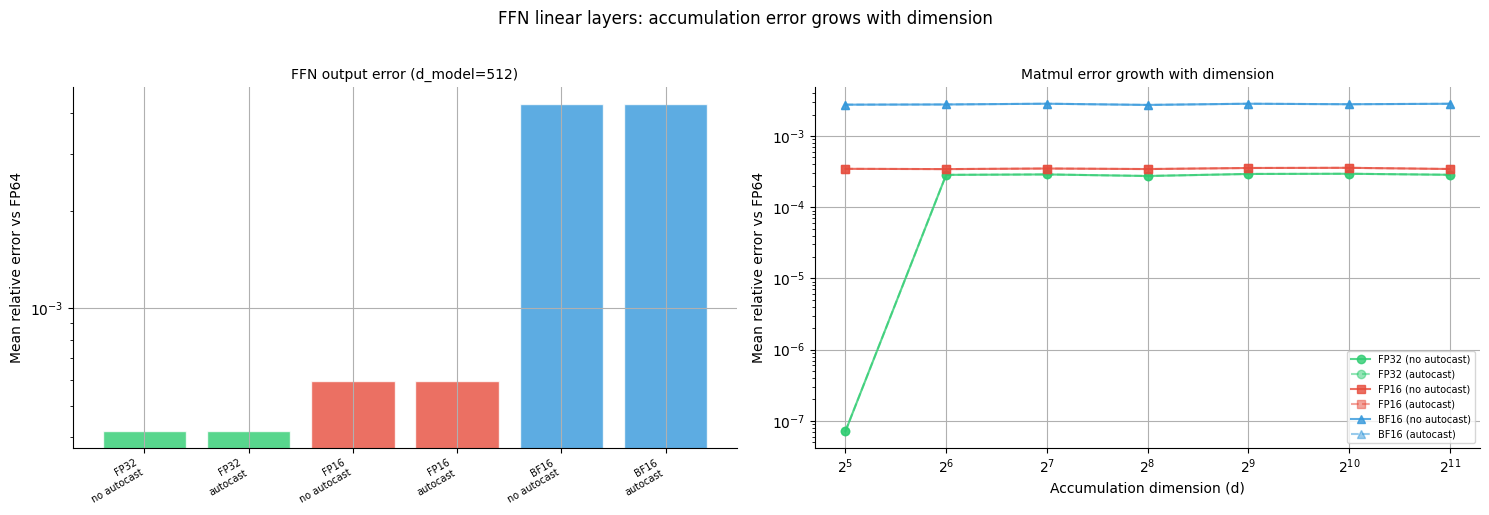

In [40]:
# Cell C: FFN Linear Layers (matmul accumulation)
#
# Why precision-sensitive: y = x @ W^T + b accumulates d_model products per output.

set_seed(0)

# Part 1: FFN at d_model=512
D_MODEL = 512
D_FF = 2048
x64_ffn = torch.randn(4, 64, D_MODEL, device=device, dtype=torch.float64)
w1_64 = torch.randn(D_FF, D_MODEL, device=device, dtype=torch.float64) * 0.02
b1_64 = torch.randn(D_FF, device=device, dtype=torch.float64) * 0.02
w2_64 = torch.randn(D_MODEL, D_FF, device=device, dtype=torch.float64) * 0.02
b2_64 = torch.randn(D_MODEL, device=device, dtype=torch.float64) * 0.02

# FP64 reference
y64 = F.linear(F.gelu(F.linear(x64_ffn, w1_64, b1_64)), w2_64, b2_64)

ffn_results = []
ffn_skipped = []
for dtype_name, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
    if not supports_dtype_on_device(dtype, device):
        continue
    for ac_label, use_ac in [("no autocast", False), ("autocast", True)]:
        try:
            x_c = x64_ffn.to(dtype)
            w1_c, b1_c = w1_64.to(dtype), b1_64.to(dtype)
            w2_c, b2_c = w2_64.to(dtype), b2_64.to(dtype)
            if use_ac:
                with amp_autocast(device, dtype, enabled=True):
                    y_test = F.linear(F.gelu(F.linear(x_c, w1_c, b1_c)), w2_c, b2_c)
            else:
                y_test = F.linear(F.gelu(F.linear(x_c, w1_c, b1_c)), w2_c, b2_c)
        except Exception as exc:
            ffn_skipped.append({
                "dtype": dtype_name,
                "mode": ac_label,
                "phase": f"ffn_d{D_MODEL}",
                "reason": str(exc).splitlines()[0],
            })
            continue
        rel_err = float((y_test.double() - y64).abs().mean() / (y64.abs().mean() + 1e-12))
        ffn_results.append({"dtype": dtype_name, "mode": ac_label, "mean_rel_err": rel_err})

# Part 2: Accumulation error vs dimension
dims = [32, 64, 128, 256, 512, 1024, 2048]
scaling_results = {dname: {"no_ac": [], "ac": []} for dname in ["FP32", "FP16", "BF16"]}

for d in dims:
    set_seed(0)
    a64 = torch.randn(64, d, device=device, dtype=torch.float64)
    b64_mat = torch.randn(d, 64, device=device, dtype=torch.float64) * 0.02
    ref = (a64 @ b64_mat)
    for dname, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
        if not supports_dtype_on_device(dtype, device):
            continue
        a_c, b_c = a64.to(dtype), b64_mat.to(dtype)
        # No autocast
        try:
            out_no_ac = (a_c @ b_c)
            err_no_ac = float((out_no_ac.double() - ref).abs().mean() / (ref.abs().mean() + 1e-12))
            scaling_results[dname]["no_ac"].append((d, err_no_ac))
        except Exception as exc:
            ffn_skipped.append({
                "dtype": dname,
                "mode": "no autocast",
                "phase": f"matmul_d{d}",
                "reason": str(exc).splitlines()[0],
            })
        # With autocast
        try:
            with amp_autocast(device, dtype, enabled=True):
                out_ac = (a_c @ b_c)
            err_ac = float((out_ac.double() - ref).abs().mean() / (ref.abs().mean() + 1e-12))
            scaling_results[dname]["ac"].append((d, err_ac))
        except Exception as exc:
            ffn_skipped.append({
                "dtype": dname,
                "mode": "autocast",
                "phase": f"matmul_d{d}",
                "reason": str(exc).splitlines()[0],
            })

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: grouped bars at d=512
ax = axes[0]
df_ffn = pd.DataFrame(ffn_results)
if len(df_ffn) > 0:
    labels = [f"{r['dtype']}\n{r['mode']}" for _, r in df_ffn.iterrows()]
    x_pos = np.arange(len(labels))
    colors = ["#e74c3c" if "FP16" in l else "#3498db" if "BF16" in l else "#2ecc71" for l in labels]
    ax.bar(x_pos, df_ffn["mean_rel_err"].tolist(), color=colors, alpha=0.8, edgecolor="white")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=7, rotation=30, ha="right")
    ax.set_ylabel("Mean relative error vs FP64")
    ax.set_title(f"FFN output error (d_model={D_MODEL})", fontsize=10)
    ax.set_yscale("log")

# Right: error vs dimension (the money plot)
ax = axes[1]
style_map = {"FP32": ("#2ecc71", "o"), "FP16": ("#e74c3c", "s"), "BF16": ("#3498db", "^")}
for dname, data in scaling_results.items():
    if dname not in style_map:
        continue
    color, marker = style_map[dname]
    if data["no_ac"]:
        x_no = [t[0] for t in data["no_ac"]]
        y_no = [t[1] for t in data["no_ac"]]
        ax.plot(x_no, y_no, color=color, marker=marker,
                ls="-", label=f"{dname} (no autocast)", alpha=0.8)
    if data["ac"]:
        x_ac = [t[0] for t in data["ac"]]
        y_ac = [t[1] for t in data["ac"]]
        ax.plot(x_ac, y_ac, color=color, marker=marker,
                ls="--", label=f"{dname} (autocast)", alpha=0.5)

ax.set_xlabel("Accumulation dimension (d)")
ax.set_ylabel("Mean relative error vs FP64")
ax.set_title("Matmul error growth with dimension", fontsize=10)
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.legend(fontsize=7)

fig.suptitle("FFN linear layers: accumulation error grows with dimension", fontsize=12, y=1.02)
plt.tight_layout()
if ffn_skipped:
    print("Skipped FFN configs (unsupported dtype/backend path):")
    display(pd.DataFrame(ffn_skipped))

**Observation (FFN Linear Layers):**
- At `d_model=512`, FP16 error is ~10× higher than FP32. BF16 is in between (wider range, less mantissa precision).
- The **right plot is the money plot**: in random-sum regimes, FP16 matmul error often follows an approximately $O(\sqrt{d})$ trend with accumulation dimension, while FP32 stays flatter.
- Autocast usually doesn't change the matmul error much by itself because the multiply path remains low precision; on CUDA Tensor Cores, the key hardware fix is FP32 accumulation.
- **Takeaway:** low-precision multiply can be fast, but high-precision accumulation is critical for quality.

### 3.2.3 Numerical stability stress tests: adversarial inputs for sensitive ops

The toy examples above show *average-case* error. But precision failures often happen at the **edges** — extreme inputs that push operations into overflow, underflow, or degenerate behavior. Here we craft adversarial inputs for three precision-sensitive ops.

,test,dtype,max_error,degenerate,detail
0,Softmax (large close logits),FP32,0.000008,no,"spread=6.510e-04, probs=['0.3333', '0.3337', '..."
1,Softmax (large close logits),FP16,0.000415,YES,"spread=0.000e+00, probs=['0.3333', '0.3333', '..."
2,Softmax (large close logits),BF16,0.000984,YES,"spread=0.000e+00, probs=['0.3340', '0.3340', '..."
3,LayerNorm (var≈0),FP32,0.0000,no,"std=3.183e-03, range=[-0.0079, 0.0080]"
4,LayerNorm (var≈0),FP16,0.0080,YES,"std=0.000e+00, range=[0.0000, 0.0000]"
5,LayerNorm (var≈0),BF16,0.0080,YES,"std=0.000e+00, range=[0.0000, 0.0000]"
6,CrossEntropy (naive log(softmax)),FP32,0.016907,no,"naive=100, fused=100.000000"
7,CrossEntropy (naive log(softmax)),FP16,inf/nan,YES,"naive=inf, fused=100.000000"
8,CrossEntropy (naive log(softmax)),BF16,inf/nan,YES,"naive=inf, fused=100.000000"



Key findings:
  - Softmax: low precision can erase tiny logit differences at large magnitude, collapsing rank information.
  - LayerNorm: low precision can collapse near-zero-variance inputs, distorting normalized outputs.
  - Naive CE: -log(softmax(.)) in low precision can hit log(0); fused F.cross_entropy is much more stable.
  - These are precisely why AMP favors FP32 for sensitive reductions/log-space operations.


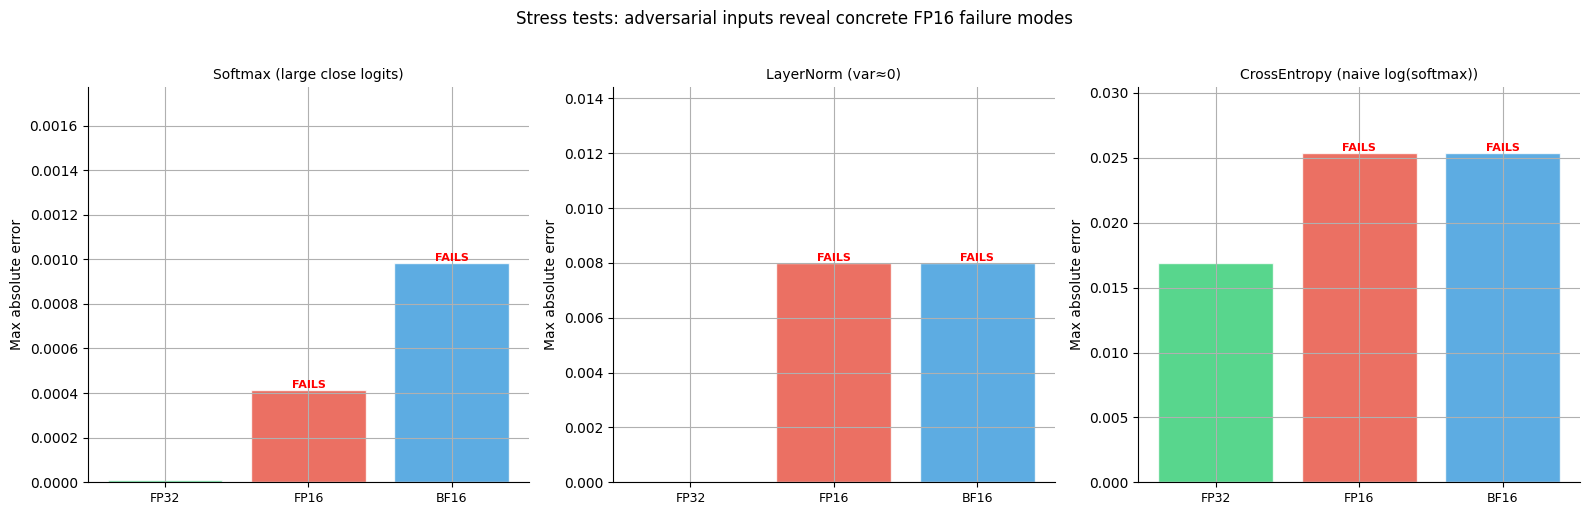

In [41]:
# Stress test: adversarial inputs for softmax, LayerNorm, and cross-entropy formulations

stress_rows = []
stress_skipped = []

# ── Test 1: Softmax with nearly-identical large logits ──
# In FP16, logits like [1000, 1000.001, 999.999] all round to the same value,
# erasing small ranking differences and collapsing toward a uniform distribution.

logits_64 = torch.tensor([[1000.0, 1000.001, 999.999]], device=device, dtype=torch.float64)
ref_softmax = torch.softmax(logits_64, dim=-1)

for dtype_name, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
    if not supports_dtype_on_device(dtype, device):
        continue
    try:
        logits_cast = logits_64.to(dtype)
        # softmax on cast inputs (some kernels may internally upcast)
        probs_native = torch.softmax(logits_cast, dim=-1)
        err = float((probs_native.double() - ref_softmax).abs().max())
        spread = float((probs_native.max() - probs_native.min()).double())
        is_degenerate = spread < 1e-6
        stress_rows.append({
            "test": "Softmax (large close logits)",
            "dtype": dtype_name,
            "max_error": f"{err:.6f}",
            "degenerate": "YES" if is_degenerate else "no",
            "detail": f"spread={spread:.3e}, probs={[f'{p:.4f}' for p in probs_native[0].tolist()]}",
        })
    except Exception as exc:
        stress_skipped.append({
            "test": "Softmax (large close logits)",
            "dtype": dtype_name,
            "reason": str(exc).splitlines()[0],
        })

# ── Test 2: LayerNorm with near-constant input (variance ≈ 0) ──
# When all inputs are nearly identical, variance → 0, and dividing by sqrt(var+eps)
# amplifies tiny differences. Low precision can collapse these perturbations.

near_const = torch.ones(1, 128, device=device, dtype=torch.float64) + \
    torch.randn(1, 128, device=device, dtype=torch.float64) * 1e-5
ln = nn.LayerNorm(128, device=device, dtype=torch.float64)
ln.weight.data.fill_(1.0)
ln.bias.data.fill_(0.0)
ref_ln = ln(near_const)

for dtype_name, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
    if not supports_dtype_on_device(dtype, device):
        continue
    try:
        ln_cast = nn.LayerNorm(128, device=device, dtype=dtype)
        ln_cast.weight.data.fill_(1.0)
        ln_cast.bias.data.fill_(0.0)
        inp_cast = near_const.to(dtype)
        out_cast = ln_cast(inp_cast)
        err = float((out_cast.double() - ref_ln).abs().max())
        out_std = float(out_cast.float().std(unbiased=False))
        is_collapsed = out_std < 1e-6 or bool(torch.isnan(out_cast).any())
        stress_rows.append({
            "test": "LayerNorm (var≈0)",
            "dtype": dtype_name,
            "max_error": f"{err:.4f}",
            "degenerate": "YES" if is_collapsed else "no",
            "detail": f"std={out_std:.3e}, range=[{float(out_cast.min()):.4f}, {float(out_cast.max()):.4f}]",
        })
    except Exception as exc:
        stress_skipped.append({
            "test": "LayerNorm (var≈0)",
            "dtype": dtype_name,
            "reason": str(exc).splitlines()[0],
        })

# ── Test 3: Cross-entropy decomposition vs fused implementation ──
# Naively computing -log(softmax(logits)[target]) can produce log(0) in low precision.
# F.cross_entropy uses a stabilized logsumexp path and is typically finite.

logits_ce_64 = torch.tensor([[50.0, -50.0, -50.0]], device=device, dtype=torch.float64)
target_wrong = torch.tensor([1], device=device)  # intentionally low-probability class
ref_naive = -torch.log_softmax(logits_ce_64, dim=-1).gather(1, target_wrong[:, None]).squeeze(1)

for dtype_name, dtype in [("FP32", torch.float32), ("FP16", torch.float16), ("BF16", torch.bfloat16)]:
    if not supports_dtype_on_device(dtype, device):
        continue
    try:
        logits_cast = logits_ce_64.to(dtype)
        probs_cast = torch.softmax(logits_cast, dim=-1)
        p_t = probs_cast.gather(1, target_wrong[:, None]).squeeze(1)
        naive_ce = -torch.log(p_t)
        fused_ce = F.cross_entropy(logits_cast, target_wrong)
        naive_finite = bool(torch.isfinite(naive_ce).all())
        if naive_finite:
            err = float((naive_ce.double() - ref_naive).abs().max())
            err_txt = f"{err:.6f}"
        else:
            err_txt = "inf/nan"
        stress_rows.append({
            "test": "CrossEntropy (naive log(softmax))",
            "dtype": dtype_name,
            "max_error": err_txt,
            "degenerate": "YES" if not naive_finite else "no",
            "detail": f"naive={float(naive_ce):.3g}, fused={float(fused_ce):.6f}",
        })
    except Exception as exc:
        stress_skipped.append({
            "test": "CrossEntropy (naive log(softmax))",
            "dtype": dtype_name,
            "reason": str(exc).splitlines()[0],
        })

df_stress = pd.DataFrame(stress_rows)
display(df_stress)
if stress_skipped:
    print("Skipped stress-test configs (unsupported dtype/backend path):")
    display(pd.DataFrame(stress_skipped))

# Summary bar plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
tests = ["Softmax (large close logits)", "LayerNorm (var≈0)", "CrossEntropy (naive log(softmax))"]
for ax, test_name in zip(axes, tests):
    subset = df_stress[df_stress["test"] == test_name].copy()
    if len(subset) == 0:
        continue
    labels_s = subset["dtype"].tolist()
    raw_errs = []
    for e in subset["max_error"].tolist():
        try:
            raw_errs.append(float(e))
        except ValueError:
            raw_errs.append(float("nan"))
    finite_errs = [v for v in raw_errs if np.isfinite(v)]
    cap = max(finite_errs + [1e-8]) * 1.5
    errs = [v if np.isfinite(v) else cap for v in raw_errs]
    colors_s = ["#e74c3c" if "FP16" in l else "#3498db" if "BF16" in l else "#2ecc71" for l in labels_s]
    ax.bar(range(len(labels_s)), errs, color=colors_s, alpha=0.8, edgecolor="white")
    ax.set_xticks(range(len(labels_s)))
    ax.set_xticklabels(labels_s, fontsize=9)
    ax.set_title(test_name, fontsize=10)
    ax.set_ylabel("Max absolute error")
    ax.set_ylim(0, cap * 1.2)
    # Mark degenerate
    for i, (_, row) in enumerate(subset.iterrows()):
        if row["degenerate"] == "YES":
            ax.annotate("FAILS", (i, errs[i]),
                        ha="center", va="bottom", fontsize=8, color="red", fontweight="bold")

fig.suptitle("Stress tests: adversarial inputs reveal concrete FP16 failure modes", fontsize=12, y=1.02)
plt.tight_layout()

print("\nKey findings:")
print("  - Softmax: low precision can erase tiny logit differences at large magnitude, collapsing rank information.")
print("  - LayerNorm: low precision can collapse near-zero-variance inputs, distorting normalized outputs.")
print("  - Naive CE: -log(softmax(.)) in low precision can hit log(0); fused F.cross_entropy is much more stable.")
print("  - These are precisely why AMP favors FP32 for sensitive reductions/log-space operations.")

## 3.3 Watch dtype flow through a transformer (4 configurations)

This is the "visceral" version of the operator policy: instead of probing individual ops, we observe dtypes flowing through a transformer forward pass.

**Practical model:** if you have `transformers` installed, we'll trace dtypes through the Hugging Face `facebook/opt-125m` model (OPT-125M). Otherwise we fall back to a tiny self-contained transformer (`TinyGPT`) that still exercises the same building blocks (embeddings, LayerNorm, linear projections, residuals).

The next cell can download OPT-125M once and cache it in a local directory (so the rest of the notebook doesn't depend on your global Hugging Face cache). Set `ALLOW_OPT_DOWNLOAD = False` to run the trace only if the weights/tokenizer are already cached locally.

We'll test all four combinations from the toy example (source1):

| Config | Model params | Autocast | What to observe |
|---|---|---|---|
| A | FP32 | OFF | Everything FP32 (baseline) |
| B | FP16/BF16 | OFF | Everything 16-bit (no policy) |
| C | FP16/BF16 | ON | LayerNorm→FP32, Linear→16-bit, residuals→16-bit |
| D | FP32 | ON | Linear→16-bit even with FP32 weights! LayerNorm stays FP32, residuals→FP32 (promotion) |

In [42]:
# Self-contained tiny transformer (TinyGPT) used later (and as a dtype-tracing fallback).

class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_heads, dropout=0.0):
        super().__init__()
        assert n_embd % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads
        self.qkv = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.proj = nn.Linear(n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        att = att.masked_fill(mask, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.proj(y)


class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_heads, dropout)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class TinyGPT(nn.Module):
    def __init__(self, vocab_size, block_size, n_layer=2, n_embd=128, n_heads=4, dropout=0.0):
        super().__init__()
        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerBlock(n_embd, n_heads, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

    def forward(self, idx):
        B, T = idx.shape
        assert T <= self.block_size
        pos = torch.arange(0, T, device=idx.device)
        x = self.tok_emb(idx) + self.pos_emb(pos)[None, :, :]
        x = self.drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        return self.head(x)

print("TinyGPT defined: self-contained transformer for later experiments (and as a dtype-tracing fallback).")

TinyGPT defined: self-contained transformer for later experiments (and as a dtype-tracing fallback).


In [43]:
# Pick a model for dtype tracing: OPT-125M if available, else TinyGPT.
#
# Why the indirection?
# - OPT-125M makes the trace look like real-world transformer code (Hugging Face module names).
# - But it adds optional deps and (unless cached) a ~500MB download, so we keep a no-download fallback.

TRACE_MODEL_KIND = "tinygpt"  # "opt-125m" if successfully loaded
TRACE_OPT_MODEL_NAME = "facebook/opt-125m"

# Download/caching controls (keep all "extra dependencies" and downloads in this one cell).
ALLOW_OPT_DOWNLOAD = True
from pathlib import Path
HF_CACHE_DIR = Path("./.cache/hf").resolve()
HF_CACHE_DIR.mkdir(parents=True, exist_ok=True)

trace_hf_model = None
trace_hf_inputs = None
trace_hf_tokenizer = None

if device.type == "cuda":
    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer
    except Exception as e:
        print(f"[info] transformers not available ({e}); using TinyGPT for dtype tracing.")
    else:
        try:
            hf_kwargs = {"cache_dir": str(HF_CACHE_DIR), "local_files_only": not ALLOW_OPT_DOWNLOAD}
            print(f"[info] OPT cache_dir: {HF_CACHE_DIR}")
            trace_hf_tokenizer = AutoTokenizer.from_pretrained(TRACE_OPT_MODEL_NAME, use_fast=True, **hf_kwargs)
            trace_hf_model = AutoModelForCausalLM.from_pretrained(
                TRACE_OPT_MODEL_NAME,
                torch_dtype=torch.float32,
                **hf_kwargs,
            ).to(device).eval()

            prompt = "Autocast dtypes through OPT-125M."
            trace_hf_inputs = trace_hf_tokenizer(prompt, return_tensors="pt")
            trace_hf_inputs = {k: v.to(device) for k, v in trace_hf_inputs.items()}

            TRACE_MODEL_KIND = "opt-125m"
            print(f"[info] Using {TRACE_OPT_MODEL_NAME} for dtype tracing.")
        except Exception as e:
            trace_hf_model = None
            trace_hf_inputs = None
            trace_hf_tokenizer = None
            if not ALLOW_OPT_DOWNLOAD:
                print(
                    f"[info] Could not load {TRACE_OPT_MODEL_NAME} from local cache_dir={HF_CACHE_DIR} ({e}). "
                    "Set ALLOW_OPT_DOWNLOAD=True to download, or continue with TinyGPT."
                )
            else:
                print(f"[info] Could not load {TRACE_OPT_MODEL_NAME} ({e}). Falling back to TinyGPT.")
else:
    print(f"[info] Using TinyGPT for dtype tracing on device_type={device.type} (OPT trace is CUDA-focused).")

[info] OPT cache_dir: /content/.cache/hf


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

[info] Using facebook/opt-125m for dtype tracing.


In [44]:
# Dtype hooks + 4-configuration trace

def install_dtype_hooks(model, watch=(nn.Linear, nn.LayerNorm, nn.Embedding)):
    hooks, records = [], []
    def make_hook(name):
        def hook(m, inp, out):
            def dt(x):
                return str(x.dtype) if isinstance(x, torch.Tensor) else type(x).__name__
            indt = dt(inp[0]) if isinstance(inp, (tuple, list)) and inp else dt(inp)
            oudt = dt(out) if not isinstance(out, (tuple, list)) else dt(out[0])
            records.append({"module": name, "type": type(m).__name__, "in_dtype": indt, "out_dtype": oudt})
        return hook
    for name, m in model.named_modules():
        if isinstance(m, watch):
            hooks.append(m.register_forward_hook(make_hook(name)))
    return hooks, records

VOCAB = 128
BLOCK = 64
idx = torch.randint(0, VOCAB, (2, BLOCK), device=device)

dtype_16 = torch.bfloat16
if device.type == "cuda" and not torch.cuda.is_bf16_supported():
    dtype_16 = torch.float16
elif device.type == "mps":
    dtype_16 = torch.float16

configs = [
    ("A: params=FP32, autocast=OFF", torch.float32, False),
    ("B: params=16bit, autocast=OFF", dtype_16, False),
    ("C: params=16bit, autocast=ON",  dtype_16, True),
    ("D: params=FP32, autocast=ON",   torch.float32, True),
]

import copy

for title, param_dt, use_ac in configs:
    if TRACE_MODEL_KIND == "opt-125m" and trace_hf_model is not None:
        # Avoid mutating trace_hf_model in-place across configs.
        model = copy.deepcopy(trace_hf_model).to(param_dt).eval()
        hooks, rec = install_dtype_hooks(model)
        ctx = amp_autocast(device, dtype_16, enabled=use_ac)
        with torch.inference_mode(), ctx:
            _ = model(**trace_hf_inputs, use_cache=False)
    else:
        model = TinyGPT(VOCAB, BLOCK).to(device).to(param_dt)
        hooks, rec = install_dtype_hooks(model)
        ctx = amp_autocast(device, dtype_16, enabled=use_ac)
        with torch.inference_mode(), ctx:
            _ = model(idx)
    for h in hooks:
        h.remove()
    df = pd.DataFrame(rec)
    df["count"] = 1
    summary = df.groupby(["type", "in_dtype", "out_dtype"], as_index=False)["count"].sum()
    summary = summary.sort_values(["type", "in_dtype", "out_dtype"])
    print(f"\n--- {title} ---")
    display(summary)


--- A: params=FP32, autocast=OFF ---


,type,in_dtype,out_dtype,count
0,Embedding,torch.int64,torch.float32,1
1,LayerNorm,torch.float32,torch.float32,25
2,Linear,torch.float32,torch.float32,73
3,OPTLearnedPositionalEmbedding,torch.int64,torch.float32,1



--- B: params=16bit, autocast=OFF ---


,type,in_dtype,out_dtype,count
0,Embedding,torch.int64,torch.bfloat16,1
1,LayerNorm,torch.bfloat16,torch.bfloat16,25
2,Linear,torch.bfloat16,torch.bfloat16,73
3,OPTLearnedPositionalEmbedding,torch.int64,torch.bfloat16,1



--- C: params=16bit, autocast=ON ---


,type,in_dtype,out_dtype,count
0,Embedding,torch.int64,torch.bfloat16,1
1,LayerNorm,torch.bfloat16,torch.float32,25
2,Linear,torch.bfloat16,torch.bfloat16,24
3,Linear,torch.float32,torch.bfloat16,49
4,OPTLearnedPositionalEmbedding,torch.int64,torch.bfloat16,1



--- D: params=FP32, autocast=ON ---


,type,in_dtype,out_dtype,count
0,Embedding,torch.int64,torch.float32,1
1,LayerNorm,torch.float32,torch.float32,25
2,Linear,torch.bfloat16,torch.bfloat16,24
3,Linear,torch.float32,torch.bfloat16,49
4,OPTLearnedPositionalEmbedding,torch.int64,torch.float32,1


### 3.3.1 What the traces reveal

**Config A (FP32, no autocast):** Everything is FP32. Baseline.

**Config B (16-bit, no autocast):** Mostly 16-bit. No per-op autocast policy. Sensitive ops are more exposed to low-precision drift.

**Config C (16-bit params, autocast ON):**
- On common CUDA policies, LayerNorm frequently shows 16-bit input → **FP32 output** (autocast safety path for normalization).
- Linear after LayerNorm often shows **FP32 input → 16-bit output** (autocast routes matmul compute to reduced precision).
- This is the key insight: autocast doesn't just "use 16-bit everywhere." It routes different ops to different precisions.

**Config D (FP32 params, autocast ON):**
- Linear frequently appears as **FP32 input → 16-bit output** (autocast downcasts compute inputs/weights for matmul-like ops).
- LayerNorm usually stays FP32 in these traces.
- Residual adds: 16-bit + FP32 → **FP32** (dtype promotion)
- This is the "standard" AMP configuration: model stays in FP32, autocast handles per-op casting.

```
Config D data flow (FP32 params + autocast):

[int64 tokens]
       |
  +----+---------------------+
  |                          |
[embed_tok] int64->fp32    [embed_pos] int64->fp32
  |                          |
  +-------- sum (fp32+fp32->fp32) --------+
                                          |
                                        [LN1] fp32->fp32
                                          |
                      +---------+---------+---------+
                      |         |                   |
                   [q_proj]  [k_proj]           [v_proj]
                    fp32->bf16  fp32->bf16      fp32->bf16
                      \         |                 /
                       \        |                /
                        +----[attn + softmax]----+   (bf16 compute)
                                          |
                                    [out_proj] bf16->bf16
                                          |
                (residual add: bf16 + fp32 -> fp32)   <- promotion!
                                          |
                                        [LN2] fp32->fp32
                                          |
                                       [fc1] fp32->bf16
                                          |
                                       [fc2] bf16->bf16
                                          |
                (residual add: bf16 + fp32 -> fp32)   <- promotion!
```

The promotion at residual connections is a key feature: it prevents precision loss from accumulating through the network's residual stream.

> **Note on BatchNorm (for CNN practitioners):** While our transformer example uses LayerNorm, convolutional architectures typically use **BatchNorm**, which maintains running statistics (`running_mean`, `running_var`) that are updated with an exponential moving average across batches. These running statistics must stay in **FP32** — they are long-lived accumulators that would drift significantly in FP16/BF16. PyTorch's autocast handles this automatically (BatchNorm is on the FP32 "keep" list), but if you manually cast your model with `.half()` or `.bfloat16()`, the running statistics will also be cast to low precision, potentially corrupting them over many batches. If you must manually cast, keep normalization layers in FP32: `model.half(); for m in model.modules(): if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)): m.float()`.

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

Orange arrows mark dtype transitions (promotion or demotion) between input and output.


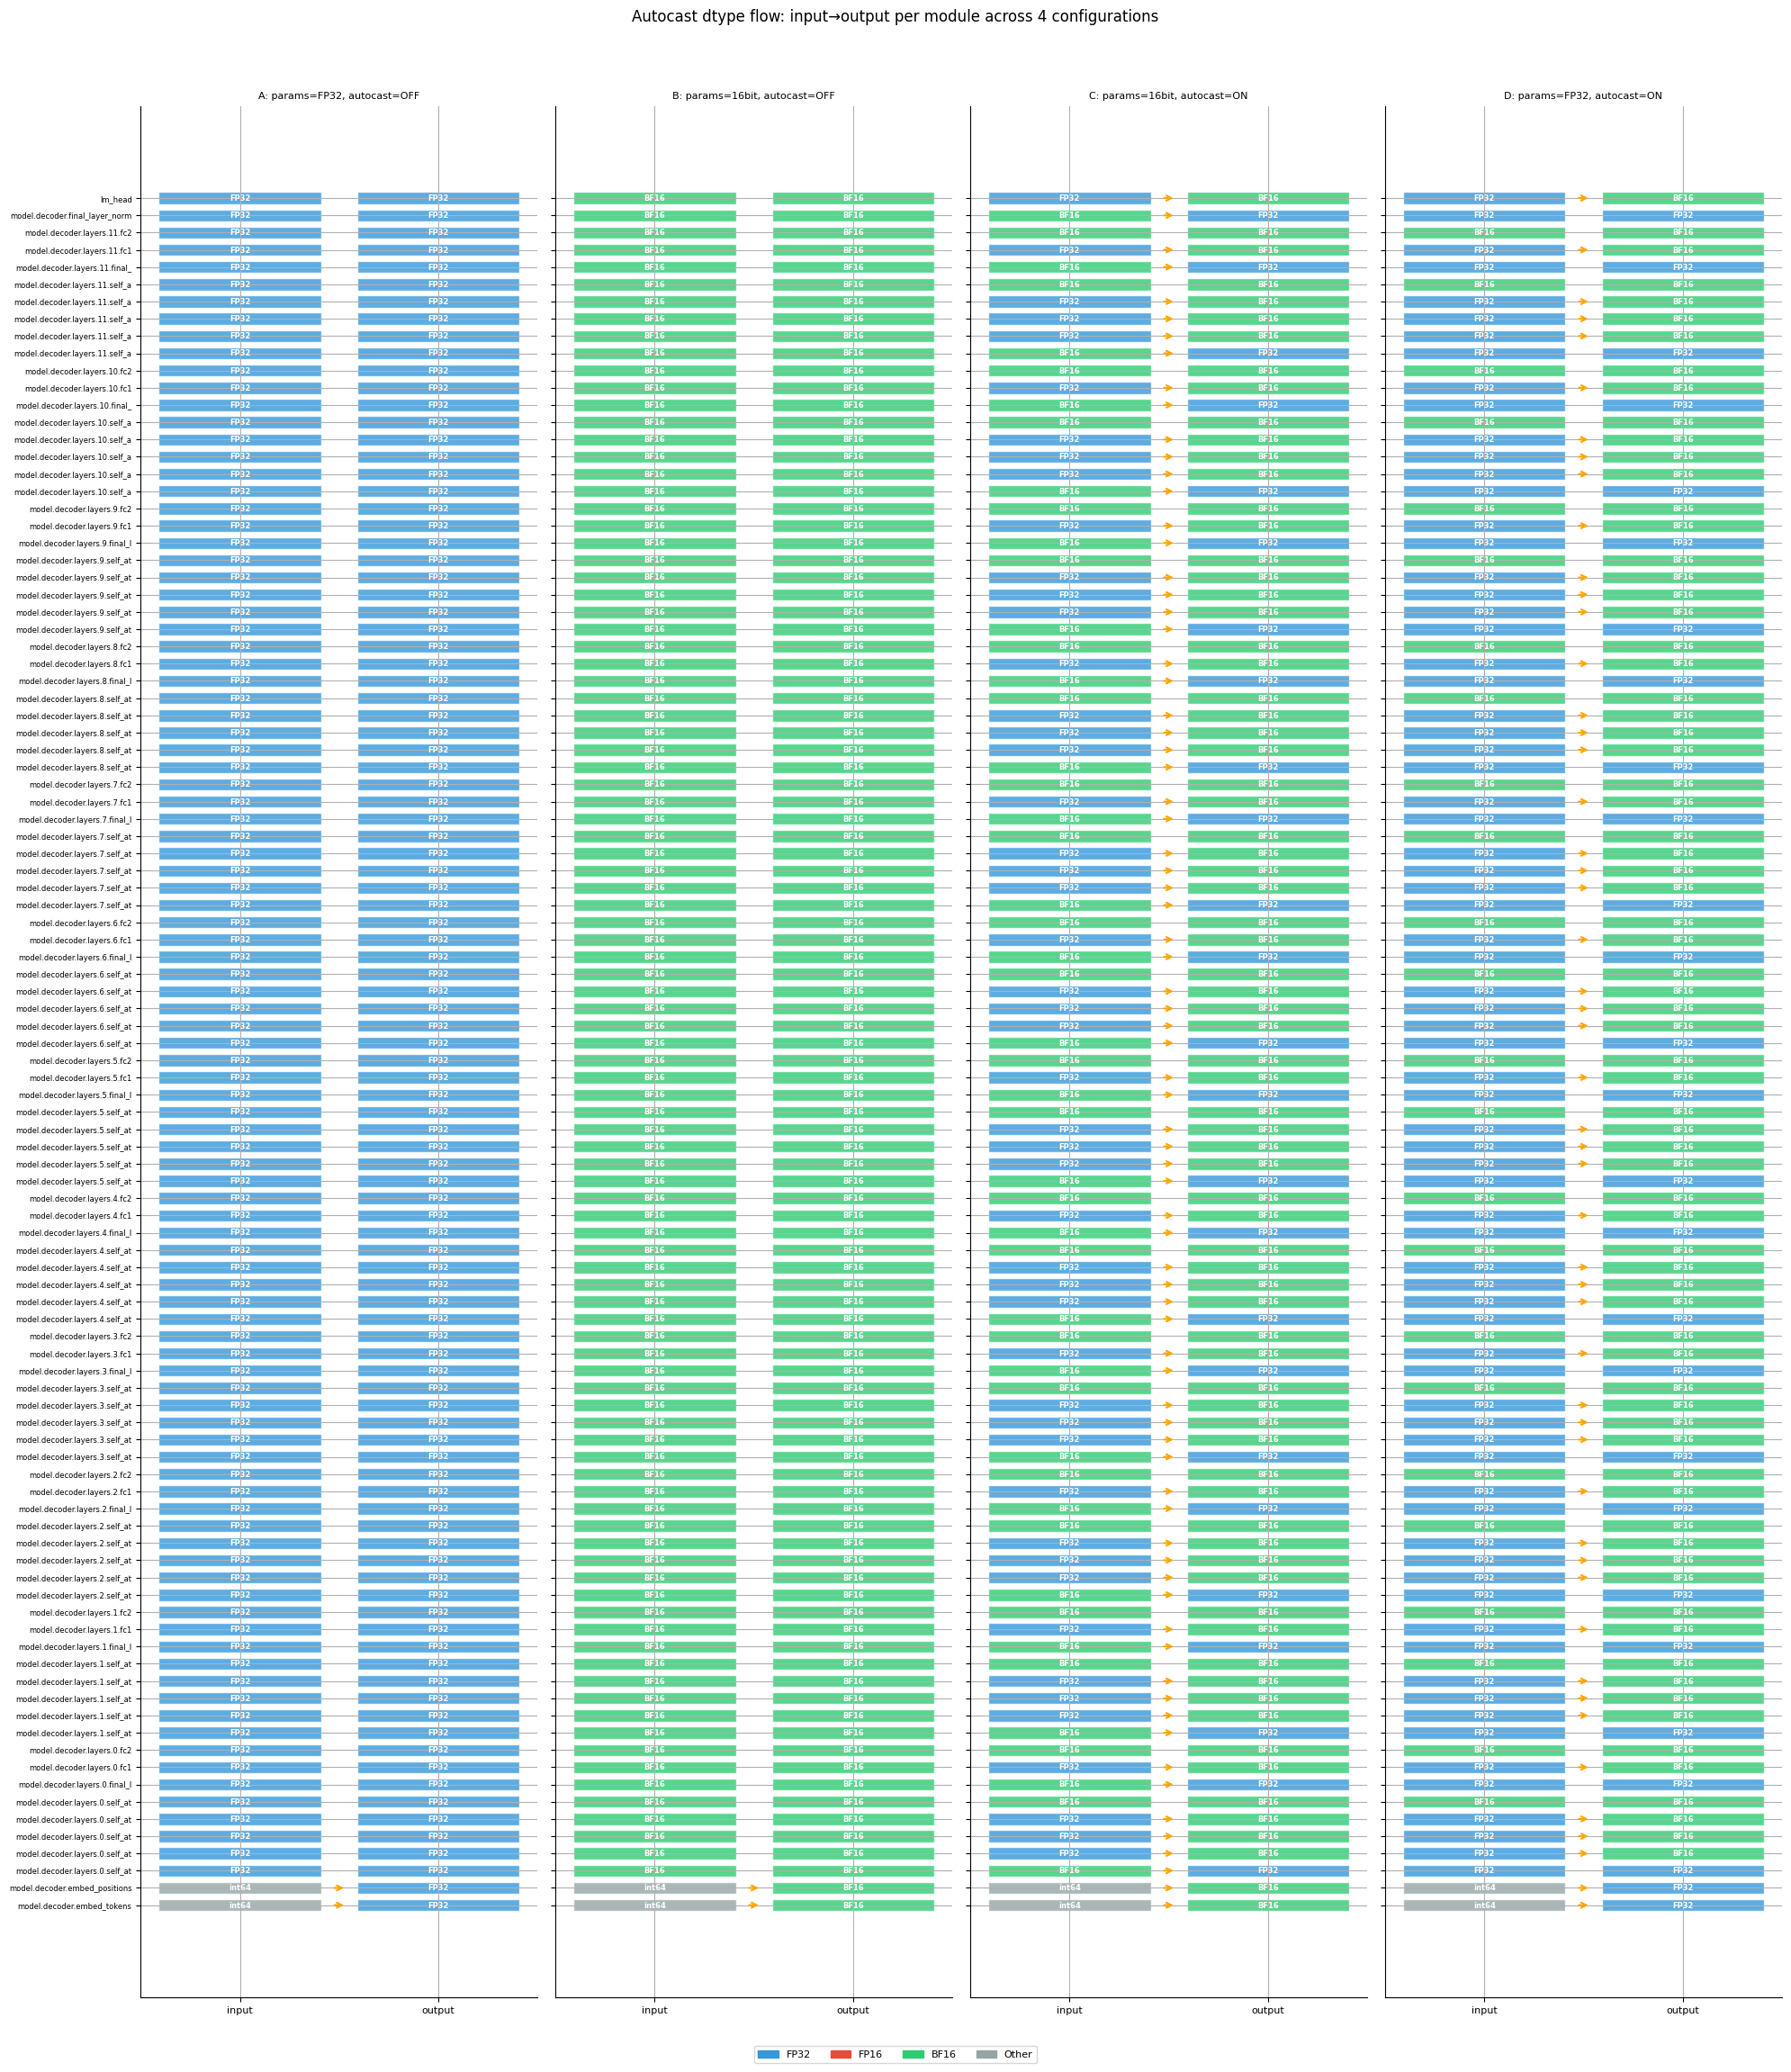

In [45]:
# Autocast boundary flow diagram: visualize dtype transitions per module
#
# Convert the trace records from the 4-config experiment into a horizontal
# stacked-bar visualization showing input→output dtype for each module.

# Re-run the 4 configs to collect detailed per-module records for visualization.

import copy

all_config_records = {}
for title, param_dt, use_ac in configs:
    if TRACE_MODEL_KIND == "opt-125m" and trace_hf_model is not None:
        # Keep trace_hf_model pristine for downstream sections (e.g., OPT training).
        model_v = copy.deepcopy(trace_hf_model).to(param_dt).eval()
        hooks_v, rec_v = install_dtype_hooks(model_v)
        ctx_v = amp_autocast(device, dtype_16, enabled=use_ac)
        with torch.inference_mode(), ctx_v:
            _ = model_v(**trace_hf_inputs, use_cache=False)
    else:
        model_v = TinyGPT(VOCAB, BLOCK).to(device).to(param_dt)
        hooks_v, rec_v = install_dtype_hooks(model_v)
        ctx_v = amp_autocast(device, dtype_16, enabled=use_ac)
        with torch.inference_mode(), ctx_v:
            _ = model_v(idx)
    for h_v in hooks_v:
        h_v.remove()
    all_config_records[title] = rec_v

# Build the visualization
dtype_colors = {
    "torch.float32": "#3498db",   # blue
    "torch.float16": "#e74c3c",   # red
    "torch.bfloat16": "#2ecc71",  # green
}
dtype_short = {
    "torch.float32": "FP32",
    "torch.float16": "FP16",
    "torch.bfloat16": "BF16",
}

n_configs = len(all_config_records)
max_modules = max((len(records) for records in all_config_records.values()), default=1)
fig, axes = plt.subplots(1, n_configs, figsize=(5 * n_configs, max(6, 0.22 * max_modules)),
                          sharey=True)
if n_configs == 1:
    axes = [axes]

for ax, (cfg_title, records) in zip(axes, all_config_records.items()):
    if not records:
        ax.set_title(cfg_title.split(":")[0], fontsize=9)
        continue
    modules = [r["module"] for r in records]
    in_dtypes = [r["in_dtype"] for r in records]
    out_dtypes = [r["out_dtype"] for r in records]

    y_pos = np.arange(len(modules))

    # Draw two bars per module: input dtype (left half) and output dtype (right half)
    in_colors = [dtype_colors.get(d, "#95a5a6") for d in in_dtypes]
    out_colors = [dtype_colors.get(d, "#95a5a6") for d in out_dtypes]

    ax.barh(y_pos, [0.45] * len(modules), left=0, color=in_colors, alpha=0.8,
            edgecolor="white", height=0.7, label="input dtype")
    ax.barh(y_pos, [0.45] * len(modules), left=0.55, color=out_colors, alpha=0.8,
            edgecolor="white", height=0.7, label="output dtype")

    # Annotate dtype transitions
    for i, (in_d, out_d) in enumerate(zip(in_dtypes, out_dtypes)):
        in_label = dtype_short.get(in_d, in_d.replace("torch.", ""))
        out_label = dtype_short.get(out_d, out_d.replace("torch.", ""))
        ax.text(0.225, i, in_label, ha="center", va="center", fontsize=6, fontweight="bold", color="white")
        ax.text(0.775, i, out_label, ha="center", va="center", fontsize=6, fontweight="bold", color="white")
        # Arrow marker for dtype promotion/demotion
        if in_d != out_d:
            ax.annotate("", xy=(0.52, i), xytext=(0.48, i),
                        arrowprops=dict(arrowstyle="->", color="orange", lw=1.5))

    ax.set_yticks(y_pos)
    ax.set_yticklabels([m[:30] for m in modules], fontsize=6)
    ax.set_xlim(-0.05, 1.05)
    ax.set_xticks([0.225, 0.775])
    ax.set_xticklabels(["input", "output"], fontsize=8)
    ax.set_title(cfg_title.split(":")[0] + ":" + cfg_title.split(":", 1)[1][:40], fontsize=8)
    ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_handles = [Patch(color=c, label=l) for l, c in
                  [("FP32", "#3498db"), ("FP16", "#e74c3c"), ("BF16", "#2ecc71"), ("Other", "#95a5a6")]]
fig.legend(handles=legend_handles, loc="lower center", ncol=4, fontsize=8,
           bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Autocast dtype flow: input→output per module across 4 configurations",
             fontsize=12, y=1.02)
plt.tight_layout()
print("Orange arrows mark dtype transitions (promotion or demotion) between input and output.")

### 3.3.2 Per-layer precision sensitivity: which parts of the transformer hurt most?

The dtype hooks above show *what* dtype each layer uses. But a deeper question is: **which layers are most affected by the precision change?**

We'll do this on `TinyGPT` (the self-contained transformer above) because it's small enough to hook every module without external downloads or long runtimes. The takeaways generalize to OPT-125M and other LLMs: attention/logits, reductions, and normalization are usually where precision matters most.

In [46]:
# Per-layer output error: FP32 vs autocast

import copy

set_seed(0)
sens_model = TinyGPT(VOCAB, BLOCK, n_layer=2, n_embd=128, n_heads=4, dropout=0.0).to(device).float()

# Collect per-module outputs under FP32 and autocast
def collect_outputs(model, idx, use_autocast_flag, amp_dt):
    outputs = {}
    hooks = []
    def make_hook(name):
        def hook(m, inp, out):
            if isinstance(out, torch.Tensor):
                outputs[name] = out.detach().float().cpu().clone()
            elif isinstance(out, (tuple, list)) and len(out) > 0 and isinstance(out[0], torch.Tensor):
                outputs[name] = out[0].detach().float().cpu().clone()
        return hook

    for name, m in model.named_modules():
        if name:  # skip root
            hooks.append(m.register_forward_hook(make_hook(name)))

    with torch.inference_mode():
        ctx = amp_autocast(device, amp_dt, enabled=use_autocast_flag)
        with ctx:
            _ = model(idx)

    for h in hooks:
        h.remove()
    return outputs

idx_sens = torch.randint(0, VOCAB, (2, BLOCK), device=device)

out_fp32 = collect_outputs(sens_model, idx_sens, False, None)

dtype_16 = torch.bfloat16
if device.type == "cuda" and not torch.cuda.is_bf16_supported():
    dtype_16 = torch.float16
elif device.type == "mps":
    dtype_16 = torch.float16

out_ac = collect_outputs(sens_model, idx_sens, True, dtype_16)

# Compare
rows = []
for name in sorted(out_fp32.keys()):
    if name not in out_ac:
        continue
    o32 = out_fp32[name]
    oac = out_ac[name]
    if o32.shape != oac.shape:
        continue
    abs_err = (oac - o32).abs()
    rel_err = abs_err / (o32.abs() + 1e-8)
    rows.append({
        "module": name,
        "max_abs_err": f"{float(abs_err.max()):.2e}",
        "mean_abs_err": f"{float(abs_err.mean()):.2e}",
        "mean_rel_err": f"{float(rel_err.mean()):.2e}",
        "max_rel_err": f"{float(rel_err.max()):.2e}",
    })

df_sens = pd.DataFrame(rows)

# Sort by mean_rel_err descending to show most sensitive layers first
df_sens["_sort"] = df_sens["mean_rel_err"].apply(lambda x: float(x))
df_sens = df_sens.sort_values("_sort", ascending=False).drop(columns=["_sort"])

print(f"Per-module output error: FP32 vs autocast({dtype_16})")
print(f"{'='*70}")
display(df_sens)

print("\nInterpretation:")
print("  - Layers with HIGHER error are more precision-sensitive.")
print("  - LayerNorm, softmax, and final head outputs tend to show larger errors")
print("    because they involve reductions and normalization.")
print("  - Linear layers often show small errors because Tensor Cores accumulate in FP32.")
print("  - This explains why autocast's policy protects normalization and loss ops in FP32.")

Per-module output error: FP32 vs autocast(torch.bfloat16)


,module,max_abs_err,mean_abs_err,mean_rel_err,max_rel_err
13,blocks.1.attn,3.90e-03,3.29e-04,3.17e-02,2.69e+01
15,blocks.1.attn.proj,3.90e-03,3.29e-04,3.17e-02,2.69e+01
25,head,1.36e-02,1.42e-03,3.12e-02,2.21e+02
19,blocks.1.mlp,3.68e-03,7.15e-04,3.05e-02,4.06e+01
22,blocks.1.mlp.2,3.68e-03,7.15e-04,3.05e-02,4.06e+01
23,blocks.1.mlp.3,3.68e-03,7.15e-04,3.05e-02,4.06e+01
21,blocks.1.mlp.1,1.29e-02,8.27e-04,2.56e-02,2.43e+02
20,blocks.1.mlp.0,1.18e-02,1.39e-03,2.55e-02,2.44e+02
1,blocks.0.attn,4.42e-03,3.13e-04,2.51e-02,3.12e+01
3,blocks.0.attn.proj,4.42e-03,3.13e-04,2.51e-02,3.12e+01



Interpretation:
  - Layers with HIGHER error are more precision-sensitive.
  - LayerNorm, softmax, and final head outputs tend to show larger errors
    because they involve reductions and normalization.
  - Linear layers often show small errors because Tensor Cores accumulate in FP32.
  - This explains why autocast's policy protects normalization and loss ops in FP32.


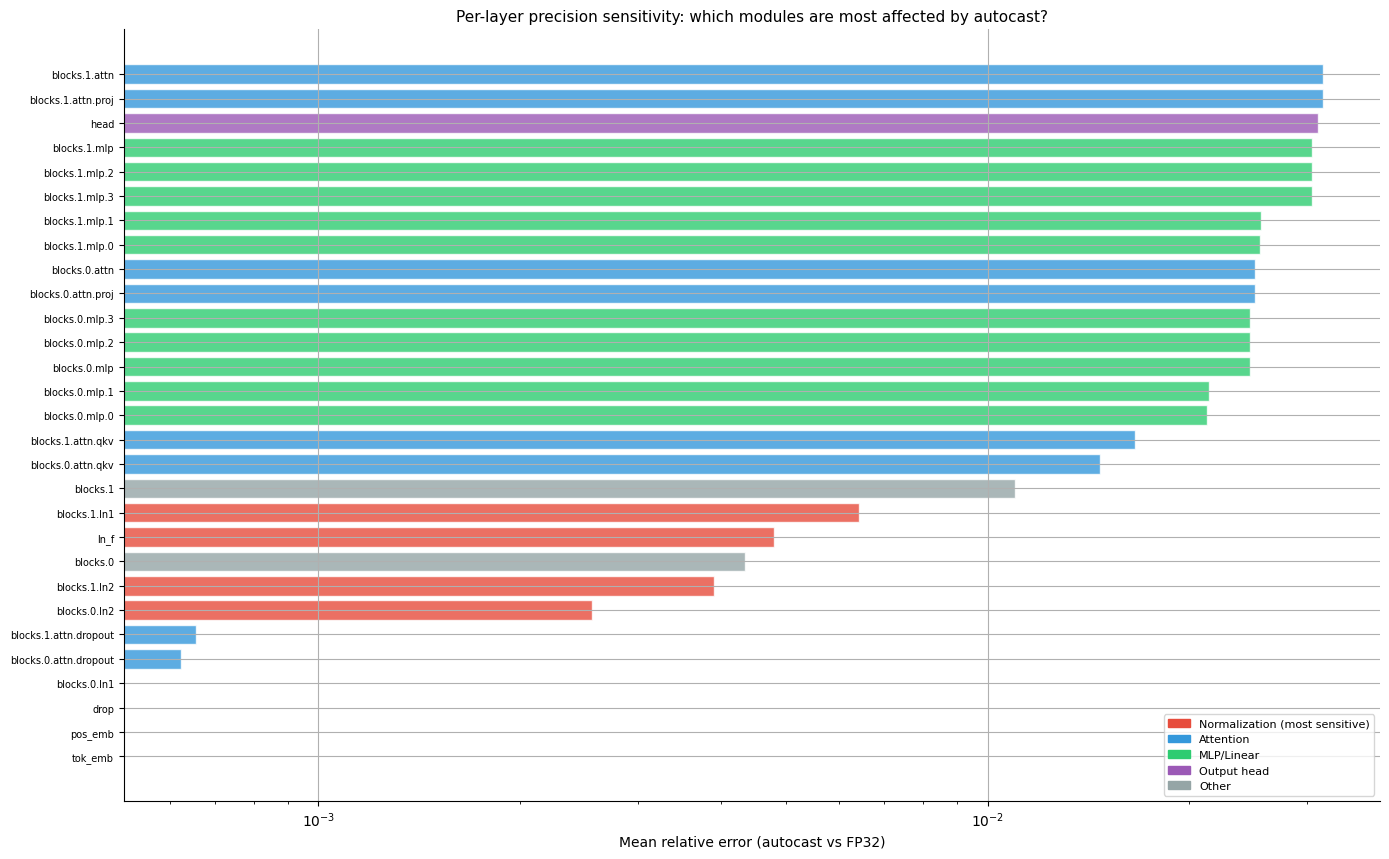

In [47]:
# Visualize per-layer sensitivity as a bar chart

if len(rows) > 0:
    fig, ax = plt.subplots(figsize=(14, max(4, len(rows) * 0.3)))

    names_plot = df_sens["module"].tolist()
    errors_plot = [float(x) for x in df_sens["mean_rel_err"].tolist()]

    # Color by module type
    colors_plot = []
    for n in names_plot:
        if "ln" in n.lower() or "norm" in n.lower():
            colors_plot.append("#e74c3c")  # red for normalization
        elif "attn" in n.lower() or "qkv" in n.lower() or "proj" in n.lower():
            colors_plot.append("#3498db")  # blue for attention
        elif "mlp" in n.lower() or "fc" in n.lower():
            colors_plot.append("#2ecc71")  # green for MLP
        elif "head" in n.lower():
            colors_plot.append("#9b59b6")  # purple for output head
        else:
            colors_plot.append("#95a5a6")  # gray for other

    y_pos = range(len(names_plot))
    ax.barh(y_pos, errors_plot, color=colors_plot, alpha=0.8, edgecolor="white")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names_plot, fontsize=7)
    ax.set_xlabel("Mean relative error (autocast vs FP32)")
    ax.set_title("Per-layer precision sensitivity: which modules are most affected by autocast?", fontsize=11)
    ax.set_xscale("log")
    ax.invert_yaxis()

    from matplotlib.patches import Patch
    legend_el = [
        Patch(color="#e74c3c", label="Normalization (most sensitive)"),
        Patch(color="#3498db", label="Attention"),
        Patch(color="#2ecc71", label="MLP/Linear"),
        Patch(color="#9b59b6", label="Output head"),
        Patch(color="#95a5a6", label="Other"),
    ]
    ax.legend(handles=legend_el, loc="lower right", fontsize=8)
    plt.tight_layout()

### 3.3.3 Per-layer *gradient* sensitivity: which layers contribute most error in the backward pass?

The forward-pass sensitivity above shows output differences. But for training, what matters is whether **gradients** are corrupted. Here we measure: if you force *only one layer* to FP16 (while everything else stays FP32), how much does each layer's gradient contribution change?

This directly answers: *"If I need to keep some layers in FP32 for training stability, which ones?"*

Interpretation:
  - Bars are sorted from highest to lowest gradient sensitivity.
  - LayerNorm and attention modules typically dominate (reductions + softmax).
  - Linear layers are often less sensitive than normalization/attention in this test.
    (On CUDA Tensor Cores, FP32 accumulation in matmuls is a big reason.)
  - If you must keep some layers in FP32 for stability, prioritize the top bars.


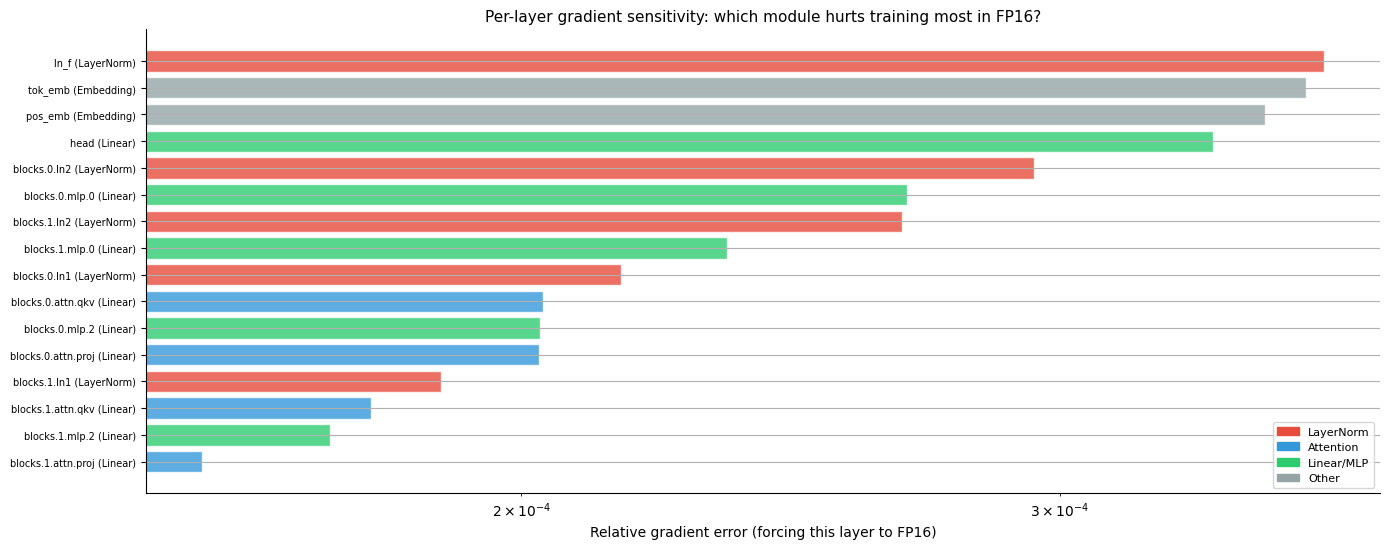

In [48]:
# Per-layer gradient sensitivity: force one layer at a time to FP16

import copy

set_seed(0)
model_ref = TinyGPT(vocab_size=128, block_size=64, n_layer=2, n_embd=128, n_heads=4, dropout=0.0).to(device).float()
idx_gs = torch.randint(0, 128, (2, 64), device=device)
x_gs = idx_gs[:, :-1]
y_gs = idx_gs[:, 1:]

# Reference: full FP32 forward + backward
model_ref.zero_grad()
logits_ref = model_ref(x_gs)
loss_ref = F.cross_entropy(logits_ref.reshape(-1, logits_ref.size(-1)),
                            y_gs.reshape(-1))
loss_ref.backward()
ref_grads = {}
for name, p in model_ref.named_parameters():
    if p.grad is not None:
        ref_grads[name] = p.grad.detach().clone().float()

def cast_floating(x, dtype):
    if isinstance(x, torch.Tensor):
        return x.to(dtype) if x.is_floating_point() else x
    if isinstance(x, tuple):
        return tuple(cast_floating(v, dtype) for v in x)
    if isinstance(x, list):
        return [cast_floating(v, dtype) for v in x]
    return x

# For each named module with parameters, force ONLY that module to FP16
grad_sensitivity = []
for mod_name, mod in model_ref.named_modules():
    params_in_mod = list(mod.parameters(recurse=False))
    if not params_in_mod:
        continue

    # Deep copy model, cast only this module to FP16.
    # Hooks cast module boundaries so the rest of the network stays FP32.
    model_test = copy.deepcopy(model_ref).float()
    mod_map = dict(model_test.named_modules())
    target_mod = mod_map.get(mod_name, None)
    if target_mod is None:
        continue
    target_mod.half()

    h_pre = target_mod.register_forward_pre_hook(
        lambda module, args: cast_floating(args, torch.float16)
    )
    h_post = target_mod.register_forward_hook(
        lambda module, args, out: cast_floating(out, torch.float32)
    )

    model_test.zero_grad(set_to_none=True)
    try:
        logits_test = model_test(x_gs)
        loss_test = F.cross_entropy(logits_test.reshape(-1, logits_test.size(-1)),
                                     y_gs.reshape(-1))
        loss_test.backward()
    except Exception as exc:
        grad_sensitivity.append({"module": mod_name, "type": type(mod).__name__,
                                  "grad_rel_err": float("nan"), "note": str(exc).splitlines()[0]})
        h_pre.remove()
        h_post.remove()
        continue
    h_pre.remove()
    h_post.remove()

    # Measure gradient error across ALL parameters (not just this module's)
    total_err = 0.0
    total_norm = 0.0
    for name, p in model_test.named_parameters():
        if p.grad is not None and name in ref_grads:
            err = (p.grad.float() - ref_grads[name]).abs().sum().item()
            norm = ref_grads[name].abs().sum().item() + 1e-12
            total_err += err
            total_norm += norm

    grad_sensitivity.append({
        "module": mod_name if mod_name else "(root)",
        "type": type(mod).__name__,
        "grad_rel_err": total_err / total_norm,
        "note": "",
    })

# Sort and plot
df_gs_all = pd.DataFrame(grad_sensitivity)
df_failed = df_gs_all[df_gs_all["grad_rel_err"].isna()].copy()
df_gs = df_gs_all.dropna(subset=["grad_rel_err"]).copy()
df_gs = df_gs[df_gs["grad_rel_err"] > 0].sort_values("grad_rel_err", ascending=False)

if len(df_gs) > 0:
    fig, ax = plt.subplots(figsize=(14, max(4, len(df_gs) * 0.35)))

    mod_names = df_gs["module"].tolist()
    mod_types = df_gs["type"].tolist()
    errs = df_gs["grad_rel_err"].tolist()

    colors_gs = []
    for n, t in zip(mod_names, mod_types):
        n_l = n.lower()
        t_l = t.lower()
        if "ln" in n_l or "norm" in n_l or "layernorm" in t_l:
            colors_gs.append("#e74c3c")
        elif "attn" in n_l or "attention" in n_l or "qkv" in n_l:
            colors_gs.append("#3498db")
        elif "mlp" in n_l or "ffn" in n_l or "fc" in n_l or "linear" in t_l:
            colors_gs.append("#2ecc71")
        else:
            colors_gs.append("#95a5a6")

    y_pos = range(len(mod_names))
    ax.barh(y_pos, errs, color=colors_gs, alpha=0.8, edgecolor="white")
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{n} ({t})" for n, t in zip(mod_names, mod_types)], fontsize=7)
    ax.set_xlabel("Relative gradient error (forcing this layer to FP16)")
    ax.set_title("Per-layer gradient sensitivity: which module hurts training most in FP16?", fontsize=11)
    ax.set_xscale("log")
    ax.invert_yaxis()

    from matplotlib.patches import Patch
    legend_gs = [
        Patch(color="#e74c3c", label="LayerNorm"),
        Patch(color="#3498db", label="Attention"),
        Patch(color="#2ecc71", label="Linear/MLP"),
        Patch(color="#95a5a6", label="Other"),
    ]
    ax.legend(handles=legend_gs, loc="lower right", fontsize=8)
    plt.tight_layout()

    print("Interpretation:")
    print("  - Bars are sorted from highest to lowest gradient sensitivity.")
    print("  - LayerNorm and attention modules typically dominate (reductions + softmax).")
    print("  - Linear layers are often less sensitive than normalization/attention in this test.")
    print("    (On CUDA Tensor Cores, FP32 accumulation in matmuls is a big reason.)")
    print("  - If you must keep some layers in FP32 for stability, prioritize the top bars.")
else:
    print("No gradient sensitivity data collected (need TinyGPT defined above).")

if len(df_failed) > 0:
    print("\nModules skipped (no valid mixed-precision backward on this device/runtime):")
    display(df_failed[["module", "type", "note"]])

## 3.4 Gradient underflow and why loss scaling works

We'll do a controlled experiment:
1. Create a synthetic gradient distribution spanning many orders of magnitude.
2. Cast it to FP16 and count how many values become exactly 0.
3. Apply a scale factor $S$, cast, then unscale.

This shows the core mechanism of loss scaling without needing a full training run.

In [49]:
# Gradient underflow + rescue via scaling

N = 200_000
log10_mag = torch.empty(N).uniform_(-12, 0)  # 1e-12 to 1
sign = torch.randint(0, 2, (N,)) * 2 - 1
synthetic = (10 ** log10_mag) * sign
synthetic = synthetic.to(torch.float32)

rows = []
for S_label, S in [("unscaled (S=1)", 1), ("S=2^10 (1024)", 2**10), ("S=2^13 (8192)", 2**13), ("S=2^16 (65536)", 2**16)]:
    scaled = synthetic * S
    for dt in [torch.float16, torch.bfloat16]:
        g = scaled.to(dt)
        zeros = float((g == 0).float().mean())
        infs = float(torch.isinf(g).float().mean())
        rows.append({
            "scaling": S_label,
            "dtype": str(dt),
            "zero_frac": f"{zeros:.3f}",
            "inf_frac": f"{infs:.4f}",
            "preserved_frac": f"{1 - zeros - infs:.3f}",
        })

pd.DataFrame(rows)

,scaling,dtype,zero_frac,inf_frac,preserved_frac
0,unscaled (S=1),torch.float16,0.373,0.0000,0.627
1,unscaled (S=1),torch.bfloat16,0.000,0.0000,1.000
2,S=2^10 (1024),torch.float16,0.121,0.0000,0.879
3,S=2^10 (1024),torch.bfloat16,0.000,0.0000,1.000
4,S=2^13 (8192),torch.float16,0.046,0.0000,0.954
5,S=2^13 (8192),torch.bfloat16,0.000,0.0000,1.000
6,S=2^16 (65536),torch.float16,0.000,0.0000,1.000
7,S=2^16 (65536),torch.bfloat16,0.000,0.0000,1.000


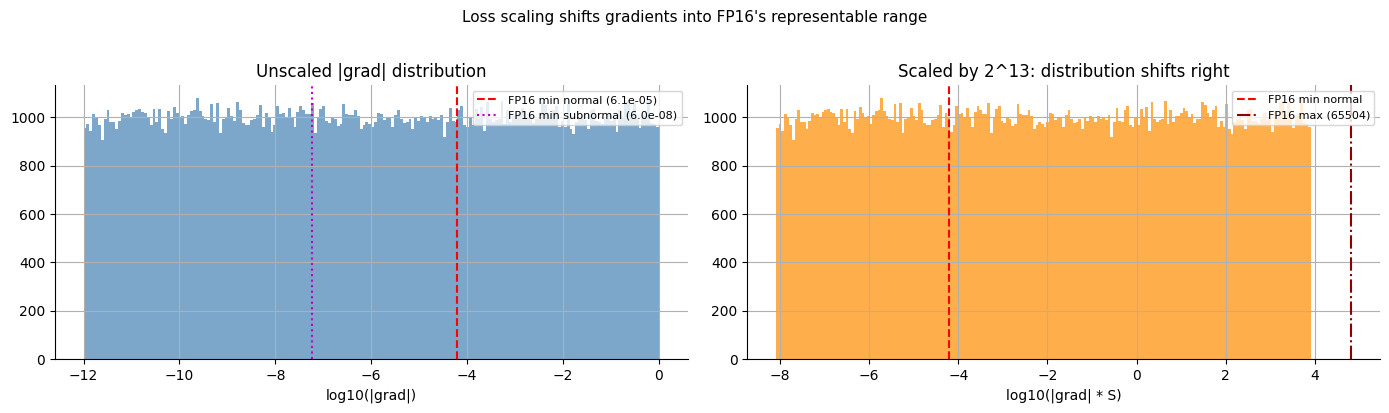

In [50]:
# Visualize gradient distribution vs FP16 thresholds

fi16 = torch.finfo(torch.float16)
min_normal = float(fi16.tiny)
min_sub = float(torch.nextafter(torch.tensor(0.0, dtype=torch.float16), torch.tensor(1.0, dtype=torch.float16)))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

vals = synthetic.abs().cpu().numpy()
axes[0].hist(np.log10(vals + 1e-30), bins=200, alpha=0.7, color="steelblue")
axes[0].axvline(np.log10(min_normal), color="r", ls="--", label=f"FP16 min normal ({min_normal:.1e})")
axes[0].axvline(np.log10(min_sub), color="m", ls=":", label=f"FP16 min subnormal ({min_sub:.1e})")
axes[0].set_title("Unscaled |grad| distribution")
axes[0].set_xlabel("log10(|grad|)")
axes[0].legend(fontsize=8)

# After scaling by 2^13
scaled_vals = (synthetic * 2**13).abs().cpu().numpy()
axes[1].hist(np.log10(scaled_vals + 1e-30), bins=200, alpha=0.7, color="darkorange")
axes[1].axvline(np.log10(min_normal), color="r", ls="--", label="FP16 min normal")
axes[1].axvline(np.log10(float(fi16.max)), color="darkred", ls="-.", label=f"FP16 max ({fi16.max:.0f})")
axes[1].set_title("Scaled by 2^13: distribution shifts right")
axes[1].set_xlabel("log10(|grad| * S)")
axes[1].legend(fontsize=8)

plt.suptitle("Loss scaling shifts gradients into FP16's representable range", fontsize=11, y=1.02)
plt.tight_layout();

### 3.4.1 Underflow in a real backward pass

Now we show the actual training failure mode with a tiny FP16 network.

In [51]:
# Real backward underflow demo

def tiny_backward(use_scaling, scale=2**13):
    model = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(device).half()
    x = (torch.randn(256, 128, device=device) * 1e-3).half()
    y = (torch.randn(256, 1, device=device) * 1e-3).half()
    pred = model(x)
    loss = ((pred - y)**2).mean()
    if use_scaling:
        (loss * scale).backward()
        for p in model.parameters():
            if p.grad is not None:
                p.grad.div_(scale)
    else:
        loss.backward()
    grads = torch.cat([p.grad.flatten().abs().float() for p in model.parameters() if p.grad is not None])
    return float(loss), float((grads == 0).float().mean()), float(grads.median()), grads

if device.type == "cuda":
    loss0, z0, med0, g0 = tiny_backward(use_scaling=False)
    loss1, z1, med1, g1 = tiny_backward(use_scaling=True)
    display(pd.DataFrame([
        {"setting": "FP16, no scaling", "loss": f"{loss0:.6f}", "zero_grad_frac": f"{z0:.3f}", "median|grad|": f"{med0:.2e}"},
        {"setting": "FP16, scaled+unscaled", "loss": f"{loss1:.6f}", "zero_grad_frac": f"{z1:.3f}", "median|grad|": f"{med1:.2e}"},
    ]))
else:
    print("Run on CUDA for the FP16 backward demo.")

,setting,loss,zero_grad_frac,median|grad|
0,"FP16, no scaling",0.006393,0.598,0.00e+00
1,"FP16, scaled+unscaled",0.003082,0.537,0.00e+00


### 3.4.2 The Micikevicius gradient histogram: where do real gradients live?

The Micikevicius paper's most famous figure shows a histogram of gradient magnitudes during FP32 training, overlaid with FP16's representable range. Let's reproduce this analysis with our model.

This visualization answers the question: *What fraction of the training signal would you lose by switching to FP16 or BF16?*


Gradients collected: 10,212,157
Fraction that would underflow in FP16: 0.4842 (48.42%)
Fraction that would underflow in BF16: 0.0000 (0.00%)

This is why FP16 needs loss scaling and BF16 usually doesn't.


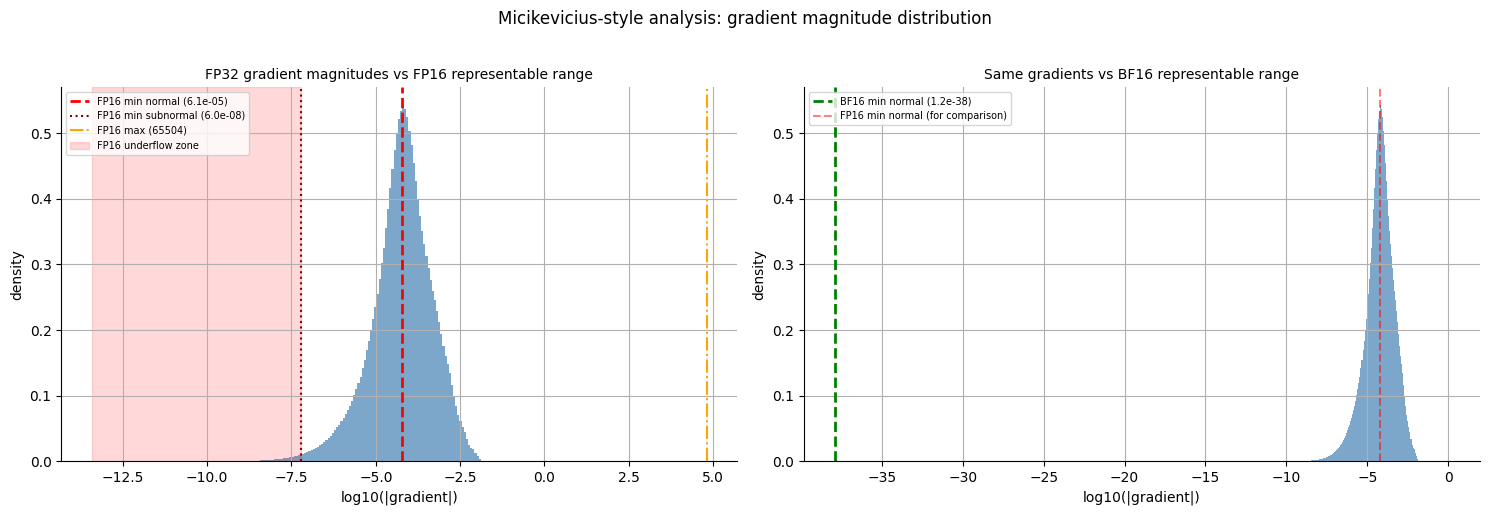

In [52]:
# Gradient histogram analysis (Micikevicius-style)

def collect_gradient_histogram(model_class, device, dtype=torch.float32, steps=20):
    # Collect all gradient values from several training steps.
    set_seed(42)
    model = model_class().to(device).to(dtype)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    all_grads = []

    for xb, yb in get_batches(steps):
        opt.zero_grad(set_to_none=True)
        pred = model(xb.to(dtype))
        loss = F.mse_loss(pred, yb.to(dtype))
        loss.backward()
        for p in model.parameters():
            if p.grad is not None:
                all_grads.append(p.grad.detach().float().flatten().cpu())
        opt.step()

    return torch.cat(all_grads)

grads_fp32 = collect_gradient_histogram(SimpleMLP, device, torch.float32, steps=30)
nonzero_grads = grads_fp32[grads_fp32 != 0]
log_abs_grads = torch.log10(nonzero_grads.abs()).numpy()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: gradient histogram with FP16 thresholds
ax = axes[0]
ax.hist(log_abs_grads, bins=200, alpha=0.7, color="steelblue", edgecolor="none", density=True)

fi16 = torch.finfo(torch.float16)
min_normal_16 = float(fi16.tiny)
min_sub_16 = float(torch.nextafter(torch.tensor(0.0, dtype=torch.float16), torch.tensor(1.0, dtype=torch.float16)))

ax.axvline(np.log10(min_normal_16), color="red", ls="--", lw=2, label=f"FP16 min normal ({min_normal_16:.1e})")
ax.axvline(np.log10(min_sub_16), color="darkred", ls=":", lw=1.5, label=f"FP16 min subnormal ({min_sub_16:.1e})")
ax.axvline(np.log10(float(fi16.max)), color="orange", ls="-.", lw=1.5, label=f"FP16 max ({fi16.max:.0f})")

# Shade the underflow zone
ax.axvspan(ax.get_xlim()[0], np.log10(min_sub_16), alpha=0.15, color="red", label="FP16 underflow zone")

ax.set_title("FP32 gradient magnitudes vs FP16 representable range", fontsize=10)
ax.set_xlabel("log10(|gradient|)")
ax.set_ylabel("density")
ax.legend(fontsize=7, loc="upper left")

# Right: same but with BF16 thresholds
ax = axes[1]
ax.hist(log_abs_grads, bins=200, alpha=0.7, color="steelblue", edgecolor="none", density=True)

fi_bf16 = torch.finfo(torch.bfloat16)
min_normal_bf16 = float(fi_bf16.tiny)

ax.axvline(np.log10(min_normal_bf16), color="green", ls="--", lw=2, label=f"BF16 min normal ({min_normal_bf16:.1e})")
ax.axvline(np.log10(min_normal_16), color="red", ls="--", lw=1.5, alpha=0.5, label=f"FP16 min normal (for comparison)")

ax.set_title("Same gradients vs BF16 representable range", fontsize=10)
ax.set_xlabel("log10(|gradient|)")
ax.set_ylabel("density")
ax.legend(fontsize=7, loc="upper left")

fig.suptitle("Micikevicius-style analysis: gradient magnitude distribution", fontsize=12, y=1.02)
plt.tight_layout()

# Quantify
fp16_underflow_frac = float((nonzero_grads.abs() < min_normal_16).float().mean())
bf16_underflow_frac = float((nonzero_grads.abs() < min_normal_bf16).float().mean())
print(f"\nGradients collected: {len(nonzero_grads):,}")
print(f"Fraction that would underflow in FP16: {fp16_underflow_frac:.4f} ({fp16_underflow_frac*100:.2f}%)")
print(f"Fraction that would underflow in BF16: {bf16_underflow_frac:.4f} ({bf16_underflow_frac*100:.2f}%)")
print(f"\nThis is why FP16 needs loss scaling and BF16 usually doesn't.")

### 3.4.2b Gradient distribution evolution: how the histogram shifts during training

The Micikevicius snapshot above is from early training. But gradient distributions **shift** as training progresses: early gradients tend to be larger (random initialization → big loss), late gradients tend to be smaller (convergence → tiny updates). This matters because FP16 underflow becomes *worse* as training proceeds.

Here we train TinyGPT for ~200 steps and capture full gradient snapshots at checkpoints, showing:
1. How the gradient distribution shifts leftward (toward smaller magnitudes) over training.
2. How a representative loss scale would shift that distribution into FP16's representable range.


Gradient evolution summary (FP16 thresholds):
  Step   0: 37.69% < min normal, 0.0453% < min subnormal
  Step  10: 38.08% < min normal, 0.0469% < min subnormal
  Step  50: 40.62% < min normal, 0.0563% < min subnormal
  Step 100: 51.34% < min normal, 0.0673% < min subnormal
  Step 200: 43.30% < min normal, 0.0531% < min subnormal

Takeaway: As training converges, more gradients move into FP16's low-magnitude region.
The orange overlay is a fixed-scale what-if (not dynamic GradScaler), showing why scaling helps.


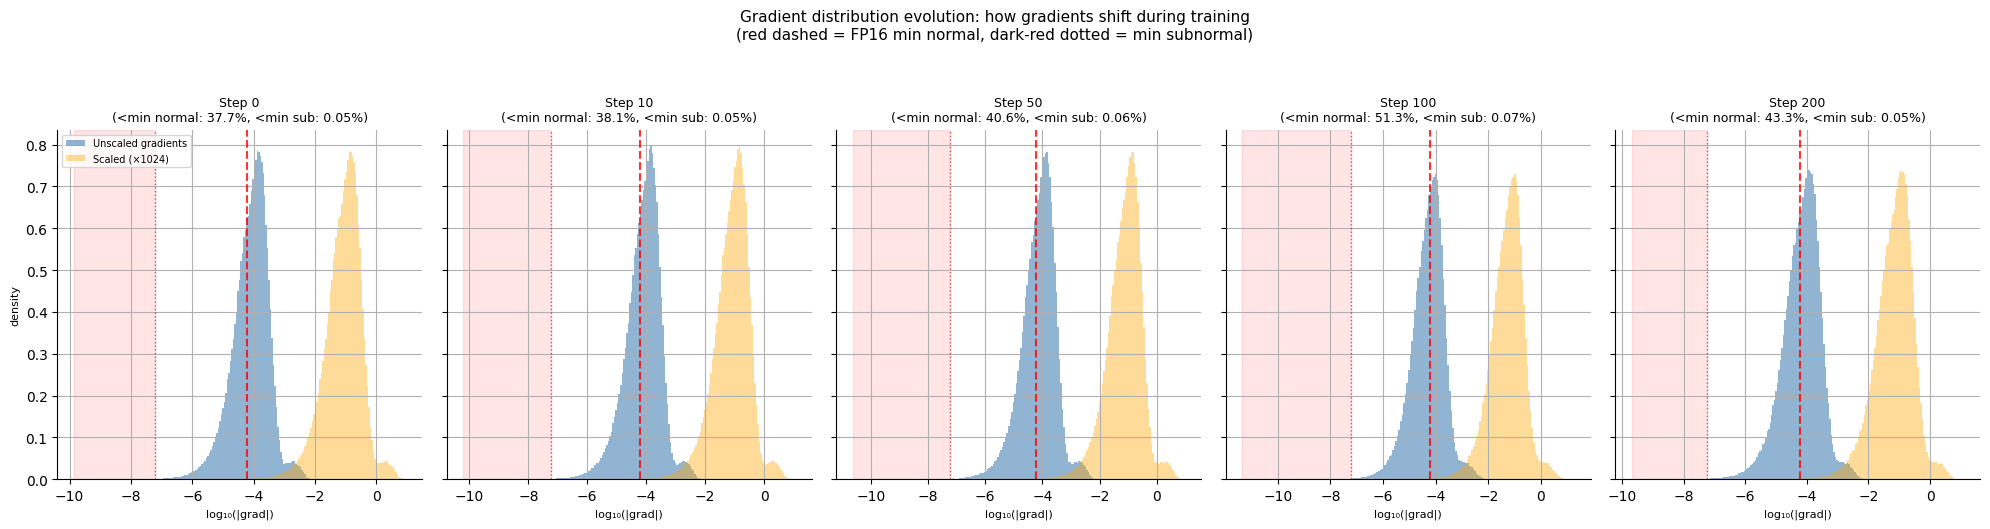

In [53]:
# Gradient distribution evolution over training

set_seed(42)

# Self-contained mini-corpus (avoids dependency on Section 3.6 data)
SNAP_STEPS = [0, 10, 50, 100, 200]
TOTAL_STEPS = max(SNAP_STEPS) + 1
BLOCK_EVO = 64
BATCH_EVO = 32
VOCAB_EVO = 128

train_data_evo = torch.randint(0, VOCAB_EVO, (BLOCK_EVO * BATCH_EVO * 10,), device=device)

model_evo = TinyGPT(vocab_size=VOCAB_EVO, block_size=BLOCK_EVO, n_layer=2,
                     n_embd=128, n_heads=4, dropout=0.0).to(device).float()
opt_evo = torch.optim.Adam(model_evo.parameters(), lr=3e-4)

grad_snapshots = {}
LOSS_SCALE_DEMO = 1024.0  # fixed scale for illustration

for step in range(TOTAL_STEPS):
    # Sample batch from self-contained mini-corpus
    max_start = train_data_evo.size(0) - BLOCK_EVO - 1
    ix = torch.randint(0, max_start, (BATCH_EVO,), device=device)
    offsets = torch.arange(BLOCK_EVO, device=device).unsqueeze(0)
    xb = train_data_evo[ix.unsqueeze(1) + offsets]
    yb = train_data_evo[ix.unsqueeze(1) + offsets + 1]

    opt_evo.zero_grad(set_to_none=True)
    logits_evo = model_evo(xb)
    loss_evo = F.cross_entropy(logits_evo.reshape(-1, logits_evo.size(-1)), yb.reshape(-1))
    loss_evo.backward()

    if step in SNAP_STEPS:
        all_g = torch.cat([p.grad.detach().float().flatten().cpu()
                           for p in model_evo.parameters() if p.grad is not None])
        grad_snapshots[step] = all_g

    opt_evo.step()

# Plot: one subplot per snapshot
n_snaps = len(grad_snapshots)
fig, axes = plt.subplots(1, n_snaps, figsize=(4 * n_snaps, 5), sharey=True)
if n_snaps == 1:
    axes = [axes]

fi16 = torch.finfo(torch.float16)
min_normal_fp16 = float(fi16.tiny)
min_sub_fp16 = float(torch.nextafter(torch.tensor(0.0, dtype=torch.float16),
                                       torch.tensor(1.0, dtype=torch.float16)))

for ax, (step, grads) in zip(axes, sorted(grad_snapshots.items())):
    nonzero = grads[grads != 0]
    if len(nonzero) == 0:
        continue
    log_abs = torch.log10(nonzero.abs()).numpy()

    # Unscaled distribution
    ax.hist(log_abs, bins=150, alpha=0.6, color="steelblue", edgecolor="none",
            density=True, label="Unscaled gradients")

    # Scaled distribution (shifted by log10(scale))
    log_abs_scaled = log_abs + np.log10(LOSS_SCALE_DEMO)
    ax.hist(log_abs_scaled, bins=150, alpha=0.4, color="orange", edgecolor="none",
            density=True, label=f"Scaled (×{LOSS_SCALE_DEMO:.0f})")

    # FP16 range markers
    ax.axvline(np.log10(min_normal_fp16), color="red", ls="--", lw=1.5, alpha=0.8)
    ax.axvline(np.log10(min_sub_fp16), color="darkred", ls=":", lw=1, alpha=0.6)
    ax.axvspan(ax.get_xlim()[0] if ax.get_xlim()[0] < np.log10(min_sub_fp16) else -20,
               np.log10(min_sub_fp16), alpha=0.1, color="red")

    # Fractions below FP16 thresholds
    below_normal = float((nonzero.abs() < min_normal_fp16).float().mean())
    true_underflow = float((nonzero.abs() < min_sub_fp16).float().mean())
    ax.set_title(
        f"Step {step}\n(<min normal: {below_normal*100:.1f}%, <min sub: {true_underflow*100:.2f}%)",
        fontsize=9,
    )
    ax.set_xlabel("log₁₀(|grad|)", fontsize=8)
    if ax == axes[0]:
        ax.set_ylabel("density", fontsize=8)

axes[0].legend(fontsize=7, loc="upper left")

fig.suptitle("Gradient distribution evolution: how gradients shift during training\n"
             f"(red dashed = FP16 min normal, dark-red dotted = min subnormal)",
             fontsize=11, y=1.05)
plt.tight_layout()

# Summary stats
print(f"\nGradient evolution summary (FP16 thresholds):")
for step, grads in sorted(grad_snapshots.items()):
    nonzero = grads[grads != 0]
    frac_below_normal = float((nonzero.abs() < min_normal_fp16).float().mean()) * 100
    frac_true_underflow = float((nonzero.abs() < min_sub_fp16).float().mean()) * 100
    print(f"  Step {step:>3d}: {frac_below_normal:.2f}% < min normal, {frac_true_underflow:.4f}% < min subnormal")
print(f"\nTakeaway: As training converges, more gradients move into FP16's low-magnitude region.")
print(f"The orange overlay is a fixed-scale what-if (not dynamic GradScaler), showing why scaling helps.")

del model_evo, opt_evo, train_data_evo

### 3.4.3 Dynamic loss scaling (GradScaler) in action

Loss scaling has two failure modes:

- **Scale too small** → doesn't rescue underflow (gradients still become 0 in FP16).
- **Scale too large** → causes overflow (gradients become `inf`/`nan`).

`GradScaler` automates this tradeoff: it tries to keep the scale as large as possible *without* overflow.

In this demo we intentionally start with an absurdly large scale to trigger overflows, and watch GradScaler back off and skip optimizer steps.

,step,loss(fp32),scale_before,found_inf,optimizer_step_ran,max_abs_grad(after_unscale),scale_after
0,0,8213332.0,65536.0,True,False,inf,32768.0
1,1,8213332.0,32768.0,True,False,inf,16384.0
2,2,8213332.0,16384.0,True,False,inf,8192.0
3,3,8213332.0,8192.0,True,False,inf,4096.0
4,4,8213332.0,4096.0,True,False,inf,2048.0
5,5,8213332.0,2048.0,True,False,inf,1024.0
6,6,8213332.0,1024.0,True,False,inf,512.0
7,7,8213332.0,512.0,True,False,inf,256.0
8,8,8213332.0,256.0,True,False,inf,128.0
9,9,8213332.0,128.0,True,False,inf,64.0


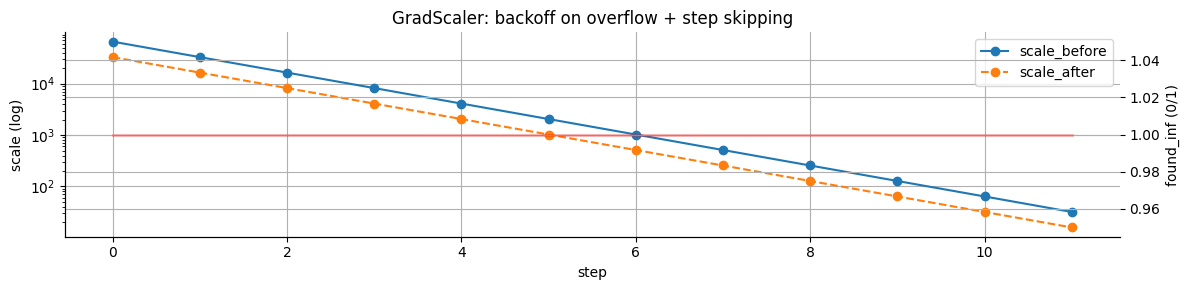

In [54]:
# GradScaler overflow + step skipping demo (CUDA only)

if device.type != "cuda":
    print("Run on CUDA to see GradScaler dynamically adjust scale and skip steps.")
else:
    set_seed(0)
    torch.cuda.synchronize()

    model = nn.Linear(256, 256, bias=False).to(device).float()
    opt = torch.optim.SGD(model.parameters(), lr=1e-3)

    # Large inputs to create large (but finite) gradients.
    x = (torch.randn(256, 256, device=device) * 5000).float()

    try:
        scaler = GradScaler(
            init_scale=2**16,
            growth_factor=2.0,
            backoff_factor=0.5,
            growth_interval=2,
            enabled=True,
        )
    except TypeError:
        scaler = GradScaler(enabled=True)
        print("[warn] GradScaler init args not supported on this version; using defaults.")

    logs = []
    for step in range(12):
        opt.zero_grad(set_to_none=True)
        scale_before = float(scaler.get_scale()) if hasattr(scaler, "get_scale") else float("nan")

        with amp_autocast(device, torch.float16, enabled=True):
            y = model(x)  # FP16 matmul compute under autocast
            # Force loss computation in FP32 to avoid forward overflow; we want overflow from scaling.
            loss = (y.float() ** 2).mean()

        scaler.scale(loss).backward()

        # Unscale so we can inspect gradients in their true magnitude (and clip here if desired).
        scaler.unscale_(opt)
        grads = [p.grad for p in model.parameters() if p.grad is not None]
        found_inf = bool(any((~torch.isfinite(g)).any().item() for g in grads))
        max_abs_grad = float(torch.stack([g.detach().abs().max() for g in grads]).max())

        w_before = model.weight.detach().float().clone()
        scaler.step(opt)     # skipped if found_inf=True
        scaler.update()
        w_after = model.weight.detach().float()

        scale_after = float(scaler.get_scale()) if hasattr(scaler, "get_scale") else float("nan")
        step_ran = bool((w_after - w_before).abs().max().item() != 0.0)

        logs.append({
            "step": step,
            "loss(fp32)": float(loss.detach().cpu()),
            "scale_before": scale_before,
            "found_inf": found_inf,
            "optimizer_step_ran": step_ran,
            "max_abs_grad(after_unscale)": max_abs_grad,
            "scale_after": scale_after,
        })

    df = pd.DataFrame(logs)
    display(df)

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(df["step"], df["scale_before"], marker="o", label="scale_before")
    ax.plot(df["step"], df["scale_after"], marker="o", ls="--", label="scale_after")
    ax.set_yscale("log")
    ax.set_xlabel("step")
    ax.set_ylabel("scale (log)")
    ax.set_title("GradScaler: backoff on overflow + step skipping")
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(df["step"], df["found_inf"].astype(int), color="red", alpha=0.3, lw=2, label="found_inf")
    ax2.set_ylabel("found_inf (0/1)")
    plt.tight_layout();

## 3.5 Weight update stagnation (why FP32 master weights matter)

Even if you avoid underflow, you can lose learning signal if weight updates are **below the ULP** of the weight's dtype.

If $w \approx 1$ in FP16, the ULP is ~$10^{-3}$. Any update $\Delta w < 10^{-3}$ is rounded away.

In [55]:
# Weight stagnation demo

def apply_updates(dtype, w0=1.0, delta=1e-5, steps=2000):
    w = torch.tensor(w0, dtype=dtype)
    changed = 0
    for _ in range(steps):
        w_new = w - torch.tensor(delta, dtype=dtype)
        changed += int(w_new.item() != w.item())
        w = w_new
    return {
        "dtype": str(dtype),
        "w0": w0,
        "delta": f"{delta:.0e}",
        "steps": steps,
        "steps_where_w_changed": changed,
        "final_w": f"{float(w):.6f}",
        "expected_final": f"{w0 - delta * steps:.6f}",
        "ulp_at_1.0": f"{_ulp_at_one(dtype):.2e}",
    }

rows = [apply_updates(dt) for dt in [torch.float16, torch.bfloat16, torch.float32]]
display(pd.DataFrame(rows))

print("\nFP16: delta=1e-5 is below ULP at 1.0 (~1e-3). Weight NEVER changes.")
print("BF16: delta=1e-5 is below ULP at 1.0 (~8e-3). Weight NEVER changes.")
print("FP32: delta=1e-5 is above ULP at 1.0 (~1e-7). Weight changes every step.")
print("\nThis is why optimizers need FP32 master weights.")

,dtype,w0,delta,steps,steps_where_w_changed,final_w,expected_final,ulp_at_1.0
0,torch.float16,1.0,1e-05,2000,0,1.000000,0.980000,9.77e-04
1,torch.bfloat16,1.0,1e-05,2000,0,1.000000,0.980000,7.81e-03
2,torch.float32,1.0,1e-05,2000,2000,0.979973,0.980000,1.19e-07



FP16: delta=1e-5 is below ULP at 1.0 (~1e-3). Weight NEVER changes.
BF16: delta=1e-5 is below ULP at 1.0 (~8e-3). Weight NEVER changes.
FP32: delta=1e-5 is above ULP at 1.0 (~1e-7). Weight changes every step.

This is why optimizers need FP32 master weights.


### 3.5.1 Stochastic rounding micro-demo (why low-precision rounding mode matters)

Section 2 introduced the idea from Gupta et al.: deterministic rounding can bias tiny updates toward zero, while stochastic rounding is unbiased in expectation.

This demo intentionally uses an update (`1e-4`) below FP16's ULP at `1.0` (~`1e-3`) to show the behavior directly.

In [56]:
# Stochastic rounding demo: accumulate tiny updates in FP16

def stochastic_round_fp16(x_fp32):
    # Round FP32 value to FP16 with stochastic rounding.
    x_lo = torch.tensor(float(x_fp32), dtype=torch.float16).float()
    x_hi = torch.nextafter(
        torch.tensor(float(x_fp32), dtype=torch.float16),
        torch.tensor(float("inf"), dtype=torch.float16),
    ).float()
    if float(x_hi) == float(x_lo):
        return torch.tensor(float(x_lo), dtype=torch.float16)
    p_up = (x_fp32 - x_lo) / (x_hi - x_lo + 1e-30)
    p_up = float(p_up.clamp(0, 1))
    if random.random() < p_up:
        return torch.tensor(float(x_hi), dtype=torch.float16)
    return torch.tensor(float(x_lo), dtype=torch.float16)

delta = 1e-4
N = 5000
expected = 1.0 + delta * N

# Deterministic FP16 rounding
w_det = torch.tensor(1.0, dtype=torch.float16)
for _ in range(N):
    w_det = (w_det.float() + delta).half()

# Stochastic FP16 rounding
set_seed(42)
w_stoch = torch.tensor(1.0, dtype=torch.float16)
for _ in range(N):
    w_stoch = stochastic_round_fp16(w_stoch.float() + delta)

# FP32 reference
w_fp32 = torch.tensor(1.0, dtype=torch.float32)
for _ in range(N):
    w_fp32 = w_fp32 + delta

print(f"Accumulating {N} updates of delta={delta} from 1.0")
print(f"Expected: {expected:.6f}")
print(f"  FP16 deterministic: {float(w_det):.6f}  (error: {abs(float(w_det) - expected):.4e})")
print(f"  FP16 stochastic:    {float(w_stoch):.6f}  (error: {abs(float(w_stoch) - expected):.4e})")
print(f"  FP32 deterministic: {float(w_fp32):.6f}  (error: {abs(float(w_fp32) - expected):.4e})")
print()
print("Deterministic FP16 rounds each tiny update away. Stochastic FP16 preserves")
print("the update in expectation. AMP avoids this in practice by updating in FP32.")

Accumulating 5000 updates of delta=0.0001 from 1.0
Expected: 1.500000
  FP16 deterministic: 1.000000  (error: 5.0000e-01)
  FP16 stochastic:    1.485352  (error: 1.4648e-02)
  FP32 deterministic: 1.500083  (error: 8.2970e-05)

Deterministic FP16 rounds each tiny update away. Stochastic FP16 preserves
the update in expectation. AMP avoids this in practice by updating in FP32.


## 3.6 The main event: train a tiny causal LM under different precision regimes

We'll train TinyGPT on a character-level next-token prediction task using an in-notebook corpus.

**Why character-level?** No external downloads, stable, deterministic, and still exercises the transformer mechanics that matter for autocast (attention, layernorm, softmax, embeddings).

**We will compare (device-dependent):**
- **Always:** FP32 baseline
- **CUDA:** (optional) **strict FP32 baseline** vs **TF32-allowed FP32** + naive FP16/BF16 (cast-everything baselines) + AMP FP16 (with GradScaler) + AMP BF16 (if supported)
- **CPU:** BF16 autocast (numerics-focused; speedups vary by CPU/kernel support)
- **MPS:** FP16 autocast (+ BF16 autocast if your MPS backend supports it)

Before the full training suite, we'll also do:
- A **single-batch numerical drift** comparison: FP32 vs autocast (loss + gradient deltas).
- A qualitative **text-generation sanity check** from each successfully trained regime.

**We will log:**
- Training loss
- Validation loss
- Gradient norm + exact-zero gradient fraction (underflow proxy)
- Step time + throughput (tokens/s)
- CUDA peak memory (if CUDA)
- GradScaler scale (for FP16 AMP)

Implementation detail: we keep the tokenized corpus on the selected device and sample batches with vectorized indexing, so the step-time graphs are not dominated by Python loops or host→device copies.

In [57]:
# Tiny corpus + character-level tokenizer

from pathlib import Path
import re

# Use the repo's reference material as training text (no external downloads).
# Falls back to a small built-in corpus if the files aren't present.
FALLBACK_LINES = [
    "Autocast is not a global cast: it is an operator policy that routes each operation to the right precision.",
    "Matmuls/linears are the primary AMP targets because they map cleanly to Tensor Cores with FP32 accumulation.",
    "Softmax, layer normalization, exp/log, and many reductions are numerically sensitive and often run in FP32.",
    "FP16 has narrow exponent range → gradient underflow; BF16 keeps FP32 exponent range → underflow is rare.",
    "GradScaler implements dynamic loss scaling: scale loss → backward → unscale grads → step → update scale.",
]

def _read_text(path: str) -> str | None:
    try:
        return Path(path).read_text(encoding="utf-8")
    except Exception:
        return None

sources_used = []
parts = []
for p in ["sources/source4.md", "sources/source5.md"]:
    t = _read_text(p)
    if t:
        parts.append(t)
        sources_used.append(p)

raw = "\n".join(FALLBACK_LINES).strip()
if parts:
    raw = raw + "\n\n" + "\n\n".join(parts)

# Minimal cleanup: remove code fences (if any) and normalize whitespace.
raw = raw.replace("\r\n", "\n")
raw = re.sub(r"```.*?```", "", raw, flags=re.S)
raw = re.sub(r"[ \t]+", " ", raw)
raw = re.sub(r"\n{3,}", "\n\n", raw)
corpus = raw.strip()

# Keep runtime predictable: cap corpus size and repeat if too small.
TARGET_CHARS = 120_000
if len(corpus) < TARGET_CHARS:
    repeats = (TARGET_CHARS // max(len(corpus), 1)) + 1
    corpus = ((corpus + "\n") * repeats)[:TARGET_CHARS]
else:
    corpus = corpus[:TARGET_CHARS]

chars = sorted(set(corpus))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(chars)

def encode(s):
    return [stoi[c] for c in s]

def decode_tokens(ids):
    return "".join(itos[i] for i in ids)

data = torch.tensor(encode(corpus), dtype=torch.long).to(device)
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]

print(f"Vocab size: {vocab_size}")
print(f"Train tokens: {len(train_data):,}, Val tokens: {len(val_data):,}")
print(f"Corpus sources used: {sources_used if sources_used else ['fallback_only']}")
print(f"Sample: {decode_tokens(train_data[:80].tolist())}")

Vocab size: 45
Train tokens: 108,000, Val tokens: 12,000
Corpus sources used: ['fallback_only']
Sample: Autocast is not a global cast: it is an operator policy that routes each operati


In [58]:
# Batch sampling + evaluation

def get_batch(split, batch_size, block_size):
    # Vectorized slicing (no Python loops) and stays on `device`.
    src = train_data if split == "train" else val_data
    max_start = src.size(0) - block_size - 1
    ix = torch.randint(0, max_start, (batch_size,), device=src.device)
    offsets = torch.arange(block_size, device=src.device).unsqueeze(0)
    x = src[ix.unsqueeze(1) + offsets]
    y = src[ix.unsqueeze(1) + offsets + 1]
    return x, y

@torch.no_grad()
def estimate_loss(model, block_size, batch_size, iters=20, use_autocast=False, amp_dtype=None):
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = []
        for _ in range(iters):
            x, y = get_batch(split, batch_size, block_size)
            with amp_autocast(device, amp_dtype, enabled=use_autocast):
                logits = model(x)
                loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
            losses.append(float(loss))
        out[split] = float(np.mean(losses))
    model.train()
    return out

### 3.6.0 A microscope view: what autocast changes numerically (one fixed batch)

Before we look at full training curves, let's make autocast *concrete*:

- Take the **same** model initialization and the **same** batch.
- Compute loss + gradients in strict **FP32**.
- Compute loss + gradients under **autocast** (FP16/BF16) with **FP32 parameters** (the usual AMP setup).
- Quantify the deltas.

This is the most direct way to understand "mixed precision": it introduces **small, structured numerical error** in specific parts of the forward/backward graph. The goal of AMP is not "no error" — it's "bounded error that doesn't break training, in exchange for speed/memory gains".

Reference FP32 loss: 3.991633


,amp_dtype,status,loss_amp,loss_abs_diff,loss_rel_diff,grad_rel_l2,grad_cosine,param_rel_l2_median,param_rel_l2_p90,param_rel_l2_max
0,float16,ok,3.991684,0.000051,0.000013,0.000420,1.000004,0.000456,0.001466,0.001554
1,bfloat16,ok,3.991638,0.000005,0.000001,0.002971,0.999999,0.003720,0.004505,0.004594



Top gradient-relative-error parameters for autocast(float16) vs FP32:


,param,ref_norm,rel_l2,max_abs_diff
3,blocks.0.ln1.weight,0.006302,0.001554,0.000002
5,blocks.0.ln2.weight,0.007362,0.001547,0.000003
11,blocks.1.attn.qkv.weight,0.123513,0.001495,0.000005
13,blocks.1.ln1.weight,0.006023,0.001423,0.000002
15,blocks.1.ln2.weight,0.006952,0.001384,0.000002
1,blocks.0.attn.qkv.weight,0.141314,0.001296,0.000005
7,blocks.0.mlp.0.weight,0.133594,0.000793,0.000002
17,blocks.1.mlp.0.weight,0.129916,0.000773,0.000002
14,blocks.1.ln2.bias,0.014804,0.000758,0.000003
4,blocks.0.ln2.bias,0.015263,0.000655,0.000002



Top gradient-relative-error parameters for autocast(bfloat16) vs FP32:


,param,ref_norm,rel_l2,max_abs_diff
17,blocks.1.mlp.0.weight,0.129916,0.004594,0.000015
7,blocks.0.mlp.0.weight,0.133594,0.004590,0.000015
5,blocks.0.ln2.weight,0.007362,0.004579,0.000009
13,blocks.1.ln1.weight,0.006023,0.004395,0.000008
15,blocks.1.ln2.weight,0.006952,0.004373,0.000006
11,blocks.1.attn.qkv.weight,0.123513,0.004183,0.000022
9,blocks.0.mlp.2.weight,0.331885,0.003940,0.000033
19,blocks.1.mlp.2.weight,0.322262,0.003903,0.000038
3,blocks.0.ln1.weight,0.006302,0.003899,0.000007
4,blocks.0.ln2.bias,0.015263,0.003888,0.000011


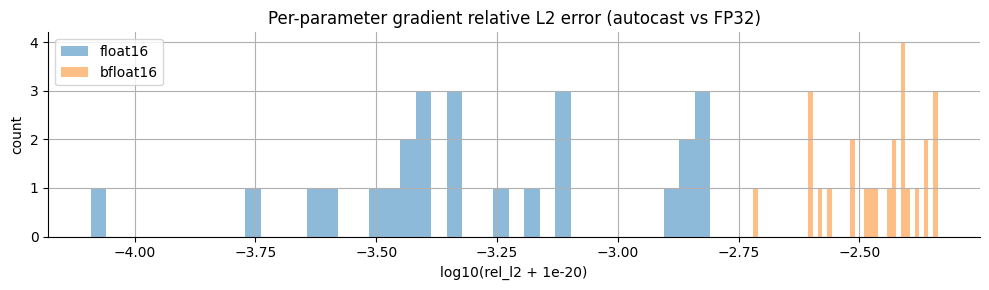

In [59]:
# Single-batch numerical drift: FP32 vs autocast
import copy

set_seed(123)

# A tiny fixed batch to make this fast and deterministic.
DRIFT_BS = 4
DRIFT_BLOCK = 64
x_drift, y_drift = get_batch("train", DRIFT_BS, DRIFT_BLOCK)

base = TinyGPT(
    vocab_size=vocab_size,
    block_size=DRIFT_BLOCK,
    n_layer=2,
    n_embd=128,
    n_heads=4,
    dropout=0.0,
).to(device).float()

def loss_and_grads(model, x, y, use_autocast=False, amp_dtype=None):
    for p in model.parameters():
        p.grad = None
    with amp_autocast(device, amp_dtype, enabled=use_autocast):
        logits = model(x)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
    loss.backward()
    grads = {n: p.grad.detach().float().cpu().clone() for n, p in model.named_parameters() if p.grad is not None}
    return float(loss.detach().cpu()), grads

loss_fp32, grads_fp32 = loss_and_grads(base, x_drift, y_drift, use_autocast=False, amp_dtype=None)

def compare_grads(grads_ref, grads_test):
    names = sorted(grads_ref.keys())
    v0 = torch.cat([grads_ref[n].flatten() for n in names])
    v1 = torch.cat([grads_test[n].flatten() for n in names])
    rel_l2 = float((v1 - v0).norm() / (v0.norm() + 1e-12))
    cos = float(F.cosine_similarity(v0, v1, dim=0))

    per_param = []
    for n in names:
        g0 = grads_ref[n]
        g1 = grads_test[n]
        denom = float(g0.norm()) + 1e-12
        per_param.append({
            "param": n,
            "ref_norm": float(g0.norm()),
            "rel_l2": float((g1 - g0).norm() / denom),
            "max_abs_diff": float((g1 - g0).abs().max()),
        })
    df = pd.DataFrame(per_param)
    summary = {
        "grad_rel_l2": rel_l2,
        "grad_cosine": cos,
        "param_rel_l2_median": float(df["rel_l2"].median()),
        "param_rel_l2_p90": float(df["rel_l2"].quantile(0.90)),
        "param_rel_l2_max": float(df["rel_l2"].max()),
    }
    return df, summary

candidates = []
for dt in [torch.float16, torch.bfloat16]:
    if dt is torch.float16 and device.type == "cpu":
        continue
    if device.type == "cuda" and dt is torch.bfloat16 and not torch.cuda.is_bf16_supported():
        continue
    if not supports_dtype_on_device(dt, device):
        continue
    candidates.append(dt)

rows = []
per_param_dfs = {}

print(f"Reference FP32 loss: {loss_fp32:.6f}")

for amp_dt in candidates:
    name = str(amp_dt).replace("torch.", "")
    try:
        m = copy.deepcopy(base)
        loss_amp, grads_amp = loss_and_grads(m, x_drift, y_drift, use_autocast=True, amp_dtype=amp_dt)
        df_param, s = compare_grads(grads_fp32, grads_amp)
        per_param_dfs[name] = df_param
        rows.append({
            "amp_dtype": name,
            "status": "ok",
            "loss_amp": loss_amp,
            "loss_abs_diff": abs(loss_amp - loss_fp32),
            "loss_rel_diff": abs(loss_amp - loss_fp32) / max(abs(loss_fp32), 1e-12),
            **s,
        })
    except Exception as e:
        rows.append({
            "amp_dtype": name,
            "status": f"failed: {type(e).__name__}",
            "loss_amp": float("nan"),
            "loss_abs_diff": float("nan"),
            "loss_rel_diff": float("nan"),
            "grad_rel_l2": float("nan"),
            "grad_cosine": float("nan"),
            "param_rel_l2_median": float("nan"),
            "param_rel_l2_p90": float("nan"),
            "param_rel_l2_max": float("nan"),
        })
        print(f"[warn] autocast drift compare failed for {amp_dt}: {e}")

df = pd.DataFrame(rows)
display(df)

for amp_name, df_param in per_param_dfs.items():
    print(f"\nTop gradient-relative-error parameters for autocast({amp_name}) vs FP32:")
    display(df_param.sort_values('rel_l2', ascending=False).head(10))

if per_param_dfs:
    plt.figure(figsize=(10, 3))
    for amp_name, df_param in per_param_dfs.items():
        plt.hist(np.log10(df_param["rel_l2"].to_numpy() + 1e-20), bins=40, alpha=0.5, label=amp_name)
    plt.title("Per-parameter gradient relative L2 error (autocast vs FP32)")
    plt.xlabel("log10(rel_l2 + 1e-20)")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout();

In [60]:
# Training infrastructure

@dataclass
class TrainConfig:
    name: str
    steps: int = 200
    batch_size: int = 32
    block_size: int = 64
    lr: float = 3e-4
    weight_decay: float = 0.0
    use_autocast: bool = False
    amp_dtype: torch.dtype = None
    use_grad_scaler: bool = False
    param_dtype: torch.dtype = torch.float32
    # CUDA only: control whether float32 matmuls are allowed to use TF32 internally.
    # None = leave current global setting unchanged.
    allow_tf32: bool | None = None
    eval_interval: int = 50
    eval_iters: int = 10

def global_grad_norm(model):
    total_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_sq += float(p.grad.detach().float().norm())**2
    return math.sqrt(total_sq)

def global_zero_grad_frac(model):
    zeros = 0
    total = 0
    for p in model.parameters():
        if p.grad is None:
            continue
        g = p.grad.detach()
        zeros += int((g == 0).sum())
        total += g.numel()
    return zeros / max(total, 1)

def train_one(cfg):
    set_seed(42)
    tf32_matmul_orig = None
    tf32_cudnn_orig = None
    if device.type == "cuda" and cfg.allow_tf32 is not None:
        tf32_matmul_orig = torch.backends.cuda.matmul.allow_tf32
        tf32_cudnn_orig = torch.backends.cudnn.allow_tf32
        torch.backends.cuda.matmul.allow_tf32 = bool(cfg.allow_tf32)
        torch.backends.cudnn.allow_tf32 = bool(cfg.allow_tf32)

    try:
        model = TinyGPT(
            vocab_size=vocab_size, block_size=cfg.block_size,
            n_layer=2, n_embd=128, n_heads=4, dropout=0.0,
        ).to(device).to(cfg.param_dtype)

        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        scaler = GradScaler(enabled=True) if (cfg.use_grad_scaler and device.type == "cuda") else None

        logs = {
            "step": [], "train_loss": [], "grad_norm": [], "zero_grad_frac": [],
            "step_time_ms": [], "tokens_per_s": [], "scale": [],
            "cuda_mem_mb": [], "val_step": [], "val_loss": [],
        }
        status = "ok"
        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats()

        tokens_per_step = cfg.batch_size * cfg.block_size

        pbar = tqdm(range(cfg.steps), desc=cfg.name, leave=False, unit="step")
        for step in pbar:
            # GPU kernels are async; synchronize so step_time_ms reflects actual compute.
            if device.type == "cuda":
                torch.cuda.synchronize()
            t0 = time.perf_counter()
            x, y = get_batch("train", cfg.batch_size, cfg.block_size)
            optimizer.zero_grad(set_to_none=True)

            with amp_autocast(device, cfg.amp_dtype, enabled=cfg.use_autocast):
                logits = model(x)
                loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

            if not torch.isfinite(loss):
                status = "non_finite_loss"
                break

            if scaler is None:
                loss.backward()
                grad_norm = global_grad_norm(model)
                zero_frac = global_zero_grad_frac(model)
                optimizer.step()
                scale_val = float("nan")
            else:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                grad_norm = global_grad_norm(model)
                zero_frac = global_zero_grad_frac(model)
                scaler.step(optimizer)
                scaler.update()
                scale_val = float(scaler.get_scale())

            if device.type == "cuda":
                torch.cuda.synchronize()
            dt = max(time.perf_counter() - t0, 1e-12)
            logs["step"].append(step)
            logs["train_loss"].append(float(loss))
            logs["grad_norm"].append(float(grad_norm))
            logs["zero_grad_frac"].append(float(zero_frac))
            logs["step_time_ms"].append(dt * 1000)
            logs["tokens_per_s"].append(tokens_per_step / dt)
            logs["scale"].append(scale_val)
            logs["cuda_mem_mb"].append(torch.cuda.max_memory_allocated() / 1024**2 if device.type == "cuda" else float("nan"))

            # Update progress bar with live metrics
            pbar.set_postfix(loss=f"{float(loss):.3f}", tok_s=f"{tokens_per_step / dt:.0f}")

            if cfg.eval_interval and (step % cfg.eval_interval == 0 or step == cfg.steps - 1):
                try:
                    ev = estimate_loss(
                        model,
                        cfg.block_size,
                        cfg.batch_size,
                        cfg.eval_iters,
                        use_autocast=cfg.use_autocast,
                        amp_dtype=cfg.amp_dtype,
                    )
                    logs["val_step"].append(step)
                    logs["val_loss"].append(ev["val"])
                except Exception:
                    logs["val_step"].append(step)
                    logs["val_loss"].append(float("nan"))

        pbar.close()

        # Save final weights for downstream analysis (e.g., text generation).
        # Store as FP32 on CPU for portability and to avoid holding multiple GPU copies.
        state_dict_fp32 = {k: v.detach().float().cpu() for k, v in model.state_dict().items()}
        return {"config": cfg, "status": status, "logs": logs, "state_dict": state_dict_fp32}
    finally:
        if device.type == "cuda" and cfg.allow_tf32 is not None:
            torch.backends.cuda.matmul.allow_tf32 = tf32_matmul_orig
            torch.backends.cudnn.allow_tf32 = tf32_cudnn_orig

In [61]:
# Define experiment suite

FAST_DEV_RUN = (device.type != "cuda")
BASE_STEPS = 60 if FAST_DEV_RUN else 300

INCLUDE_STRICT_FP32_BASELINE = (device.type == "cuda")

suite = []
if device.type == "cuda":
    # Make the "FP32 baseline" explicit: on Ampere+ GPUs, this typically means TF32 is allowed for matmuls.
    suite.append(TrainConfig(name="fp32", steps=BASE_STEPS, param_dtype=torch.float32, allow_tf32=True))
    if INCLUDE_STRICT_FP32_BASELINE:
        suite.append(TrainConfig(name="fp32_strict", steps=BASE_STEPS, param_dtype=torch.float32, allow_tf32=False))
else:
    suite.append(TrainConfig(name="fp32", steps=BASE_STEPS, param_dtype=torch.float32))

if device.type == "cuda":
    suite.append(TrainConfig(
        name="fp16_naive", steps=BASE_STEPS,
        param_dtype=torch.float16,
    ))
    if torch.cuda.is_bf16_supported():
        suite.append(TrainConfig(
            name="bf16_naive", steps=BASE_STEPS,
            param_dtype=torch.bfloat16,
        ))
    suite.append(TrainConfig(
        name="amp_fp16_no_scaler", steps=BASE_STEPS,
        use_autocast=True, amp_dtype=torch.float16,
        use_grad_scaler=False, param_dtype=torch.float32,
    ))
    suite.append(TrainConfig(
        name="amp_fp16", steps=BASE_STEPS,
        use_autocast=True, amp_dtype=torch.float16,
        use_grad_scaler=True, param_dtype=torch.float32,
    ))
    if torch.cuda.is_bf16_supported():
        suite.append(TrainConfig(
            name="amp_bf16", steps=BASE_STEPS,
            use_autocast=True, amp_dtype=torch.bfloat16,
            param_dtype=torch.float32,
        ))
elif device.type == "cpu":
    suite.append(TrainConfig(
        name="amp_bf16_cpu", steps=BASE_STEPS,
        use_autocast=True, amp_dtype=torch.bfloat16,
        param_dtype=torch.float32,
    ))
elif device.type == "mps":
    if supports_dtype_on_device(torch.float16, device):
        suite.append(TrainConfig(
            name="amp_fp16_mps", steps=BASE_STEPS,
            use_autocast=True, amp_dtype=torch.float16,
            use_grad_scaler=False, param_dtype=torch.float32,
        ))
    if supports_dtype_on_device(torch.bfloat16, device):
        suite.append(TrainConfig(
            name="amp_bf16_mps", steps=BASE_STEPS,
            use_autocast=True, amp_dtype=torch.bfloat16,
            use_grad_scaler=False, param_dtype=torch.float32,
        ))

print("Planned experiments:")
for cfg in suite:
    tf32 = f", tf32={cfg.allow_tf32}" if device.type == "cuda" else ""
    print(f"  {cfg.name}: params={cfg.param_dtype}, autocast={cfg.use_autocast} {cfg.amp_dtype}, scaler={cfg.use_grad_scaler}{tf32}")

Planned experiments:
  fp32: params=torch.float32, autocast=False None, scaler=False, tf32=True
  fp32_strict: params=torch.float32, autocast=False None, scaler=False, tf32=False
  fp16_naive: params=torch.float16, autocast=False None, scaler=False, tf32=None
  bf16_naive: params=torch.bfloat16, autocast=False None, scaler=False, tf32=None
  amp_fp16_no_scaler: params=torch.float32, autocast=True torch.float16, scaler=False, tf32=None
  amp_fp16: params=torch.float32, autocast=True torch.float16, scaler=True, tf32=None
  amp_bf16: params=torch.float32, autocast=True torch.bfloat16, scaler=False, tf32=None


In [62]:
# Run all experiments

def _empty_logs():
    return {
        "step": [], "train_loss": [], "grad_norm": [], "zero_grad_frac": [],
        "step_time_ms": [], "tokens_per_s": [], "scale": [],
        "cuda_mem_mb": [], "val_step": [], "val_loss": [],
    }

def _safe_ppl(loss):
    try:
        return float(math.exp(float(loss)))
    except OverflowError:
        return float("inf")

results = []
suite_pbar = tqdm(suite, desc="Experiment suite", unit="exp")
for cfg in suite_pbar:
    suite_pbar.set_description(f"Running: {cfg.name}")
    try:
        res = train_one(cfg)
        print(f"  {cfg.name}: status={res['status']}, steps={len(res['logs']['step'])}", end="")
        if res['logs']['train_loss']:
            print(f", final_loss={res['logs']['train_loss'][-1]:.4f}")
        else:
            print()
        results.append(res)
    except Exception as e:
        print(f"  {cfg.name}: exception: {type(e).__name__}: {e}")
        results.append({
            "config": cfg,
            "status": f"exception: {type(e).__name__}",
            "logs": _empty_logs(),
            "state_dict": None,
        })

# Summary table
summary_rows = []
for r in results:
    cfg, logs = r["config"], r["logs"]
    n = len(logs["step"])
    final_train_loss = logs["train_loss"][-1] if n else None
    final_val_loss = logs["val_loss"][-1] if logs["val_loss"] else None
    summary_rows.append({
        "name": cfg.name,
        "status": r["status"],
        "allow_tf32": (cfg.allow_tf32 if device.type == "cuda" else "n/a"),
        "steps": n,
        "final_train_loss": f"{final_train_loss:.4f}" if final_train_loss is not None else "n/a",
        "final_train_ppl": f"{_safe_ppl(final_train_loss):.2f}" if final_train_loss is not None else "n/a",
        "final_val_loss": f"{final_val_loss:.4f}" if final_val_loss is not None else "n/a",
        "final_val_ppl": f"{_safe_ppl(final_val_loss):.2f}" if final_val_loss is not None else "n/a",
        "mean_step_ms": f"{np.mean(logs['step_time_ms']):.1f}" if n else "n/a",
        "mean_tok/s": f"{np.mean(logs['tokens_per_s']):.0f}" if n else "n/a",
        "peak_cuda_MB": f"{np.nanmax(logs['cuda_mem_mb']):.1f}" if device.type == "cuda" and n else "n/a",
    })

print("\n\n=== Summary ===")
display(pd.DataFrame(summary_rows))

Experiment suite:   0%|          | 0/7 [00:00<?, ?exp/s]

fp32:   0%|          | 0/300 [00:00<?, ?step/s]

  fp32: status=ok, steps=300, final_loss=0.9076


fp32_strict:   0%|          | 0/300 [00:00<?, ?step/s]

  fp32_strict: status=ok, steps=300, final_loss=0.9076


fp16_naive:   0%|          | 0/300 [00:00<?, ?step/s]

  fp16_naive: status=non_finite_loss, steps=1, final_loss=3.9668


bf16_naive:   0%|          | 0/300 [00:00<?, ?step/s]

  bf16_naive: status=ok, steps=300, final_loss=1.2812


amp_fp16_no_scaler:   0%|          | 0/300 [00:00<?, ?step/s]

  amp_fp16_no_scaler: status=ok, steps=300, final_loss=0.9082


amp_fp16:   0%|          | 0/300 [00:00<?, ?step/s]

  amp_fp16: status=ok, steps=300, final_loss=0.9076


amp_bf16:   0%|          | 0/300 [00:00<?, ?step/s]

  amp_bf16: status=ok, steps=300, final_loss=0.9079


=== Summary ===


,name,status,allow_tf32,steps,final_train_loss,final_train_ppl,final_val_loss,final_val_ppl,mean_step_ms,mean_tok/s,peak_cuda_MB
0,fp32,ok,True,300,0.9076,2.48,0.9273,2.53,9.5,216609,1421.5
1,fp32_strict,ok,False,300,0.9076,2.48,0.9273,2.53,9.4,217437,1421.5
2,fp16_naive,non_finite_loss,None,1,3.9668,52.82,nan,nan,53.2,38501,1398.1
3,bf16_naive,ok,None,300,1.2812,3.60,1.3047,3.69,10.0,206345,1399.7
4,amp_fp16_no_scaler,ok,None,300,0.9082,2.48,0.9277,2.53,11.0,186082,1409.4
5,amp_fp16,ok,None,300,0.9076,2.48,0.9273,2.53,11.2,182808,1409.4
6,amp_bf16,ok,None,300,0.9079,2.48,0.9275,2.53,10.8,189331,1409.4


What to look for:
  - FP32 (blue): smooth reference curve
  - FP32 strict (dashed green): usually overlaps FP32 — TF32 differences are typically small
  - Naive FP16 (dashed red): may stagnate, diverge, or NaN
  - Naive BF16 (dashed olive): often converges — BF16 range prevents gradient death
  - AMP variants (solid): should track FP32 closely, showing that AMP preserves quality


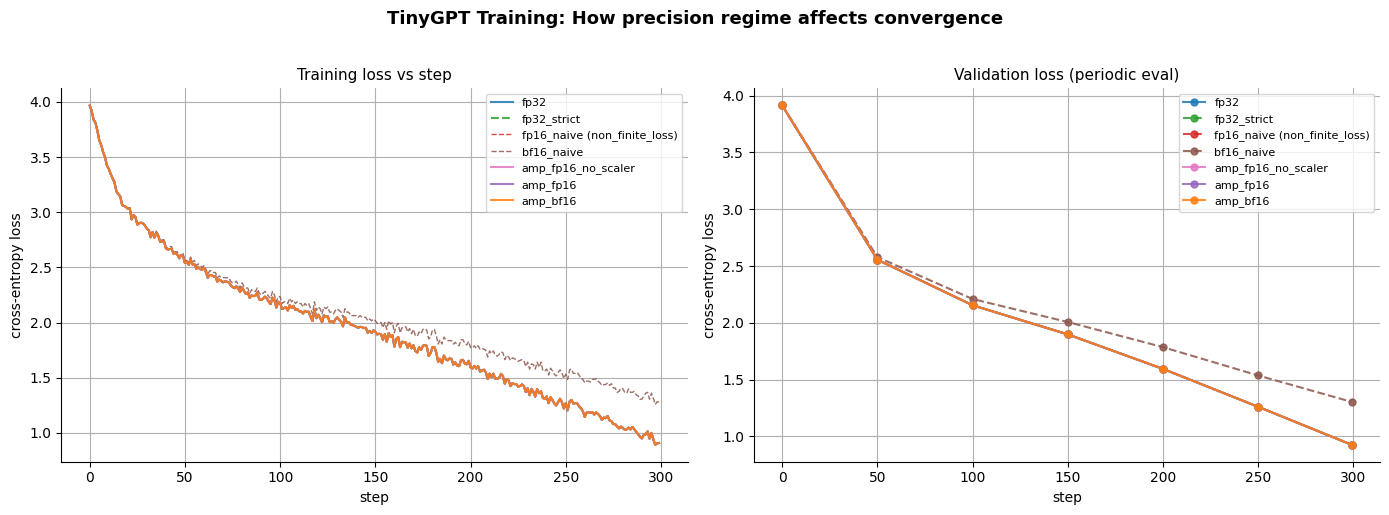

In [63]:
# Plot: Training + Validation loss curves (annotated)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

color_map = {
    "fp32": "C0", "fp32_strict": "C2",
    "fp16_naive": "C3", "bf16_naive": "C5",
    "amp_fp16_no_scaler": "C6", "amp_fp16": "C4", "amp_bf16": "C1",
    "amp_bf16_cpu": "C1",
    "amp_fp16_mps": "C4", "amp_bf16_mps": "C1",
}

for r in results:
    name = r["config"].name
    logs = r["logs"]
    suffix = f" ({r['status']})" if r["status"] != "ok" else ""
    color = color_map.get(name, "C7")
    ls = "--" if ("naive" in name or "strict" in name) else "-"
    if logs["train_loss"]:
        axes[0].plot(logs["step"], logs["train_loss"], label=f"{name}{suffix}",
                     alpha=0.85, color=color, linestyle=ls, linewidth=1.5 if "naive" not in name else 1.0)
    if logs["val_loss"]:
        axes[1].plot(logs["val_step"], logs["val_loss"], marker="o", ms=5, label=f"{name}{suffix}",
                     alpha=0.85, color=color, linestyle=ls)

axes[0].set_title("Training loss vs step", fontsize=11)
axes[0].set_xlabel("step")
axes[0].set_ylabel("cross-entropy loss")
axes[0].legend(fontsize=8, loc="upper right")

axes[1].set_title("Validation loss (periodic eval)", fontsize=11)
axes[1].set_xlabel("step")
axes[1].set_ylabel("cross-entropy loss")
axes[1].legend(fontsize=8, loc="upper right")

fig.suptitle("TinyGPT Training: How precision regime affects convergence", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()

print("What to look for:")
print("  - FP32 (blue): smooth reference curve")
if any(r["config"].name == "fp32_strict" for r in results):
    print("  - FP32 strict (dashed green): usually overlaps FP32 — TF32 differences are typically small")
print("  - Naive FP16 (dashed red): may stagnate, diverge, or NaN")
print("  - Naive BF16 (dashed olive): often converges — BF16 range prevents gradient death")
print("  - AMP variants (solid): should track FP32 closely, showing that AMP preserves quality")

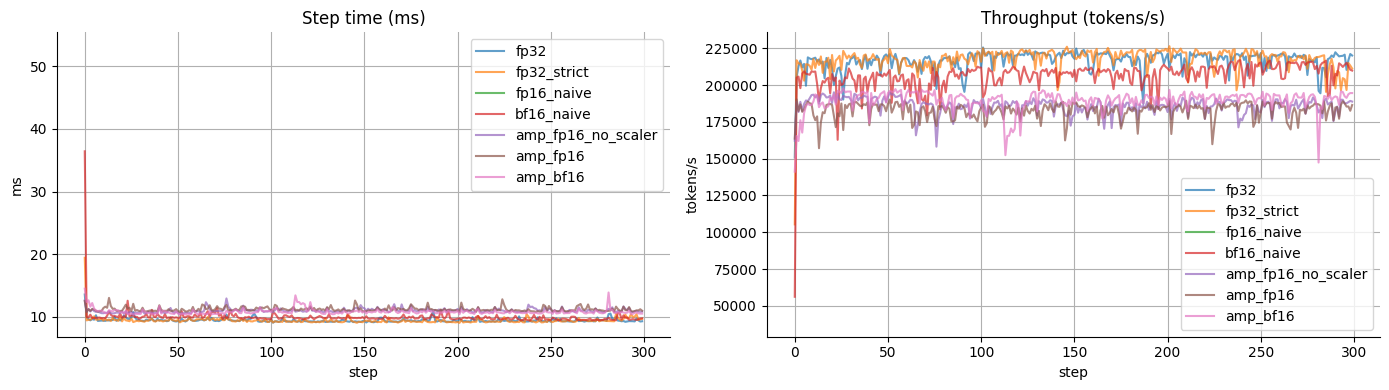

In [64]:
# Plot: Step time + throughput

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for r in results:
    name = r["config"].name
    logs = r["logs"]
    if not logs["step"]:
        continue
    axes[0].plot(logs["step"], logs["step_time_ms"], label=name, alpha=0.7)
    axes[1].plot(logs["step"], logs["tokens_per_s"], label=name, alpha=0.7)

axes[0].set_title("Step time (ms)")
axes[0].set_xlabel("step"); axes[0].set_ylabel("ms")
axes[0].legend()

axes[1].set_title("Throughput (tokens/s)")
axes[1].set_xlabel("step"); axes[1].set_ylabel("tokens/s")
axes[1].legend()

plt.tight_layout();

If gradients fall below the FP16 min normal line, they underflow to zero in FP16.
BF16 gradients essentially never underflow (BF16 min normal ≈ 1.2e-38).


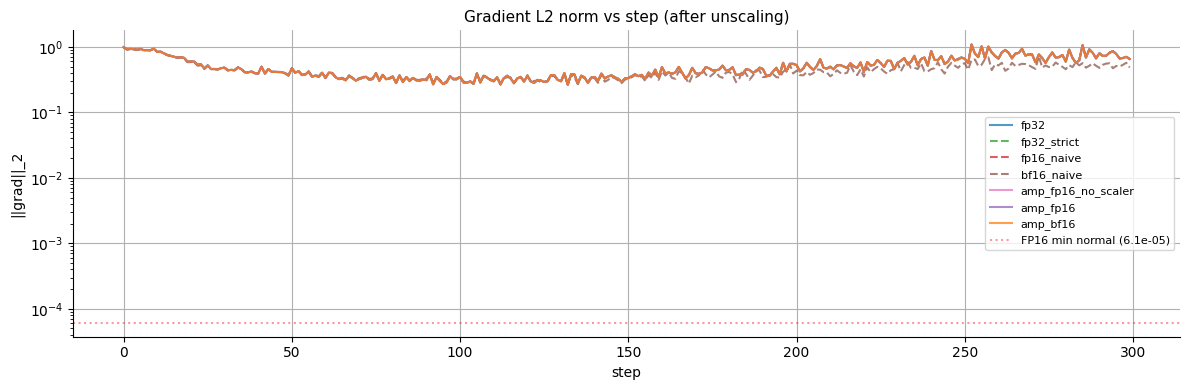

In [65]:
# Plot: Gradient norms across precision regimes

plt.figure(figsize=(12, 4))
for r in results:
    name = r["config"].name
    logs = r["logs"]
    if not logs["step"]:
        continue
    color = color_map.get(name, "C7")
    ls = "--" if ("naive" in name or "strict" in name) else "-"
    plt.plot(logs["step"], logs["grad_norm"], label=name, alpha=0.75, color=color, linestyle=ls)

# Add FP16 min normal threshold line
fi16 = torch.finfo(torch.float16)
plt.axhline(float(fi16.tiny), color="red", ls=":", alpha=0.4, label=f"FP16 min normal ({fi16.tiny:.1e})")

plt.title("Gradient L2 norm vs step (after unscaling)", fontsize=11)
plt.xlabel("step")
plt.ylabel("||grad||_2")
plt.yscale("log")
plt.legend(fontsize=8)
plt.tight_layout()

print("If gradients fall below the FP16 min normal line, they underflow to zero in FP16.")
print("BF16 gradients essentially never underflow (BF16 min normal ≈ 1.2e-38).")

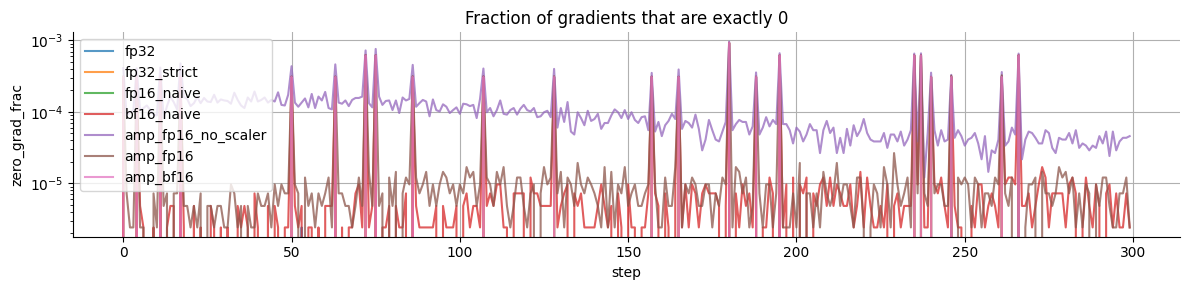

In [66]:
# Plot: Exact-zero gradient fraction (a proxy for underflow / dead signal)

plt.figure(figsize=(12, 3))
for r in results:
    name = r["config"].name
    logs = r["logs"]
    if not logs["step"]:
        continue
    if "zero_grad_frac" not in logs:
        continue
    plt.plot(logs["step"], logs["zero_grad_frac"], label=name, alpha=0.75)

plt.title("Fraction of gradients that are exactly 0")
plt.xlabel("step")
plt.ylabel("zero_grad_frac")
plt.yscale("log")
plt.legend()
plt.tight_layout();

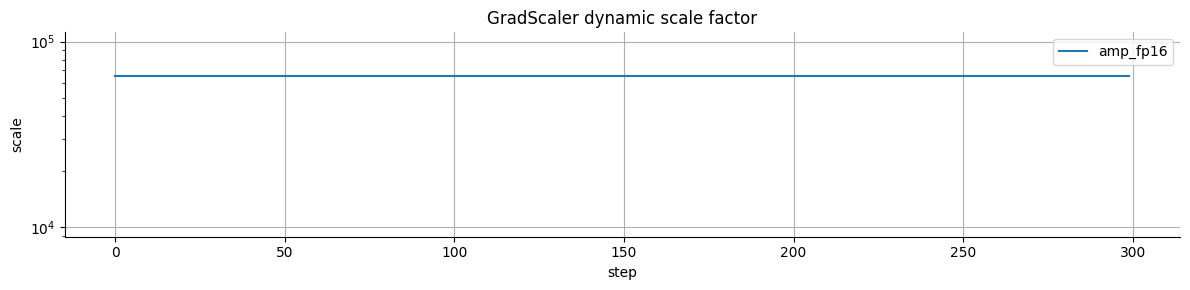

In [67]:
# Plot: GradScaler dynamic scale (FP16 AMP only)

plt.figure(figsize=(12, 3))
plotted = False
for r in results:
    if not r["config"].use_grad_scaler:
        continue
    logs = r["logs"]
    scale = np.array(logs["scale"], dtype=np.float64)
    if len(scale) == 0 or np.all(np.isnan(scale)):
        continue
    plt.plot(logs["step"], scale, label=r["config"].name)
    plotted = True

if plotted:
    plt.title("GradScaler dynamic scale factor")
    plt.xlabel("step")
    plt.ylabel("scale")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
else:
    print("No GradScaler data to plot (did amp_fp16 run?)")

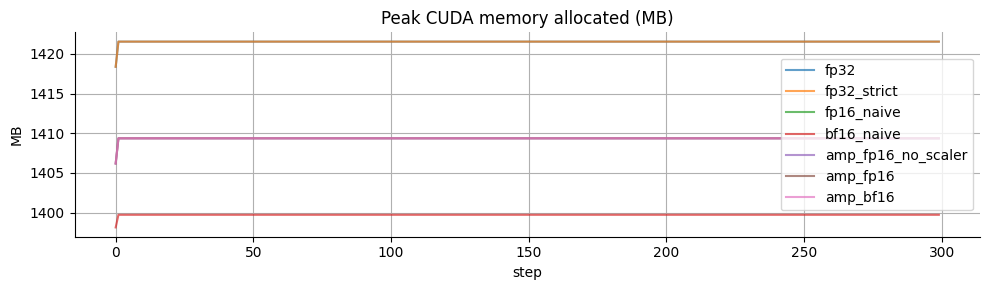

In [68]:
# Plot: CUDA peak memory

if device.type == "cuda":
    fig, ax = plt.subplots(figsize=(10, 3))
    for r in results:
        logs = r["logs"]
        if not logs["step"]:
            continue
        ax.plot(logs["step"], logs["cuda_mem_mb"], label=r["config"].name, alpha=0.7)
    ax.set_title("Peak CUDA memory allocated (MB)")
    ax.set_xlabel("step"); ax.set_ylabel("MB")
    ax.legend()
    plt.tight_layout()
else:
    print("CUDA not available; skipping memory plot.")

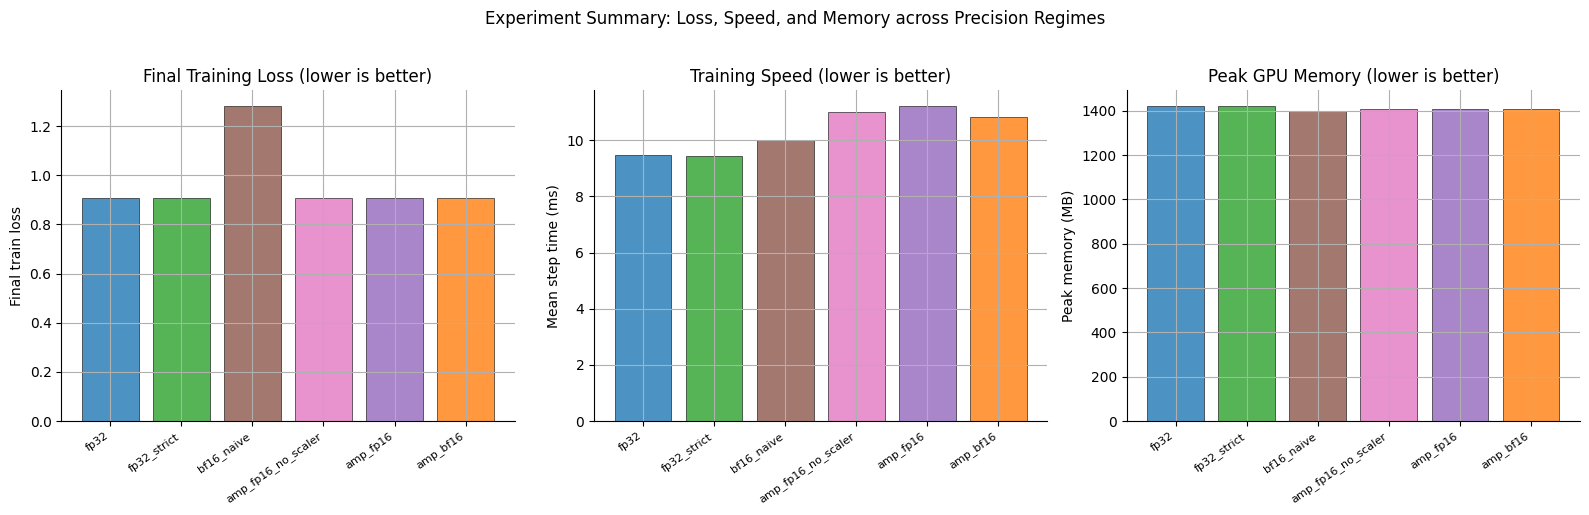

In [69]:
# Summary bar charts: compare all experiments at a glance

completed = [r for r in results if r["status"] == "ok" and r["logs"]["train_loss"]]

if len(completed) >= 2:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    names = [r["config"].name for r in completed]
    x_pos = np.arange(len(names))

    # 1. Final training loss
    final_losses = [r["logs"]["train_loss"][-1] for r in completed]
    colors = [color_map.get(r["config"].name, "C7") for r in completed]

    axes[0].bar(x_pos, final_losses, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5)
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(names, rotation=35, ha="right", fontsize=8)
    axes[0].set_ylabel("Final train loss")
    axes[0].set_title("Final Training Loss (lower is better)")

    # 2. Mean step time
    mean_times = [np.mean(r["logs"]["step_time_ms"]) for r in completed]
    axes[1].bar(x_pos, mean_times, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(names, rotation=35, ha="right", fontsize=8)
    axes[1].set_ylabel("Mean step time (ms)")
    axes[1].set_title("Training Speed (lower is better)")

    # 3. Peak CUDA memory
    if device.type == "cuda":
        peak_mem = [np.nanmax(r["logs"]["cuda_mem_mb"]) for r in completed]
        axes[2].bar(x_pos, peak_mem, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5)
        axes[2].set_xticks(x_pos)
        axes[2].set_xticklabels(names, rotation=35, ha="right", fontsize=8)
        axes[2].set_ylabel("Peak memory (MB)")
        axes[2].set_title("Peak GPU Memory (lower is better)")
    else:
        axes[2].text(0.5, 0.5, "CUDA memory\nnot available", transform=axes[2].transAxes,
                     ha="center", va="center", fontsize=12, color="gray")
        axes[2].set_title("Peak GPU Memory")

    fig.suptitle("Experiment Summary: Loss, Speed, and Memory across Precision Regimes", fontsize=12, y=1.02)
    plt.tight_layout()
else:
    print("Need at least 2 completed experiments for summary charts.")

### 3.6.1 Sanity check: generate text from each trained model

Loss curves are the real metric, but they're abstract. Since we're training a tiny **causal language model**, we can do a qualitative sanity check: generate a short continuation from a fixed prompt for each successfully trained regime.

Notes:
- This is **not** a rigorous evaluation — it's a learning aid.
- We run generation in **FP32** for comparability (we're comparing the *trained weights*, not inference autocast).

In [70]:
# Text generation samples (one prompt per precision regime)

@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -model.block_size:]
        logits = model(idx_cond)[:, -1, :] / max(float(temperature), 1e-8)
        if top_k is not None:
            v, _ = torch.topk(logits, int(top_k))
            logits = logits.clone()
            logits[logits < v[:, [-1]]] = -float("inf")
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)
    return idx

def safe_encode(s: str):
    return [stoi[c] for c in s if c in stoi]

PROMPT = "Autocast is "
NEW_TOKENS = 240
TEMPERATURE = 0.9
TOP_K = 20

set_seed(0)

printed = 0
for r in results:
    if r["status"] != "ok":
        continue
    state = r.get("state_dict", None)
    if state is None:
        continue
    cfg = r["config"]
    m = TinyGPT(
        vocab_size=vocab_size,
        block_size=cfg.block_size,
        n_layer=2,
        n_embd=128,
        n_heads=4,
        dropout=0.0,
    ).to(device).float()
    m.load_state_dict(state)

    idx0 = torch.tensor([safe_encode(PROMPT)], dtype=torch.long, device=device)
    out = generate(m, idx0, NEW_TOKENS, temperature=TEMPERATURE, top_k=TOP_K)
    text = decode_tokens(out[0].tolist())
    print(f"\n=== {cfg.name} ===\n{text}")
    printed += 1

if printed == 0:
    print("No successful runs to sample from.")


=== fp32 ===
Autocast is ocalition t: roumalioutin Tesin an Cobathg, e rarese aropre.
Sct uth pr rumis ats y peranerisetivepricimulonuly ativens an.
F16 caroftmeeermemulorgemicalis dccaulig, lonyenymepl sc lonss sc linsinsofow arepind one.
Grant natens FP32 nke wis

=== fp32_strict ===
Autocast is opey thes rech eat p nn reche esemithe pruno Teseclserumapsicanllositime licy anls rine lensititiosime an.
AMP uth arght arumucars/licariofth tizargergheprs cat.
Gr aprsti32 ay ale atotime any lowity anhe ed re FP16 aratexpot exp ongeno non

=== bf16_naive ===
Autocast is hative enngharin eca rft thepechten precic2.
AMP athtoptmitumulisicy ar AMP ath ds lmap nis rg, lonexpe lacatheducy matonatise mucatinos riobe → bat: ker glofth ununow ulyer epow; erary torow ath ericiecl Con.
FP32 etmatharanyoton, red 6 ru

=== amp_fp16_no_scaler ===
Autocast is epon.
AMat notos Corot imithe pro athecives pran.
Mat prs ngh rarororg, at atiorot e ep atmationdg, ion edution.
AMalioghars artiot rg, res e rg/l

### 3.6.2 OPT-125M training loss curves: real-world AMP on a Hugging Face model

TinyGPT above demonstrates AMP mechanics at small scale. Now we repeat the experiment with **OPT-125M** (125M parameters) — a real pretrained transformer — to show that the same patterns hold at realistic scale.

We fine-tune for **60 steps** under 6 precision configurations:

| # | Name | Params | Autocast | Scaler | Expected |
|---|------|--------|----------|--------|----------|
| 1 | `no_ac_fp32` | FP32 | OFF | No | Stable baseline |
| 2 | `no_ac_fp16` | FP16 | OFF | No | Often unstable / may diverge |
| 3 | `no_ac_bf16` | BF16 | OFF | No | May work (wider range) |
| 4 | `ac_fp32` | FP32 | ON | Yes | Canonical AMP baseline |
| 5 | `ac_fp16` | FP16 | ON | Yes | Non-standard; may improve vs naive FP16 |
| 6 | `ac_bf16` | BF16 | ON | No | Usually stable where BF16 is supported |

These 6 runs intentionally vary **both** parameter dtype and autocast policy to show practical regimes you will encounter in real code, not just a single-axis ablation.

> **Guard:** This section requires `trace_hf_model` (OPT-125M) loaded earlier + CUDA. Skipped otherwise.

In [71]:
# OPT-125M training setup

opt_train_results = []

if trace_hf_model is None or device.type != "cuda":
    print("Skipping OPT-125M training: requires trace_hf_model (OPT-125M) + CUDA.")
    print("To enable: set ALLOW_OPT_DOWNLOAD=True and run on a CUDA device.")
else:
    import copy as _copy

    # Tokenize a corpus with the OPT BPE tokenizer
    opt_corpus_text = corpus[:20000]  # reuse the char-level corpus text
    opt_tokens = trace_hf_tokenizer(opt_corpus_text, return_tensors="pt",
                                     truncation=True, max_length=4096)["input_ids"].squeeze(0).to(device)
    n_opt = int(0.9 * len(opt_tokens))
    opt_train_tokens = opt_tokens[:n_opt]
    opt_val_tokens = opt_tokens[n_opt:]

    OPT_BLOCK = 128
    OPT_BATCH = 4
    OPT_STEPS = 60
    OPT_LR = 5e-5

    def get_opt_batch(split):
        src = opt_train_tokens if split == "train" else opt_val_tokens
        max_start = src.size(0) - OPT_BLOCK - 1
        if max_start <= 0:
            max_start = 1
        ix = torch.randint(0, max_start, (OPT_BATCH,), device=device)
        offsets = torch.arange(OPT_BLOCK, device=device).unsqueeze(0)
        x = src[ix.unsqueeze(1) + offsets]
        y = src[ix.unsqueeze(1) + offsets + 1]
        return x, y

    print(f"OPT-125M tokens: train={len(opt_train_tokens):,}, val={len(opt_val_tokens):,}")
    print(f"Training: {OPT_STEPS} steps, batch={OPT_BATCH}, block={OPT_BLOCK}, lr={OPT_LR}")

OPT-125M tokens: train=3,686, val=410
Training: 60 steps, batch=4, block=128, lr=5e-05


In [72]:
# OPT-125M training loop

if trace_hf_model is not None and device.type == "cuda":
    import copy as _copy

    opt_configs = [
        {"name": "no_ac_fp32",  "param_dtype": torch.float32,  "use_autocast": False, "ac_dtype": None,           "use_scaler": False},
        {"name": "no_ac_fp16",  "param_dtype": torch.float16,  "use_autocast": False, "ac_dtype": None,           "use_scaler": False},
        {"name": "no_ac_bf16",  "param_dtype": torch.bfloat16, "use_autocast": False, "ac_dtype": None,           "use_scaler": False},
        {"name": "ac_fp32",     "param_dtype": torch.float32,  "use_autocast": True,  "ac_dtype": torch.float16,  "use_scaler": True},
        {"name": "ac_fp16",     "param_dtype": torch.float16,  "use_autocast": True,  "ac_dtype": torch.float16,  "use_scaler": True},
        {"name": "ac_bf16",     "param_dtype": torch.bfloat16, "use_autocast": True,  "ac_dtype": torch.bfloat16, "use_scaler": False},
    ]

    # Check BF16 support
    if not torch.cuda.is_bf16_supported():
        opt_configs = [c for c in opt_configs if c["param_dtype"] != torch.bfloat16]

    def train_opt(cfg):
        set_seed(42)
        torch.cuda.empty_cache()

        model_t = _copy.deepcopy(trace_hf_model).to(cfg["param_dtype"]).train()
        opt_t = torch.optim.AdamW(model_t.parameters(), lr=OPT_LR, weight_decay=0.01)
        scaler = GradScaler(enabled=True) if cfg["use_scaler"] else None

        losses, grad_norms, zero_fracs = [], [], []
        status = "ok"

        for step in range(OPT_STEPS):
            xb, yb = get_opt_batch("train")
            opt_t.zero_grad(set_to_none=True)

            ctx = amp_autocast(device, cfg["ac_dtype"], enabled=cfg["use_autocast"]) if cfg["use_autocast"] else nullcontext()
            with ctx:
                out = model_t(xb, labels=yb)
                loss = out.loss

            if not torch.isfinite(loss):
                status = f"diverged@step{step}"
                losses.append(float("nan"))
                break

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(opt_t)
                gn = torch.nn.utils.clip_grad_norm_(model_t.parameters(), 1.0)
                scaler.step(opt_t)
                scaler.update()
            else:
                loss.backward()
                gn = torch.nn.utils.clip_grad_norm_(model_t.parameters(), 1.0)
                opt_t.step()

            losses.append(float(loss))
            grad_norms.append(float(gn) if torch.isfinite(gn) else float("nan"))

            # Zero gradient fraction
            zf = 0.0
            total_params = 0
            for p in model_t.parameters():
                if p.grad is not None:
                    g = p.grad.float().flatten()
                    zf += float((g == 0).sum())
                    total_params += g.numel()
            zero_fracs.append(zf / max(total_params, 1))

        del model_t, opt_t
        if scaler is not None:
            del scaler
        torch.cuda.empty_cache()

        return {"name": cfg["name"], "status": status, "losses": losses,
                "grad_norms": grad_norms, "zero_fracs": zero_fracs}

    for cfg in tqdm(opt_configs, desc="OPT-125M configs"):
        print(f"\n--- {cfg['name']} ---")
        result = train_opt(cfg)
        opt_train_results.append(result)
        print(f"  Status: {result['status']}, "
              f"Final loss: {result['losses'][-1]:.4f}" if result['losses'] and not np.isnan(result['losses'][-1]) else f"  Status: {result['status']}")

OPT-125M configs:   0%|          | 0/6 [00:00<?, ?it/s]


--- no_ac_fp32 ---
  Status: ok, Final loss: 0.0650

--- no_ac_fp16 ---
  Status: diverged@step1

--- no_ac_bf16 ---
  Status: ok, Final loss: 0.0722

--- ac_fp32 ---
  Status: ok, Final loss: 0.0582

--- ac_fp16 ---


ValueError: Attempting to unscale FP16 gradients.

In [ ]:
# OPT-125M: plot loss curves + gradient norms + final loss comparison

if len(opt_train_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Color/style mapping
    color_map_opt = {
        "no_ac_fp32": ("#2ecc71", "-"),   "no_ac_fp16": ("#e74c3c", "--"),
        "no_ac_bf16": ("#3498db", "--"),   "ac_fp32": ("#27ae60", "-"),
        "ac_fp16": ("#c0392b", "-"),       "ac_bf16": ("#2980b9", "-"),
    }

    # Top-left: loss curves
    ax = axes[0, 0]
    for r in opt_train_results:
        color, ls = color_map_opt.get(r["name"], ("#95a5a6", "-"))
        label = r["name"]
        if r["status"] != "ok":
            label += f" ({r['status']})"
        ax.plot(r["losses"], color=color, ls=ls, lw=1.5, alpha=0.8, label=label)
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_title("OPT-125M: Training Loss Curves", fontsize=10)
    ax.legend(fontsize=7)
    ax.set_ylim(bottom=0)

    # Top-right: gradient norms
    ax = axes[0, 1]
    for r in opt_train_results:
        if not r["grad_norms"]:
            continue
        color, ls = color_map_opt.get(r["name"], ("#95a5a6", "-"))
        ax.plot(r["grad_norms"], color=color, ls=ls, lw=1.2, alpha=0.7, label=r["name"])
    ax.set_xlabel("Step")
    ax.set_ylabel("Gradient Norm")
    ax.set_title("Gradient Norm Over Training", fontsize=10)
    ax.set_yscale("log")
    ax.legend(fontsize=7)

    # Bottom-left: final loss bar chart
    ax = axes[1, 0]
    ok_results = [r for r in opt_train_results if r["losses"] and not np.isnan(r["losses"][-1])]
    if ok_results:
        names = [r["name"] for r in ok_results]
        final_losses = [r["losses"][-1] for r in ok_results]
        bar_colors = [color_map_opt.get(n, ("#95a5a6", "-"))[0] for n in names]
        ax.bar(range(len(names)), final_losses, color=bar_colors, alpha=0.8, edgecolor="white")
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels(names, fontsize=7, rotation=30, ha="right")
        ax.set_ylabel("Final Loss")
        ax.set_title("Final Loss Comparison", fontsize=10)

        # Mark diverged (offset vertically to avoid overlap)
        diverged = [r for r in opt_train_results if r["status"] != "ok" and r["name"] not in names]
        for i, r in enumerate(diverged):
            ax.annotate(f"{r['name']} ({r['status']})", xy=(0.98, 0.95 - 0.08 * i),
                        xycoords="axes fraction", ha="right", va="top",
                        fontsize=7, color="red")

    # Bottom-right: zero-gradient fraction
    ax = axes[1, 1]
    for r in opt_train_results:
        if not r["zero_fracs"]:
            continue
        color, ls = color_map_opt.get(r["name"], ("#95a5a6", "-"))
        ax.plot(r["zero_fracs"], color=color, ls=ls, lw=1.2, alpha=0.7, label=r["name"])
    ax.set_xlabel("Step")
    ax.set_ylabel("Zero-Gradient Fraction")
    ax.set_title("Zero-Gradient Fraction (FP16 underflow indicator)", fontsize=10)
    ax.legend(fontsize=7)

    fig.suptitle("OPT-125M fine-tuning: 6 precision configurations × 60 steps", fontsize=12, y=1.02)
    plt.tight_layout()
else:
    print("No OPT-125M training results (skipped: need OPT-125M + CUDA).")

**Observation (OPT-125M Training):**
- **`no_ac_fp32`** (FP32 baseline): stable, converging loss — the reference.
- **`no_ac_fp16`** (naive FP16): often unstable (divergence, NaNs, or noisy optimization), but exact behavior depends on GPU, LR, and clipping.
- **`no_ac_bf16`** (naive BF16): usually more stable than FP16 (wider exponent range), sometimes with a small quality tradeoff.
- **`ac_fp32`** (FP32 params + autocast FP16): canonical AMP setup; usually best stability/speed tradeoff.
- **`ac_fp16`** (FP16 params + autocast): can improve over naive FP16, but remains less robust than FP32-master AMP because params/optimizer states stay low precision.
- **`ac_bf16`** (BF16 params + autocast): typically stable without a scaler on BF16-capable hardware.

Use this section as an empirical benchmark: the plotted outcomes are authoritative for your run, and the qualitative trend to look for is that **policy-driven mixed precision is safer than naive global casting**.

## 3.7 Memory breakdown comparison (bytes per parameter)

For LLM-scale training, it helps to separate memory into:

- **Fixed-size memory** (scales with number of parameters): parameters + gradients + optimizer state (+ optional master weights).
- **Activation memory** (scales with batch size × sequence length × layers): intermediate tensors saved for backward.

AMP/autocast primarily helps with **activation memory** (and speed). With AdamW, the fixed-size **bytes/parameter** are often **~16 bytes/param** in both FP32 and "standard AMP" because optimizer state dominates.

### The key comparison: FP32 vs mixed precision (AdamW)

| Component | FP32 Training | Mixed Precision (AMP) | Savings |
|---|---|---|---|
| **Parameters** | 4 B/param (FP32) | 4 B/param (FP32 master) | 0% |
| **Gradients** | 4 B/param (FP32) | 4 B/param (FP32) | 0% |
| **Optimizer state** ($m$) | 4 B/param (FP32) | 4 B/param (FP32) | 0% |
| **Optimizer state** ($v$) | 4 B/param (FP32) | 4 B/param (FP32) | 0% |
| **Total fixed** | **16 B/param** | **16 B/param** | **0%** |
| **Activations** (varies) | FP32 | FP16/BF16 (~half) | **~50%** |

**The surprise:** Standard PyTorch AMP does *not* reduce fixed per-parameter memory at all! The savings come entirely from **activations** (which are stored in FP16/BF16 for the backward pass) and from **faster compute** (Tensor Cores). For large-batch, long-sequence training, activation memory dominates, so AMP's 50% activation reduction is substantial.

To reduce fixed per-parameter memory, you need additional techniques:
- **8-bit optimizers** (§2.12): reduce optimizer state from 8 B/param to ~2 B/param
- **FP16/BF16 master weights** (e.g., in some FSDP/ZeRO configs): reduce param storage
- **Gradient compression**: reduce gradient storage during distributed training

We'll compute the fixed-size accounting for a few common patterns and show what that looks like for our TinyGPT.

### 3.7.0 Where AMP memory savings *really* come from (measured on this model)

Let's make this concrete with one controlled measurement on **the same TinyGPT model and same batch shape**:

1. **FP32 training step** (no autocast)
2. **AMP training step** (FP32 params + autocast)

For each run we measure:
- **Parameters** memory
- **Gradients** memory
- **Optimizer state** memory (AdamW moments, after first optimizer step)
- **Activation peak** memory during forward

This gives the exact intuition: AMP usually keeps fixed-size memory (params/grads/optimizer) close to FP32, while cutting activation memory substantially.

In [ ]:
# Measured memory composition on TinyGPT: FP32 vs AMP (same hardware, same model shape)

def _tensor_nbytes(t: torch.Tensor) -> int:
    return int(t.numel()) * int(t.element_size())

def _optimizer_state_nbytes(opt: torch.optim.Optimizer) -> int:
    total = 0
    for state in opt.state.values():
        for v in state.values():
            if isinstance(v, torch.Tensor):
                total += _tensor_nbytes(v)
    return int(total)

def measure_memory_breakdown(use_autocast: bool, ac_dtype: torch.dtype | None, batch_size: int = 32, block_size: int = 64):
    if device.type != "cuda":
        raise RuntimeError("CUDA required for reliable activation memory profiling.")

    set_seed(123)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    model_m = TinyGPT(vocab_size=vocab_size, block_size=block_size, n_layer=2, n_embd=128, n_heads=4, dropout=0.0).to(device).float()
    opt_m = torch.optim.AdamW(model_m.parameters(), lr=3e-4)

    # Fixed components from tensor dtypes.
    param_bytes = sum(_tensor_nbytes(p) for p in model_m.parameters())

    max_start = train_data.size(0) - block_size - 1
    ix = torch.randint(0, max_start, (batch_size,), device=device)
    offsets = torch.arange(block_size, device=device).unsqueeze(0)
    xb = train_data[ix.unsqueeze(1) + offsets]
    yb = train_data[ix.unsqueeze(1) + offsets + 1]

    # Warm-up in the target precision path to reduce one-time kernel/workspace noise.
    with torch.no_grad():
        with amp_autocast(device, ac_dtype, enabled=use_autocast):
            _ = model_m(xb[:2])
    torch.cuda.synchronize()

    # Baseline allocation after model + optimizer construction.
    base_alloc = torch.cuda.memory_allocated()

    # Forward (capture peak incremental memory, which is dominated by activations/workspaces).
    torch.cuda.reset_peak_memory_stats()
    model_m.zero_grad(set_to_none=True)
    with amp_autocast(device, ac_dtype, enabled=use_autocast):
        logits = model_m(xb)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), yb.reshape(-1))
    torch.cuda.synchronize()
    forward_peak = torch.cuda.max_memory_allocated()
    activation_peak_bytes = max(0, int(forward_peak - base_alloc))

    # Backward to materialize gradients.
    loss.backward()
    grad_bytes = sum(_tensor_nbytes(p.grad) for p in model_m.parameters() if p.grad is not None)

    # One optimizer step initializes AdamW moments (optimizer state memory).
    opt_m.step()
    opt_state_bytes = _optimizer_state_nbytes(opt_m)

    out = {
        "params_MB": param_bytes / 1024**2,
        "grads_MB": grad_bytes / 1024**2,
        "optimizer_MB": opt_state_bytes / 1024**2,
        "activations_peak_MB": activation_peak_bytes / 1024**2,
    }

    # Cleanup
    del model_m, opt_m, xb, yb, logits, loss
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    return out

if device.type != "cuda":
    print("CUDA not available. This measured FP32-vs-AMP activation breakdown requires CUDA.")
else:
    amp_dtype_mem = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

    fp32_mem = measure_memory_breakdown(use_autocast=False, ac_dtype=None)
    amp_mem = measure_memory_breakdown(use_autocast=True, ac_dtype=amp_dtype_mem)

    components = ["Parameters", "Gradients", "Optimizer state", "Activations (peak)"]
    color_map_mem = {
        "Parameters": "#1f77b4",
        "Gradients": "#ff7f0e",
        "Optimizer state": "#2ca02c",
        "Activations (peak)": "#d62728",
    }

    fp32_vals = [fp32_mem["params_MB"], fp32_mem["grads_MB"], fp32_mem["optimizer_MB"], fp32_mem["activations_peak_MB"]]
    amp_vals = [amp_mem["params_MB"], amp_mem["grads_MB"], amp_mem["optimizer_MB"], amp_mem["activations_peak_MB"]]

    rows = []
    for comp, a, b in zip(components, fp32_vals, amp_vals):
        rows.append({
            "component": comp,
            "fp32_MB": float(f"{a:.2f}"),
            f"amp_{str(amp_dtype_mem).replace('torch.', '')}_MB": float(f"{b:.2f}"),
            "delta_MB": float(f"{(b - a):.2f}"),
            "delta_pct": float(f"{(100.0 * (b - a) / max(a, 1e-9)):.2f}"),
        })
    display(pd.DataFrame(rows))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    scenarios = [
        ("FP32 (no autocast)", fp32_vals),
        (f"AMP autocast ({str(amp_dtype_mem).replace('torch.', '')})", amp_vals),
    ]

    for ax, (title, vals) in zip(axes, scenarios):
        bottom = 0.0
        for comp, val in zip(components, vals):
            ax.bar([0], [val], width=0.55, bottom=[bottom], color=color_map_mem[comp], edgecolor="white")
            if val > 1.0:
                ax.text(0, bottom + val / 2, f"{val:.1f} MB", ha="center", va="center",
                        fontsize=8, color="white", fontweight="bold")
            bottom += val
        ax.set_title(title, fontsize=10)
        ax.set_xticks([0])
        ax.set_xticklabels(["TinyGPT step"])
        ax.set_ylabel("Memory (MB)")
        ax.set_xlim(-0.6, 0.6)
        ax.text(0, bottom + 1.0, f"Total: {bottom:.1f} MB", ha="center", va="bottom",
                fontsize=9, fontweight="bold")

    from matplotlib.patches import Patch
    legend_handles = [Patch(color=color_map_mem[k], label=k) for k in components]
    fig.legend(handles=legend_handles, loc="lower center", ncol=4, fontsize=8, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Memory composition per training step: FP32 vs AMP on the same model", fontsize=12, y=1.02)
    plt.tight_layout()

    act_save = fp32_mem["activations_peak_MB"] - amp_mem["activations_peak_MB"]
    act_save_pct = 100 * act_save / max(fp32_mem["activations_peak_MB"], 1e-9)
    total_fp32 = sum(fp32_vals)
    total_amp = sum(amp_vals)
    total_save_pct = 100 * (total_fp32 - total_amp) / max(total_fp32, 1e-9)

    print("\nInterpretation:")
    print("  - Parameters, gradients, and optimizer state stay in roughly the same range.")
    print("  - The large drop is in activation memory under autocast.")
    print(f"  - Activation peak savings: {act_save:.2f} MB ({act_save_pct:.1f}%)")
    print(f"  - Total shown-memory savings: {total_save_pct:.1f}%")
    print("  - This is why AMP's practical memory win is mainly 'more activation room' for bigger batch/sequence.")

In [ ]:
# Fixed-size memory breakdown analysis (parameters + grads + optimizer state)

def count_params(model):
    return sum(p.numel() for p in model.parameters())

model_tmp = TinyGPT(vocab_size=vocab_size, block_size=64, n_layer=2, n_embd=128, n_heads=4)
n_params = count_params(model_tmp)
del model_tmp

rows = []
configs = [
    # AdamW has 2 FP32 moment buffers by default: m and v (8 bytes/param).
    {
        "config": "FP32 AdamW (baseline)",
        "param_B": 4, "master_B": 0, "grad_B": 4, "opt_B": 8,
        "notes": "Params/grads/Adam moments all FP32",
    },
    {
        "config": "PyTorch AMP FP16 (compute)",
        "param_B": 4, "master_B": 0, "grad_B": 4, "opt_B": 8,
        "notes": "Typical AMP: params/grads/state FP32; matmuls run in FP16 under autocast",
    },
    {
        "config": "PyTorch AMP BF16 (compute)",
        "param_B": 4, "master_B": 0, "grad_B": 4, "opt_B": 8,
        "notes": "Typical AMP: params/grads/state FP32; matmuls run in BF16 under autocast",
    },
    {
        "config": "Naive FP16 AdamW (NOT recommended)",
        "param_B": 2, "master_B": 0, "grad_B": 2, "opt_B": 4,
        "notes": "Small fixed memory, but numerically fragile (underflow/overflow + low-precision optimizer state)",
    },
    {
        "config": "Naive BF16 AdamW (sometimes works)",
        "param_B": 2, "master_B": 0, "grad_B": 2, "opt_B": 4,
        "notes": "Often trains, but sensitive reductions/normalizations can drift without an FP32 policy",
    },
    {
        "config": "FP16 params + FP32 master + FP32 AdamW (classic mixed precision)",
        "param_B": 2, "master_B": 4, "grad_B": 2, "opt_B": 8,
        "notes": "Common in some stacks: FP16 model copy + FP32 master weights + FP32 optimizer moments",
    },
]

for cfg in configs:
    total_B = int(cfg["param_B"] + cfg["master_B"] + cfg["grad_B"] + cfg["opt_B"])
    param_mb = n_params * cfg["param_B"] / 1024**2
    master_mb = n_params * cfg["master_B"] / 1024**2
    grad_mb = n_params * cfg["grad_B"] / 1024**2
    opt_mb = n_params * cfg["opt_B"] / 1024**2
    total_mb = param_mb + master_mb + grad_mb + opt_mb
    rows.append({
        "config": cfg["config"],
        "bytes_per_param": total_B,
        "param_MB": float(f"{param_mb:.3f}"),
        "master_MB": float(f"{master_mb:.3f}"),
        "grad_MB": float(f"{grad_mb:.3f}"),
        "optimizer_MB": float(f"{opt_mb:.3f}"),
        "total_fixed_MB": float(f"{total_mb:.3f}"),
        "notes": cfg["notes"],
    })

print(f"TinyGPT parameters: {n_params:,}")
print("Fixed-size bytes/param = params + master + grads + optimizer state (activations NOT included).")
print("(Real LLM AMP savings come mostly from activations, which scale with batch×seq_len.)\n")

df_mem = pd.DataFrame(rows)
display(df_mem)

# Visualize fixed memory breakdown as stacked bar chart
fig, ax = plt.subplots(figsize=(12, 4))
x = np.arange(len(rows))
w = 0.5
names_m = df_mem["config"].tolist()
param_mb = df_mem["param_MB"].tolist()
master_mb = df_mem["master_MB"].tolist()
grad_mb = df_mem["grad_MB"].tolist()
opt_mb = df_mem["optimizer_MB"].tolist()

ax.bar(x, param_mb, w, label="Model params", color="C0", alpha=0.8)
ax.bar(x, master_mb, w, bottom=param_mb, label="Master params", color="C4", alpha=0.8)
ax.bar(x, grad_mb, w, bottom=[p+m for p,m in zip(param_mb, master_mb)], label="Gradients", color="C1", alpha=0.8)
ax.bar(
    x, opt_mb, w,
    bottom=[p+m+g for p,m,g in zip(param_mb, master_mb, grad_mb)],
    label="Optimizer state",
    color="C2",
    alpha=0.8,
)
ax.set_xticks(x)
ax.set_xticklabels(names_m, rotation=25, ha="right", fontsize=8)
ax.set_ylabel("Memory (MB)")
ax.set_title(f"Fixed memory breakdown by precision config ({n_params:,} params)")
ax.legend()
plt.tight_layout()

print("\nNote: This shows only fixed-size memory (params + grads + optimizer).")
print("Activations (which scale with batch×seq_len) are the real memory win for AMP.")
print("For large models, activation memory often exceeds parameter memory by 5-10x.")

In [ ]:
# Side-by-side: FP32 vs AMP (with estimated activation memory)
# Illustrates where AMP memory savings actually come from.

# Assume a representative activation memory estimate:
# For a transformer, activation memory per token ≈ 2 * n_layers * n_embd * bytes_per_element
# With batch_size=32, block_size=64 → 2048 tokens
n_tokens = 32 * 64  # batch_size * block_size
n_layers_est = 2
n_embd_est = 128

# Rough activation bytes: each layer stores ~4 intermediate tensors of shape [batch, seq, embd]
act_tensors_per_layer = 4  # (attention input, attention output, FFN input, FFN output)
act_elements = n_tokens * n_embd_est * n_layers_est * act_tensors_per_layer

fp32_fixed = n_params * 16  # 16 B/param
amp_fixed = n_params * 16   # same: 16 B/param
fp32_act = act_elements * 4  # FP32 activations
amp_act = act_elements * 2   # FP16/BF16 activations

categories = ["Fixed\n(params+grads+opt)", "Activations\n(saved for backward)", "Total"]
fp32_vals = np.array([fp32_fixed, fp32_act, fp32_fixed + fp32_act]) / 1024**2
amp_vals = np.array([amp_fixed, amp_act, amp_fixed + amp_act]) / 1024**2

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(categories))
w = 0.35
bars1 = ax.bar(x - w/2, fp32_vals, w, label="FP32", color="C0", alpha=0.8, edgecolor="black", linewidth=0.5)
bars2 = ax.bar(x + w/2, amp_vals, w, label="AMP (FP16/BF16)", color="C1", alpha=0.8, edgecolor="black", linewidth=0.5)

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
                ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9)
ax.set_ylabel("Memory (MB)")
ax.set_title(f"FP32 vs AMP memory breakdown (TinyGPT, {n_params:,} params, batch=32×64)", fontsize=11)
ax.legend()
plt.tight_layout()

savings_pct = (1 - (amp_fixed + amp_act) / (fp32_fixed + fp32_act)) * 100
print(f"Fixed memory: identical (16 B/param in both regimes)")
print(f"Activation memory: {fp32_act/1024**2:.2f} MB (FP32) → {amp_act/1024**2:.2f} MB (AMP) = 50% reduction")
print(f"Total estimated savings: {savings_pct:.1f}%")
print()
print("At LLM scale (billions of params, long sequences), activation memory dominates,")
print("so the ~50% activation reduction from AMP translates to substantial GPU memory savings.")

### 3.7.1 LLM-scale memory projections: when does AMP become mandatory?

The TinyGPT numbers above are small. Let's project the fixed memory costs to real model sizes to see where AMP (and distributed training) become necessary.

**Important caveat:** These projections show only **fixed-size memory** (parameters + gradients + optimizer state). Activation memory (which scales with batch size $\times$ sequence length $\times$ layers) adds significantly more, and that's where AMP's 50% savings on activations really matters.

In [ ]:
# LLM-scale memory projections

model_scales = {
    "TinyGPT (this nb)": n_params,
    "GPT-2 Small (125M)": 125_000_000,
    "GPT-2 XL (1.5B)": 1_500_000_000,
    "LLaMA-7B": 7_000_000_000,
    "LLaMA-13B": 13_000_000_000,
    "LLaMA-70B": 70_000_000_000,
}

rows = []
for name, n in model_scales.items():
    # AdamW: 2 FP32 moment buffers + FP32 params + FP32 grads = 16 B/param
    std_gb = n * 16 / 1024**3
    # AMP with AdamW: SAME fixed cost (AMP only saves on activations)
    amp_gb = n * 16 / 1024**3
    # Naive 16-bit: 2 param + 2 grad + 4 m + 4 v = ~12 B/param (optimizer still FP32-ish)
    # ... or full naive: 2+2+2+2 = 8 B/param (risky)
    naive_gb = n * 8 / 1024**3
    # 8-bit optimizer: 4 param + 4 grad + 1 m + 1 v = ~10 B/param
    opt8_gb = n * 10 / 1024**3

    rows.append({
        "Model": name,
        "Params": f"{n / 1e6:.0f}M" if n < 1e9 else f"{n / 1e9:.1f}B",
        "FP32+AdamW (GB)": f"{std_gb:.1f}",
        "AMP+AdamW (GB)": f"{amp_gb:.1f}",
        "Naive 16bit (GB)": f"{naive_gb:.1f}",
        "AMP+8bit opt (GB)": f"{opt8_gb:.1f}",
        "1x 24GB GPU?": "YES" if amp_gb < 22 else "NO",
        "1x 80GB GPU?": "YES" if amp_gb < 75 else "NO",
    })

display(pd.DataFrame(rows))

print("\nKey takeaways:")
print("  - Standard AMP does NOT reduce fixed memory vs FP32 (both 16 B/param with AdamW)")
print("  - A 7B model needs ~112 GB just for params+grads+optimizer (before activations!)")
print("  - This exceeds even an 80GB A100 → distributed training (FSDP/ZeRO) is mandatory")
print("  - 8-bit optimizers reduce fixed cost by ~37% (16 → 10 B/param)")
print("  - The real AMP savings come from activations (50% reduction) + Tensor Core speedups")
print()
print("  Rule of thumb: you need roughly 4x the model size in GB for inference (FP32),")
print("  and 16x for training with AdamW (params + grads + 2 moment buffers).")

### 3.7.2 Empirical activation memory: FP32 vs autocast (CUDA only)

The theoretical analysis shows that activation memory halves under AMP. Let's verify this by measuring actual CUDA memory allocation during forward passes at different batch sizes.

Activation memory scales with **batch_size $\times$ sequence_length $\times$ hidden_dim $\times$ num_layers**, so the savings from AMP become more significant as you scale up.

In [ ]:
# Empirical activation memory measurement (CUDA only)

if device.type == "cuda":
    set_seed(0)

    dtype_16_test = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

    test_mem_configs = [
        ("FP32 (no autocast)", torch.float32, False, None),
        (f"AMP ({dtype_16_test})", torch.float32, True, dtype_16_test),
        (f"Naive {dtype_16_test}", dtype_16_test, False, None),
    ]

    BLOCK_MEM = 64
    BATCH_SIZES_MEM = [4, 16, 32, 64]

    rows = []
    for batch_size in BATCH_SIZES_MEM:
        for cfg_name, param_dt, use_ac, ac_dt in test_mem_configs:
            try:
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()

                m_test = TinyGPT(vocab_size, BLOCK_MEM, n_layer=2, n_embd=128, n_heads=4, dropout=0.0)
                m_test = m_test.to(device).to(param_dt)

                torch.cuda.synchronize()
                mem_model = torch.cuda.memory_allocated() / 1024**2

                idx_test = torch.randint(0, vocab_size, (batch_size, BLOCK_MEM), device=device)
                with amp_autocast(device, ac_dt, enabled=use_ac):
                    logits_test = m_test(idx_test)
                    loss_test = F.cross_entropy(
                        logits_test.reshape(-1, logits_test.size(-1)),
                        idx_test.roll(-1, dims=1).reshape(-1),
                    )

                torch.cuda.synchronize()
                mem_after_fwd = torch.cuda.memory_allocated() / 1024**2
                activation_mem = mem_after_fwd - mem_model

                loss_test.backward()
                torch.cuda.synchronize()
                peak_mem = torch.cuda.max_memory_allocated() / 1024**2

                rows.append({
                    "batch": batch_size,
                    "config": cfg_name,
                    "model_MB": f"{mem_model:.1f}",
                    "activation_MB": f"{activation_mem:.1f}",
                    "peak_MB": f"{peak_mem:.1f}",
                })

                del m_test, logits_test, loss_test, idx_test
                torch.cuda.empty_cache()
            except Exception as e:
                rows.append({
                    "batch": batch_size,
                    "config": cfg_name,
                    "model_MB": "-",
                    "activation_MB": "-",
                    "peak_MB": f"error: {type(e).__name__}",
                })

    df_act_mem = pd.DataFrame(rows)
    display(df_act_mem)

    # Plot activation memory vs batch size for each config
    fig, ax = plt.subplots(figsize=(10, 4))
    for cfg_name, _, _, _ in test_mem_configs:
        subset = df_act_mem[df_act_mem["config"] == cfg_name]
        try:
            bs_vals = subset["batch"].tolist()
            act_vals = [float(v) for v in subset["activation_MB"].tolist()]
            ax.plot(bs_vals, act_vals, marker="o", label=cfg_name, linewidth=2)
        except (ValueError, TypeError):
            pass
    ax.set_xlabel("Batch size")
    ax.set_ylabel("Activation memory (MB)")
    ax.set_title("Activation memory vs batch size — AMP halves activation storage")
    ax.legend()
    plt.tight_layout()

    print("\nKey observation:")
    print("  Activation memory (the gap between model-loaded and after-forward) scales with batch size.")
    print("  Under autocast, activations are stored in FP16/BF16 → roughly half the memory.")
    print("  This is the PRIMARY memory benefit of AMP for training.")
    print("  At large batch sizes and long sequences, this savings is substantial.")
else:
    print("CUDA not available. Activation memory profiling requires CUDA.")
    print("Key point: autocast halves activation memory because intermediate tensors")
    print("saved for backward are stored in FP16/BF16 instead of FP32.")

## 3.8 Interpreting results

### Loss curves
- **FP32**: should decrease smoothly. This is your reference.
- **FP16 naive**: may diverge, stagnate, or produce NaN. This demonstrates why casting everything to half precision is not safe.
- **BF16 naive**: often converges to a similar loss as FP32. This is the dramatic proof that BF16's range (8-bit exponent) matters more than FP16's precision (10-bit mantissa) for training stability. The network tolerates noisy gradient values; it cannot tolerate zero gradient values.
- **AMP FP16 (no scaler)**: may work but may show more zero gradients than the scaled version. This shows that autocast alone helps (per-op policy keeps sensitive ops in FP32) but doesn't fully solve the backward-pass underflow problem.
- **AMP FP16 (with scaler)**: should be stable. The GradScaler rescues gradients from underflow.
- **AMP BF16**: typically matches FP32 quality without needing a scaler.

### Step time
- On modern GPUs, AMP often reduces step time because matmuls hit Tensor Cores.
- If you don't see speedup: model may be too small (overhead dominates), or you're CPU-bound.
- The smallest models sometimes see AMP *overhead* because the per-op dispatch cost exceeds the Tensor Core gains. This goes away at realistic model sizes.

### Gradient norms
- Should be comparable across regimes for a well-behaved model.
- If FP16 naive shows erratic norms, that's the underflow/overflow instability.
- BF16 naive norms should be close to FP32 (same gradient magnitudes, just represented with fewer mantissa bits).

### Zero gradients
- A high `zero_grad_frac` indicates underflow or dead signal (exact zeros).
- **FP16 naive** and **AMP FP16 no scaler** may show elevated zero-gradient fractions.
- **BF16 naive** should show low zero-gradient fractions (gradients don't underflow with 8-bit exponent).
- The difference between FP16+scaler and FP16 without scaler directly measures the benefit of loss scaling.

### GradScaler scale
- If scale drops repeatedly, the model is hitting overflow events and GradScaler is skipping steps.
- If scale grows steadily, training is stable and GradScaler is increasing headroom.
- A "spiky" pattern (rapid drops followed by slow climbs) is normal and expected.

### Memory
- AMP typically uses ~same or slightly more memory than FP32 for parameters+optimizer (due to master weights), but saves on activations.
- Naive 16-bit uses less total memory but trades stability.
- The savings become dramatic at larger batch sizes and sequence lengths.
- At LLM scale with Adam: 16 bytes/param (mixed precision) vs 16 bytes/param (FP32). The *activation* memory savings are where AMP really wins.

## 3.9 Practical checklist

### Defaults that usually work
- **CUDA:** prefer **BF16 autocast** if your GPU supports it (Ampere+). No GradScaler needed.
- **CUDA (no BF16):** use **FP16 autocast + GradScaler**.
- **CPU:** use **BF16 autocast** (mostly for numerics; speedups depend on CPU/kernel support).
- **MPS:** use **FP16 autocast** (operator coverage differs from CUDA; verify with probes in Section 3).
- Keep optimizer state in FP32 (default for most PyTorch optimizers).

### When things go wrong
1. **Loss becomes `nan`/`inf`:** Check for overflow sources (attention logits, exp/log, unstable loss). Consider lowering learning rate or adding gradient clipping.
2. **Gradients mostly zero in FP16:** Use GradScaler with higher initial scale. Consider switching to BF16.
3. **Training "does nothing":** Check for weight update stagnation — are weights actually changing? Ensure you have FP32 master weights (standard when model is FP32 + autocast).
4. **Unexplained dtype behavior:** Use dtype hooks (Section 3.3) to confirm what's running in what dtype.

### Common gotchas
- Mixing manual `.half()` casts with autocast can lead to unexpected behavior.
- Gradient clipping should happen **after** `scaler.unscale_(optimizer)`.
- `autocast` should cover forward + loss, but **not** the optimizer step.
- Be careful with `out=` tensors and in-place ops: autocast does not rewrite an `out=` buffer’s dtype, and in-place ops can't change dtype.
- Autocast has an internal cast cache (weight-cast reuse). If you see weird memory growth or do unusual in-place weight mutation, try `cache_enabled=False`.
- On Ampere+ GPUs, your "FP32 baseline" may use TF32 for matmuls. Check `torch.backends.cuda.matmul.allow_tf32`.

### 3.9.1 Decision tree: which precision regime should I use?

```
START
  │
  ├─ Is this inference only?
  │   YES → autocast(dtype=bf16 or fp16) + inference_mode()
  │          No GradScaler needed. Pick bf16 if supported.
  │
  ├─ Is this training?
  │   │
  │   ├─ Does your GPU support BF16? (Ampere+, TPU, recent AMD)
  │   │   YES → autocast(dtype=bfloat16), NO GradScaler
  │   │          Keep model params in FP32. Autocast handles per-op casting.
  │   │          This is the simplest and most robust mixed-precision path.
  │   │
  │   ├─ GPU supports FP16 but NOT BF16? (Volta, Turing, older)
  │   │   → autocast(dtype=float16) + GradScaler
  │   │     Keep model params in FP32. GradScaler prevents gradient underflow.
  │   │
  │   ├─ CPU only?
  │   │   → autocast(dtype=bfloat16) on CPU
  │   │     Speedups vary by CPU. Mostly useful for numeric consistency with GPU training.
  │   │
  │   └─ Need maximum speed / memory savings beyond standard AMP?
  │       → Consider: 8-bit optimizers, FP8 (H100+), gradient checkpointing,
  │         FSDP/ZeRO for distributed, or combinations thereof.
  │
  └─ ALWAYS:
      - Keep optimizer state in FP32 (default for PyTorch optimizers)
      - Keep model parameters in FP32 (let autocast handle per-op casting)
      - Make tensor dimensions multiples of 8 for Tensor Core alignment
      - Put forward + loss inside autocast context; optimizer step OUTSIDE
```

**The most common mistake:** calling `model.half()` or `model.bfloat16()` and thinking that's "mixed precision." It's not — it's *uniform* low precision with no per-op safety policy. Use autocast instead.

## 3.10 Real-world AMP patterns (copy/paste templates)

This section is intentionally practical: patterns that show up once you move from a notebook demo to a real training run.

### 3.10.1 Gradient accumulation (microbatches)

If you do gradient accumulation, the safest pattern is:

```python
scaler = GradScaler()
optimizer.zero_grad(set_to_none=True)

for micro in range(grad_accum_steps):
    with autocast(device_type="cuda", dtype=torch.float16):
        loss = loss_fn(model(x_micro), y_micro)
        loss = loss / grad_accum_steps      # IMPORTANT: normalize
    scaler.scale(loss).backward()

scaler.unscale_(optimizer)                  # IMPORTANT: before clipping / inspecting grads
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
scaler.step(optimizer)
scaler.update()
```

### 3.10.2 Gradient clipping with FP16 AMP

Clipping should happen **after** `scaler.unscale_(optimizer)`. If you clip *scaled* gradients, you're clipping the wrong numbers.

### 3.10.3 Multiple optimizers / parameter groups

Use **one scaler**. Call `scaler.step(optimizer_i)` for each optimizer, then `scaler.update()` once per iteration.

### 3.10.4 Custom `autograd.Function` / custom ops

If you write custom autograd functions (or CUDA extensions), make them autocast-safe. In PyTorch there are decorators for this (API varies by version):

```python
try:
    from torch.amp import custom_fwd, custom_bwd
except Exception:
    from torch.cuda.amp import custom_fwd, custom_bwd

class MyFn(torch.autograd.Function):
    @staticmethod
    @custom_fwd(cast_inputs=torch.float16)
    def forward(ctx, x, w):
        ...

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_out):
        ...
```

If you skip this, autocast may feed your op tensors in unexpected dtypes, and you'll get silent accuracy bugs or runtime errors.

### 3.10.5 Inference autocast: simpler than training

For inference you only need `autocast` + `inference_mode` (no GradScaler):

```python
model.eval()
with torch.inference_mode():
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        output = model(input_ids)
```

The benefit: matmuls run on Tensor Cores (faster) and activations are 16-bit (less memory), letting you serve larger batches or longer sequences. No gradient-related concerns.

### 3.10.6 Troubleshooting table

| Symptom | Likely cause | Quick check | Fix |
|---|---|---|---|
| Loss becomes `nan`/`inf` quickly | overflow in activations (attention logits, exp/log) or too-high LR | check `torch.isfinite(loss)`; watch GradScaler `found_inf`/scale drops | lower LR, add grad clipping, prefer BF16, check initialization |
| Gradients mostly 0 in FP16 | underflow | measure `zero_grad_frac` or histogram of `log10(|grad|)` | use GradScaler (bigger initial scale), or switch to BF16 |
| GradScaler scale keeps collapsing | frequent overflow events | scale drops + many skipped steps | lower LR, clip grads, check for unstable ops, switch to BF16 |
| Training "does nothing" | weight update below ULP (stagnation) | log `max(|w_{t+1}-w_t|)` in model dtype | keep FP32 master weights (standard in AMP), avoid FP16 optimizer state |
| No speedup from AMP | model too small, CPU-bound, or bad matmul shapes | compare tokens/s; check shapes are multiples of 8 | increase batch/seq, use Tensor Core-friendly dims, benchmark with realistic sizes |

### 3.10.7 Autocast gotchas: `out=`, in-place ops, and the cast cache

These are easy to miss because they look like "normal PyTorch", but they interact with autocast in non-obvious ways.

- **`out=` buffers:** autocast does not change the dtype of an `out=` tensor. If `out` is FP32, the op will usually write FP32 even inside an FP16 autocast region (and vice-versa). For AMP code, prefer the functional form **without** `out=`.
- **In-place ops:** in-place ops cannot change dtype. Mixed autocast + in-place updates can create dtype mismatches or force unexpected promotions.
- **Autocast cast cache:** CUDA autocast caches some casts (especially weight casts) for speed. This is usually what you want. If you do unusual in-place weight mutation inside autocast regions or see unexpected memory behavior, try `cache_enabled=False`.

Example:

```python
with autocast(device_type="cuda", dtype=torch.float16, cache_enabled=False):
    loss = model(x).sum()
```

# Appendix — References

## Papers

| Paper | Year | Key contribution |
|---|---|---|
| Gupta et al., *Deep Learning with Limited Numerical Precision* | 2015 | Low-precision training needs deliberate rounding/scaling; stochastic rounding intuition |
| Micikevicius et al., *Mixed Precision Training* | 2017 | FP32 master weights + loss scaling + per-op policies |
| Kalamkar et al., *A Study of BFLOAT16 for Deep Learning Training* | 2019 | BF16 empirical validation, no loss scaling needed |
| Rajbhandari et al., *ZeRO: Memory Optimizations Toward Training Trillion Parameter Models* | 2020 | Memory breakdown of mixed-precision training |
| NVIDIA (and others), *FP8 Formats for Deep Learning* | 2022 | FP8 formats (E4M3/E5M2), scaling metadata, and accumulation strategies |
| Dettmers et al., *8-bit Optimizers via Block-wise Quantization* | 2022 | Reducing optimizer-state memory beyond AMP |

## Documentation

- [PyTorch `torch.amp` docs](https://pytorch.org/docs/stable/amp.html) — autocast op reference, GradScaler API
- [PyTorch AMP examples](https://docs.pytorch.org/docs/stable/notes/amp_examples.html) — canonical loop + edge cases
- [Autocast availability API](https://docs.pytorch.org/docs/stable/amp.html#torch.amp.autocast_mode.is_autocast_available) — backend support probing
- [NVIDIA mixed precision blog](https://developer.nvidia.com/blog/mixed-precision-training-deep-neural-networks/)
- [Google BF16 blog](https://cloud.google.com/blog/products/ai-machine-learning/bfloat16-the-secret-to-high-performance-on-cloud-tpus)
- [DeepSpeed config docs](https://www.deepspeed.ai/docs/config-json/) — FP16/BF16 training config
- [PyTorch FSDP mixed precision](https://pytorch.org/docs/stable/fsdp.html)
- [PyTorch blog: Training with float8 and FSDP2](https://docs.pytorch.org/blog/training-using-float8-fsdp2/) — large-scale float8 practicals
- [PyTorch tutorial: Supercharging training with float8 and FSDP2](https://docs.pytorch.org/tutorials/unstable/float8_fsdp2_tutorial.html) — implementation details and benchmarks
- [NVIDIA Transformer Engine FP8 primer](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/examples/fp8_primer.html) — FP8/MXFP8/NVFP4 format and scaling details

---

This notebook's experiments are intentionally small; the *mechanisms* are the same at scale.